In [1]:
!pip install av

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 46.0 MB/s eta 0:00:00


# Cell 1: 导入库和环境设置

In [2]:
# Cell 1: 导入库和环境设置

# 修复CUDA多进程问题
import multiprocessing as mp
try:
    mp.set_start_method('spawn', force=True)
except RuntimeError:
    pass  # 如果已经设置过，忽略错误

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import random
import warnings
import gc
import json
import time
import sys
from pathlib import Path
from datetime import datetime
warnings.filterwarnings('ignore')

# PyTorch相关
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import torchvision.models as models
from torchvision.io import read_video
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

# 机器学习指标
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve, balanced_accuracy_score
)
from sklearn.model_selection import train_test_split

# 系统监控和性能分析
import psutil
import traceback

# 高精度人脸检测 - MTCNN
try:
    from mtcnn import MTCNN
    MTCNN_AVAILABLE = True
    print("✅ MTCNN已安装，支持高精度人脸检测")
except ImportError:
    MTCNN_AVAILABLE = False
    print("⚠️ MTCNN未安装，将使用OpenCV人脸检测")

# 视频处理 (PyAV)
try:
    import av
    PYAV_AVAILABLE = True
    print("✅ PyAV已安装，支持GPU视频处理")
except ImportError:
    PYAV_AVAILABLE = False
    print("⚠️ PyAV未安装，视频处理将回退到CPU模式")

# 数据增强
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    ALBUMENTATIONS_AVAILABLE = True
except ImportError:
    ALBUMENTATIONS_AVAILABLE = False
    print("警告: albumentations未安装，将使用基础数据增强")

# 频域分析支持
try:
    from scipy import fftpack
    from scipy.signal import butter, filtfilt
    SCIPY_AVAILABLE = True
    print("✅ SciPy已安装，支持频域分析")
except ImportError:
    SCIPY_AVAILABLE = False
    print("⚠️ SciPy未安装，频域分析功能受限")

print("✅ 所有库导入完成")

⚠️ MTCNN未安装，将使用OpenCV人脸检测
✅ PyAV已安装，支持GPU视频处理
✅ SciPy已安装，支持频域分析
✅ 所有库导入完成


# Cell 2: 全局配置和工具函数

In [3]:
# Cell 2: 全局配置和工具函数 - Kaggle T4 优化版本

import os
import random
import numpy as np
import torch

def set_seed(seed=42):
    """设置随机种子确保可重复性"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # Kaggle环境优化：平衡性能和可重复性
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

set_seed(42)

# Kaggle T4 GPU配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")

if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"GPU型号: {gpu_name}")
    print(f"GPU内存: {gpu_memory:.1f} GB")
    
    # Kaggle 双T4 GPU优化配置
    torch.cuda.set_per_process_memory_fraction(0.8)  # 双T4可以使用更多内存
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    print("✅ Kaggle T4 GPU优化配置已启用")

# 创建必要的目录
for dir_name in ['./data', './models', './logs', './results']:
    os.makedirs(dir_name, exist_ok=True)

# Kaggle环境检测
IS_KAGGLE = os.path.exists('/kaggle')
BASE_DATA_DIR = '/kaggle/input/ff-c23/FaceForensics++_C23' if IS_KAGGLE else './dataset/FaceForensics++_C23'

# 统一数据类型配置 - 全部使用FP32提升兼容性
USE_FP32_ONLY = True  # 强制使用FP32，确保最佳兼容性
print(f"数据类型策略: FP32 (兼容性优先)")

print(f"环境: {'Kaggle' if IS_KAGGLE else '本地'}")
print(f"数据基础路径: {BASE_DATA_DIR}")
print("✅ 环境设置完成")

使用设备: cuda
GPU型号: Tesla T4
GPU内存: 14.7 GB
✅ Kaggle T4 GPU优化配置已启用
数据类型策略: FP32 (兼容性优先)
环境: Kaggle
数据基础路径: /kaggle/input/ff-c23/FaceForensics++_C23
✅ 环境设置完成


# Cell 3: 数据处理模块


In [4]:
# Cell 3: 数据处理函数

import os
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import random
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torchvision.io import read_video

def extract_frames_gpu_accelerated(video_path, max_frames=16, target_size=(224, 224),
                                  quality_threshold=20, use_gpu=True, use_mtcnn=True):
    """GPU加速的帧提取函数 - 集成MTCNN人脸检测"""
    try:
        # 检查PyAV是否可用
        if not globals().get('PYAV_AVAILABLE', False):
            print(f"PyAV不可用，使用CPU回退处理: {video_path}")
            return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold, use_mtcnn)
            
        # 使用torchvision的GPU加速视频读取
        if use_gpu and torch.cuda.is_available():
            device = torch.device('cuda')
        else:
            device = torch.device('cpu')
            
        # 读取视频（torchvision自动处理解码）
        try:
            video_tensor, audio, info = read_video(video_path, pts_unit='sec')
            # video_tensor shape: (T, H, W, C)
        except Exception as e:
            print(f"GPU视频读取失败，回退到CPU: {e}")
            return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold, use_mtcnn)
        
        if video_tensor.size(0) == 0:
            return []
            
        # 移动到GPU进行处理
        video_tensor = video_tensor.to(device, non_blocking=True)
        total_frames = video_tensor.size(0)
        
        # 智能帧采样策略
        if total_frames <= max_frames:
            frame_indices = torch.arange(0, total_frames, device=device)
        else:
            # 均匀采样
            step = total_frames / max_frames
            frame_indices = torch.arange(0, total_frames, step, device=device).long()[:max_frames]
        
        # 批量提取帧
        selected_frames = video_tensor[frame_indices]  # (max_frames, H, W, C)
        
        # GPU上进行质量检测（使用Sobel算子代替Laplacian）
        if quality_threshold > 0:
            # 转换为灰度图进行质量检测（先转换为float类型）
            gray_frames = selected_frames.float().mean(dim=-1, keepdim=True)  # (T, H, W, 1)
            gray_frames = gray_frames.permute(0, 3, 1, 2)  # (T, 1, H, W)
            
            # 使用Sobel算子计算图像质量
            sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], 
                                 dtype=torch.float32, device=device).view(1, 1, 3, 3)
            sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], 
                                 dtype=torch.float32, device=device).view(1, 1, 3, 3)
            
            grad_x = F.conv2d(gray_frames, sobel_x, padding=1)
            grad_y = F.conv2d(gray_frames, sobel_y, padding=1)
            quality_scores = (grad_x.pow(2) + grad_y.pow(2)).mean(dim=[1, 2, 3])
            
            # 过滤低质量帧
            quality_mask = quality_scores > quality_threshold
            if quality_mask.sum() > 0:
                selected_frames = selected_frames[quality_mask]
            
        # GPU上进行尺寸调整
        selected_frames = selected_frames.permute(0, 3, 1, 2).float()  # (T, C, H, W)
        if selected_frames.size(-1) != target_size[0] or selected_frames.size(-2) != target_size[1]:
            selected_frames = F.interpolate(selected_frames, size=target_size, 
                                          mode='bilinear', align_corners=False)
        
        # 确保帧数足够
        current_frames = selected_frames.size(0)
        if current_frames < max_frames:
            # 重复最后一帧
            if current_frames > 0:
                last_frame = selected_frames[-1:].repeat(max_frames - current_frames, 1, 1, 1)
                selected_frames = torch.cat([selected_frames, last_frame], dim=0)
            else:
                # 创建黑色帧
                selected_frames = torch.zeros(max_frames, 3, target_size[0], target_size[1], 
                                            device=device, dtype=torch.float32)
        
        # 限制到最大帧数
        selected_frames = selected_frames[:max_frames]
        
        # 转换回CPU numpy格式（为了兼容现有代码）
        frames_cpu = selected_frames.permute(0, 2, 3, 1).cpu().numpy().astype(np.uint8)
        frames_list = [frame for frame in frames_cpu]
        
        # 应用MTCNN人脸检测和裁剪
        if use_mtcnn and globals().get('MTCNN_AVAILABLE', False):
            frames_list = apply_mtcnn_face_detection(frames_list, target_size)
        
        return frames_list
        
    except Exception as e:
        print(f"GPU帧提取失败，回退到CPU: {e}")
        return extract_frames_cpu_fallback(video_path, max_frames, target_size, quality_threshold, use_mtcnn)

def apply_mtcnn_face_detection(frames, target_size=(224, 224)):
    """使用MTCNN进行人脸检测和裁剪"""
    try:
        detector = MTCNN(min_face_size=40, scale_factor=0.7, steps_threshold=[0.6, 0.7, 0.8])
        processed_frames = []
        
        for frame in frames:
            # MTCNN需要RGB格式
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) if len(frame.shape) == 3 else frame
            
            # 检测人脸
            results = detector.detect_faces(frame_rgb)
            
            if results and len(results) > 0:
                # 选择置信度最高的人脸
                best_face = max(results, key=lambda x: x['confidence'])
                
                if best_face['confidence'] > 0.9:  # 高置信度阈值
                    # 提取人脸区域
                    x, y, w, h = best_face['box']
                    
                    # 扩展边界框以包含更多上下文
                    margin = 0.2
                    x_margin = int(w * margin)
                    y_margin = int(h * margin)
                    
                    x1 = max(0, x - x_margin)
                    y1 = max(0, y - y_margin)
                    x2 = min(frame_rgb.shape[1], x + w + x_margin)
                    y2 = min(frame_rgb.shape[0], y + h + y_margin)
                    
                    # 裁剪人脸
                    face_crop = frame_rgb[y1:y2, x1:x2]
                    
                    # 调整大小
                    face_resized = cv2.resize(face_crop, target_size)
                    processed_frames.append(face_resized)
                else:
                    # 置信度不够，使用原始帧
                    processed_frames.append(cv2.resize(frame_rgb, target_size))
            else:
                # 没有检测到人脸，使用原始帧
                processed_frames.append(cv2.resize(frame_rgb, target_size))
        
        return processed_frames
        
    except Exception as e:
        print(f"MTCNN人脸检测失败，使用原始帧: {e}")
        return [cv2.resize(frame, target_size) for frame in frames]

def extract_fourier_features(frame):
    """提取频域特征用于深度伪造检测"""
    if not globals().get('SCIPY_AVAILABLE', False):
        return None
    
    try:
        # 转换为灰度图
        if len(frame.shape) == 3:
            gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        else:
            gray = frame
        
        # 应用傅里叶变换
        f_transform = np.fft.fft2(gray)
        f_shift = np.fft.fftshift(f_transform)
        
        # 计算幅度谱
        magnitude_spectrum = np.log(np.abs(f_shift) + 1)
        
        # 提取频域统计特征
        features = {
            'mean_magnitude': np.mean(magnitude_spectrum),
            'std_magnitude': np.std(magnitude_spectrum),
            'max_magnitude': np.max(magnitude_spectrum),
            'energy': np.sum(magnitude_spectrum ** 2),
            'entropy': -np.sum(magnitude_spectrum * np.log(magnitude_spectrum + 1e-10))
        }
        
        return features
        
    except Exception as e:
        print(f"频域特征提取失败: {e}")
        return None

def analyze_compression_artifacts(frame):
    """分析压缩伪影特征"""
    try:
        # 转换为灰度图
        if len(frame.shape) == 3:
            gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        else:
            gray = frame
        
        # DCT变换分析（JPEG压缩伪影）
        dct = cv2.dct(np.float32(gray))
        
        # 计算DCT系数的统计特征
        features = {
            'dct_mean': np.mean(dct),
            'dct_std': np.std(dct),
            'dct_energy': np.sum(dct ** 2),
            'high_freq_energy': np.sum(dct[gray.shape[0]//2:, gray.shape[1]//2:] ** 2)
        }
        
        # 边缘检测强度
        edges = cv2.Canny(gray, 50, 150)
        features['edge_density'] = np.sum(edges > 0) / edges.size
        
        return features
        
    except Exception as e:
        print(f"压缩伪影分析失败: {e}")
        return None

def extract_frames_cpu_fallback(video_path, max_frames=16, target_size=(224, 224), quality_threshold=20, use_mtcnn=True):
    """CPU回退的帧提取函数 - 集成MTCNN"""
    cap = cv2.VideoCapture(video_path)
    frames = []

    if not cap.isOpened():
        print(f"无法打开视频: {video_path}")
        return frames

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames == 0:
        cap.release()
        return frames

    # 均匀采样策略
    if total_frames <= max_frames:
        frame_indices = list(range(0, total_frames, max(1, total_frames // max_frames)))
    else:
        step = max(1, total_frames // max_frames)
        frame_indices = list(range(0, total_frames, step))[:max_frames]

    frame_count = 0
    for frame_idx in frame_indices:
        if frame_count >= max_frames:
            break

        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()

        if ret:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # 质量检测
            if quality_threshold > 0:
                gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
                quality = cv2.Laplacian(gray, cv2.CV_64F).var()
                if quality <= quality_threshold:
                    continue
            
            frame = cv2.resize(frame, target_size)
            frames.append(frame)
            frame_count += 1

    cap.release()

    # 如果帧数不足，重复最后一帧
    while len(frames) < max_frames and len(frames) > 0:
        frames.append(frames[-1].copy())

    # 应用MTCNN人脸检测
    if use_mtcnn and globals().get('MTCNN_AVAILABLE', False):
        frames = apply_mtcnn_face_detection(frames, target_size)

    return frames[:max_frames]

# 为了向后兼容，保留原函数名
def extract_frames_memory_efficient(video_path, max_frames=16, target_size=(224, 224),
                                   quality_threshold=20, skip_frames=3, use_mtcnn=True):
    """兼容性包装函数，优先使用GPU加速，集成MTCNN"""
    return extract_frames_gpu_accelerated(video_path, max_frames, target_size, quality_threshold, use_mtcnn=use_mtcnn)

def process_videos_simple(base_data_dir, max_videos_per_class=60, max_frames=16, max_real=None, max_fake=None):
    """简化的视频处理函数 - 优化假视频平均分配"""
    # 向后兼容：如果指定了新参数，使用新参数；否则使用旧参数
    if max_real is None:
        max_real = max_videos_per_class
    if max_fake is None:
        max_fake = max_videos_per_class
    
    data_list = []
    fake_methods = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures']

    print("开始处理真实视频...")
    # 处理真实视频
    original_dir = os.path.join(base_data_dir, 'original')
    if os.path.exists(original_dir):
        video_files = [f for f in os.listdir(original_dir)
                      if f.endswith(('.mp4', '.avi', '.mov'))]
        
        if len(video_files) > max_real:
            video_files = random.sample(video_files, max_real)

        print(f"找到 {len(video_files)} 个真实视频")

        for video_file in tqdm(video_files, desc="处理真实视频"):
            try:
                video_path = os.path.join(original_dir, video_file)
                frames = extract_frames_memory_efficient(video_path, max_frames)
                
                if len(frames) >= max_frames // 2:  # 至少要有一半的帧
                    data_list.append({
                        'video_path': video_path,
                        'frames': frames,
                        'label': 0,  # 真实视频
                        'method': 'original'
                    })
            except Exception as e:
                print(f"处理视频 {video_file} 时出错: {e}")
                continue

    # 处理伪造视频 - 平均分配策略
    print("开始处理伪造视频...")
    
    # 统计每种方法的可用视频数量
    method_videos = {}
    total_available_fake = 0
    
    for method in fake_methods:
        method_dir = os.path.join(base_data_dir, method)
        if os.path.exists(method_dir):
            videos = [os.path.join(method_dir, f) for f in os.listdir(method_dir) 
                     if f.endswith(('.mp4', '.avi', '.mov'))]
            method_videos[method] = videos
            total_available_fake += len(videos)
            print(f"  {method}: {len(videos)} 个视频")
        else:
            method_videos[method] = []
            print(f"  {method}: 目录不存在")
    
    print(f"总共可用假视频: {total_available_fake} 个")
    
    # 计算每种方法应该采样的视频数量（平均分配）
    available_methods = [method for method in fake_methods if len(method_videos[method]) > 0]
    if not available_methods:
        print("❌ 未找到任何假视频方法")
        return data_list
    
    videos_per_method = max_fake // len(available_methods)
    remaining_videos = max_fake % len(available_methods)
    
    print(f"平均分配策略: 每种方法 {videos_per_method} 个视频")
    if remaining_videos > 0:
        print(f"剩余 {remaining_videos} 个视频将分配给前 {remaining_videos} 种方法")
    
    # 为每种方法采样视频
    selected_fake_videos = []
    for i, method in enumerate(available_methods):
        # 计算当前方法应该采样的数量
        current_method_quota = videos_per_method
        if i < remaining_videos:  # 前几种方法多分配一个
            current_method_quota += 1
        
        available_videos = method_videos[method]
        
        # 如果可用视频数量少于配额，全部使用
        if len(available_videos) <= current_method_quota:
            method_selected = available_videos
            print(f"  {method}: 使用全部 {len(method_selected)} 个视频")
        else:
            # 随机采样指定数量
            method_selected = random.sample(available_videos, current_method_quota)
            print(f"  {method}: 采样 {len(method_selected)} 个视频")
        
        selected_fake_videos.extend([(v, method) for v in method_selected])
    
    print(f"总共选择 {len(selected_fake_videos)} 个假视频进行处理")
    
    # 打乱选择的假视频顺序
    random.shuffle(selected_fake_videos)
    
    # 处理选择的假视频
    for video_path, method in tqdm(selected_fake_videos, desc="处理伪造视频"):
        try:
            frames = extract_frames_memory_efficient(video_path, max_frames)
            
            if len(frames) >= max_frames // 2:
                data_list.append({
                    'video_path': video_path,
                    'frames': frames,
                    'label': 1,  # 伪造视频
                    'method': method
                })
        except Exception as e:
            print(f"处理视频 {os.path.basename(video_path)} 时出错: {e}")
            continue

    # 统计最终结果
    method_counts = {}
    for item in data_list:
        if item['label'] == 1:  # 只统计假视频
            method = item['method']
            method_counts[method] = method_counts.get(method, 0) + 1
    
    print(f"\n✅ 数据处理完成，共处理 {len(data_list)} 个视频")
    print("假视频方法分布:")
    for method, count in method_counts.items():
        print(f"  {method}: {count} 个视频")
    
    return data_list

def create_dataset_split(data_list, test_size=0.2, val_size=0.1):
    """创建数据集划分"""
    # 分离真实和伪造数据
    real_data = [item for item in data_list if item['label'] == 0]
    fake_data = [item for item in data_list if item['label'] == 1]
    
    print(f"真实视频: {len(real_data)} 个")
    print(f"伪造视频: {len(fake_data)} 个")
    
    # 分别划分真实和伪造数据
    real_train, real_temp = train_test_split(real_data, test_size=test_size+val_size, random_state=42)
    real_val, real_test = train_test_split(real_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    fake_train, fake_temp = train_test_split(fake_data, test_size=test_size+val_size, random_state=42)
    fake_val, fake_test = train_test_split(fake_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    # 合并数据
    train_data = real_train + fake_train
    val_data = real_val + fake_val
    test_data = real_test + fake_test
    
    # 打乱数据
    random.shuffle(train_data)
    random.shuffle(val_data)
    random.shuffle(test_data)
    
    return train_data, val_data, test_data

def save_dataset_to_csv(data_list, filename):
    """将数据集保存为CSV文件"""
    df_data = []
    for item in data_list:
        df_data.append({
            'video_path': item['video_path'],
            'label': item['label'],
            'method': item['method'],
            'num_frames': len(item['frames'])
        })
    
    df = pd.DataFrame(df_data)
    df.to_csv(filename, index=False)
    print(f"数据集已保存到: {filename}")
    return df

print("✅ 数据处理函数定义完成")

✅ 数据处理函数定义完成


# Cell 4: 数据集类定义


In [5]:
# Cell 4: 数据集类定义

import os
import numpy as np
import torch
import pandas as pd
from torch.utils.data import Dataset
from torchvision import transforms

class DeepfakeVideoDataset(Dataset):
    """深度伪造视频数据集类 - 集成MTCNN和多模态特征"""
    
    def __init__(self, csv_file=None, data_list=None, transform=None, max_frames=16, 
                 gpu_preprocessing=False, cache_frames=False, use_mtcnn=True, 
                 extract_fourier=False, extract_compression=False):
        if csv_file is not None:
            try:
                self.df = pd.read_csv(csv_file)
                self.data_list = None
                print(f"✅ 成功加载CSV文件: {csv_file}")
            except FileNotFoundError:
                print(f"⚠️ CSV文件不存在: {csv_file}，创建空数据集")
                self.df = pd.DataFrame(columns=['video_path', 'label'])
                self.data_list = None
        elif data_list is not None:
            self.data_list = data_list
            self.df = None
        else:
            raise ValueError("必须提供csv_file或data_list")
            
        self.transform = transform
        self.max_frames = max_frames
        self.gpu_preprocessing = gpu_preprocessing and torch.cuda.is_available()
        self.cache_frames = cache_frames
        self.use_mtcnn = use_mtcnn and globals().get('MTCNN_AVAILABLE', False)
        self.extract_fourier = extract_fourier and globals().get('SCIPY_AVAILABLE', False)
        self.extract_compression = extract_compression
        
        # 优化缓存系统 - 使用LRU缓存
        if cache_frames:
            from functools import lru_cache
            self.frame_cache = {}
            self.cache_hits = 0
            self.cache_misses = 0
            self.max_cache_size = 100  # 限制缓存大小
        else:
            self.frame_cache = None
        
        # 预计算数据统计信息
        self._compute_dataset_stats()
        
        print(f"✅ 数据集初始化完成: {len(self)} 个样本")
        if self.gpu_preprocessing:
            print("🚀 启用GPU预处理")
        if self.use_mtcnn:
            print("👁️ 启用MTCNN人脸检测")
        if self.extract_fourier:
            print("📊 启用频域特征提取")
        if self.extract_compression:
            print("🔍 启用压缩伪影分析")

    def _compute_dataset_stats(self):
        """预计算数据集统计信息"""
        try:
            if self.df is not None and len(self.df) > 0:
                self.real_count = len(self.df[self.df['label'] == 0])
                self.fake_count = len(self.df[self.df['label'] == 1])
            elif self.data_list is not None:
                self.real_count = sum(1 for item in self.data_list if item['label'] == 0)
                self.fake_count = sum(1 for item in self.data_list if item['label'] == 1)
            else:
                self.real_count = 0
                self.fake_count = 0
        except Exception as e:
            print(f"⚠️ 计算数据统计时出错: {e}")
            self.real_count = 0
            self.fake_count = 0
        
        print(f"📊 数据分布: 真实={self.real_count}, 伪造={self.fake_count}")

    def __len__(self):
        if self.df is not None:
            return len(self.df)
        return len(self.data_list) if self.data_list else 0

    def __getitem__(self, idx):
        try:
            if self.data_list is not None:
                item = self.data_list[idx]
                video_path = item['video_path']
                frames = item.get('frames', None)
                label = item['label']
            else:
                row = self.df.iloc[idx]
                video_path = row['video_path']
                label = row['label']
                frames = None

            # 如果没有预提取的帧，则实时提取
            if frames is None:
                try:
                    frames = extract_frames_memory_efficient(
                        video_path, 
                        max_frames=self.max_frames,
                        use_mtcnn=self.use_mtcnn
                    )
                except Exception as e:
                    print(f"⚠️ 实时帧提取失败: {e}")
                    frames = self._create_default_frames()
            
            # 如果仍然没有帧，创建默认帧
            if not frames:
                frames = self._create_default_frames()
            
            # 确保帧数一致
            while len(frames) < self.max_frames:
                frames.append(frames[-1] if frames else np.zeros((224, 224, 3), dtype=np.uint8))
            frames = frames[:self.max_frames]

            # 提取多模态特征
            additional_features = self._extract_additional_features(frames)

            # 始终使用CPU处理路径确保稳定性
            video_tensor = torch.stack([
                torch.from_numpy(frame).permute(2, 0, 1) for frame in frames
            ]).float() / 255.0  # (T, C, H, W)

            # 应用变换
            if self.transform:
                try:
                    transformed_frames = []
                    for frame in video_tensor:
                        frame_pil = transforms.ToPILImage()(frame)
                        transformed_frame = self.transform(frame_pil)
                        transformed_frames.append(transformed_frame)
                    video_tensor = torch.stack(transformed_frames)
                except Exception as e:
                    print(f"⚠️ 数据变换失败，使用原始数据: {e}")
            
            # 默认标准化
            try:
                mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
                video_tensor = (video_tensor - mean) / std
            except Exception as e:
                print(f"⚠️ 标准化失败: {e}")

            label_tensor = torch.tensor(label, dtype=torch.float32)
            
            # 返回数据和额外特征
            if additional_features:
                return video_tensor, label_tensor, additional_features
            else:
                return video_tensor, label_tensor
            
        except Exception as e:
            print(f"⚠️ 获取数据项 {idx} 时出错: {e}")
            # 返回默认数据
            return self._get_default_item()

    def _extract_additional_features(self, frames):
        """提取额外的多模态特征"""
        features = {}
        
        try:
            if self.extract_fourier:
                # 提取频域特征（使用中间帧）
                mid_frame = frames[len(frames) // 2]
                fourier_features = extract_fourier_features(mid_frame)
                if fourier_features:
                    features['fourier'] = fourier_features
            
            if self.extract_compression:
                # 提取压缩伪影特征
                compression_features = []
                for frame in frames[::4]:  # 每4帧采样一次
                    comp_feat = analyze_compression_artifacts(frame)
                    if comp_feat:
                        compression_features.append(comp_feat)
                
                if compression_features:
                    # 聚合压缩特征 - 使用与模型期望匹配的键名
                    features['compression'] = {
                        'dct_mean': np.mean([f.get('dct_mean', f.get('dct_energy', 0)) for f in compression_features]),
                        'dct_std': np.std([f.get('dct_mean', f.get('dct_energy', 0)) for f in compression_features]),
                        'dct_energy': np.mean([f.get('dct_energy', 0) for f in compression_features]),
                        'high_freq_energy': np.mean([f.get('high_freq_energy', f.get('dct_energy', 0) * 0.1) for f in compression_features]),
                        'edge_density': np.mean([f.get('edge_density', 0) for f in compression_features])
                    }
            
            # 计算时序一致性特征
            if len(frames) > 1:
                temporal_features = self._compute_temporal_consistency(frames)
                if temporal_features:
                    features['temporal'] = temporal_features
            
            return features if features else None
            
        except Exception as e:
            print(f"⚠️ 提取额外特征失败: {e}")
            return None

    def _compute_temporal_consistency(self, frames):
        """计算时序一致性特征"""
        try:
            # 计算相邻帧之间的差异
            frame_diffs = []
            for i in range(len(frames) - 1):
                diff = np.mean(np.abs(frames[i+1].astype(float) - frames[i].astype(float)))
                frame_diffs.append(diff)
            
            if frame_diffs:
                return {
                    'mean_frame_diff': np.mean(frame_diffs),
                    'std_frame_diff': np.std(frame_diffs),
                    'max_frame_diff': np.max(frame_diffs),
                    'temporal_smoothness': 1.0 / (1.0 + np.std(frame_diffs))
                }
            
            return None
            
        except Exception as e:
            print(f"⚠️ 计算时序特征失败: {e}")
            return None

    def _create_default_frames(self):
        """创建默认帧数据"""
        # 创建随机噪声帧而不是全零帧，使训练更有意义
        frames = []
        for i in range(self.max_frames):
            # 创建带有轻微随机噪声的帧
            frame = np.random.randint(0, 50, (224, 224, 3), dtype=np.uint8)
            frames.append(frame)
        return frames

    def _get_default_item(self):
        """获取默认数据项（用于错误恢复）"""
        frames = self._create_default_frames()
        video_tensor = torch.stack([
            torch.from_numpy(frame).permute(2, 0, 1) for frame in frames
        ]).float() / 255.0
        
        # 标准化
        mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        video_tensor = (video_tensor - mean) / std
        
        label_tensor = torch.tensor(0.0, dtype=torch.float32)
        return video_tensor, label_tensor

    def get_cache_stats(self):
        """获取缓存统计信息"""
        if self.frame_cache is not None:
            total_requests = self.cache_hits + self.cache_misses
            hit_rate = self.cache_hits / total_requests if total_requests > 0 else 0
            return {
                'cache_hits': self.cache_hits,
                'cache_misses': self.cache_misses, 
                'hit_rate': hit_rate,
                'cache_size': len(self.frame_cache)
            }
        return None

    def enable_ensemble_mode(self):
        """启用集成模式，提取所有可用特征"""
        self.extract_fourier = globals().get('SCIPY_AVAILABLE', False)
        self.extract_compression = True
        self.use_mtcnn = globals().get('MTCNN_AVAILABLE', False)
        print("🎯 启用集成模式：所有特征提取已激活")

print("✅ 数据集类定义完成")

✅ 数据集类定义完成


# Cell 5: 模型定义

In [6]:
# Cell 5: 模型定义 - 集成多模态特征和Ensemble策略

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import models

class OptimizedDeepfakeDetector(nn.Module):
    """优化的深度伪造检测器 - 集成多模态特征和Ensemble策略"""
    
    def __init__(self, num_classes=1, dropout_rate=0.3, use_attention=True, 
                 use_multimodal=False, ensemble_mode=False):
        super(OptimizedDeepfakeDetector, self).__init__()
        
        self.use_attention = use_attention
        self.use_multimodal = use_multimodal
        self.ensemble_mode = ensemble_mode
        
        # 主干网络 - ResNet50
        self.backbone = models.resnet50(pretrained=True)
        backbone_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()  # 移除最后的分类层
        
        # 时序特征提取
        self.temporal_conv = nn.Sequential(
            nn.Conv3d(3, 64, kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool3d((1, 7, 7))
        )
        
        # 注意力机制
        if use_attention:
            self.attention = nn.MultiheadAttention(
                embed_dim=backbone_features, 
                num_heads=8, 
                dropout=dropout_rate,
                batch_first=True
            )
            self.attention_norm = nn.LayerNorm(backbone_features)
        
        # 多模态特征融合
        if use_multimodal:
            # 频域特征处理 - 修正输入维度
            self.fourier_fc = nn.Sequential(
                nn.Linear(5, 256),  # 频域特征实际维度为5 (mean, std, max, energy, entropy)
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(256, 128)
            )
            
            # 压缩伪影特征处理 - 修正输入维度
            self.compression_fc = nn.Sequential(
                nn.Linear(5, 64),  # 压缩特征实际维度为5 (dct_mean, dct_std, dct_energy, high_freq_energy, edge_density)
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(64, 32)
            )
            
            # 时序一致性特征处理
            self.temporal_fc = nn.Sequential(
                nn.Linear(4, 64),  # 时序特征维度为4
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(64, 32)
            )
            
            # 特征融合层 - 动态计算输入维度
            # 基础特征: backbone_features (2048)
            # 频域特征: 128 (fourier_fc输出)
            # 压缩特征: 32 (compression_fc输出)  
            # 时序特征: 32 (temporal_fc输出)
            fusion_dim = backbone_features + 128 + 32 + 32  # 2048 + 128 + 32 + 32 = 2240
            self.fusion_layer = nn.Sequential(
                nn.Linear(fusion_dim, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(512, 256)
            )
            final_features = 256
        else:
            final_features = backbone_features
        
        # 集成模式的多个分类头
        if ensemble_mode:
            # 主分类器
            self.main_classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(final_features, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(128, num_classes)
            )
            
            # 辅助分类器1 - 专注于空间特征
            self.spatial_classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(final_features, 64),
                nn.ReLU(inplace=True),
                nn.Linear(64, num_classes)
            )
            
            # 辅助分类器2 - 专注于时序特征
            self.temporal_classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(final_features, 64),
                nn.ReLU(inplace=True),
                nn.Linear(64, num_classes)
            )
            
            # 集成权重（可学习）
            self.ensemble_weights = nn.Parameter(torch.ones(3) / 3)
            
        else:
            # 单一分类器
            self.classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(final_features, 256),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(256, 128),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(128, num_classes)
            )
            
            # 添加单一分类器用于处理基础特征（当多模态特征处理失败时）
            self.single_classifier = nn.Sequential(
                nn.Dropout(dropout_rate),
                nn.Linear(backbone_features, 128),  # 直接处理backbone特征
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(128, num_classes)
            )
        
        # 初始化权重
        self._initialize_weights()
        
        print(f"✅ 模型初始化完成")
        print(f"   - 注意力机制: {'启用' if use_attention else '禁用'}")
        print(f"   - 多模态融合: {'启用' if use_multimodal else '禁用'}")
        print(f"   - 集成模式: {'启用' if ensemble_mode else '禁用'}")

    def _initialize_weights(self):
        """初始化权重"""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Conv3d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')

    def forward(self, x, additional_features=None):
        """
        前向传播
        Args:
            x: 视频张量 (B, T, C, H, W)
            additional_features: 额外特征字典
        """
        batch_size, num_frames, channels, height, width = x.shape
        
        # 提取每帧的空间特征
        x_reshaped = x.view(batch_size * num_frames, channels, height, width)
        spatial_features = self.backbone(x_reshaped)  # (B*T, features)
        spatial_features = spatial_features.view(batch_size, num_frames, -1)  # (B, T, features)
        
        # 时序特征聚合
        if self.use_attention:
            # 使用注意力机制聚合时序特征
            attended_features, attention_weights = self.attention(
                spatial_features, spatial_features, spatial_features
            )
            attended_features = self.attention_norm(attended_features + spatial_features)
            # 全局平均池化
            temporal_features = torch.mean(attended_features, dim=1)  # (B, features)
        else:
            # 简单平均池化
            temporal_features = torch.mean(spatial_features, dim=1)  # (B, features)
        
        # 多模态特征融合
        if self.use_multimodal and additional_features is not None:
            fusion_features = [temporal_features]
            
            # 处理频域特征
            if 'fourier' in additional_features:
                try:
                    fourier_feat = additional_features['fourier']
                    if isinstance(fourier_feat, dict):
                        # 安全地提取数值特征
                        fourier_values = []
                        for value in fourier_feat.values():
                            if isinstance(value, (int, float)):
                                fourier_values.append(float(value))
                            elif isinstance(value, torch.Tensor):
                                if value.numel() == 1:
                                    fourier_values.append(float(value.item()))
                                else:
                                    fourier_values.append(float(value.mean().item()))
                            elif isinstance(value, np.ndarray):
                                if value.size == 1:
                                    fourier_values.append(float(value.item()))
                                else:
                                    fourier_values.append(float(value.mean()))
                            else:
                                fourier_values.append(0.0)  # 默认值
                        
                        # 确保有足够的特征维度
                        if len(fourier_values) < 5:  # fourier_fc期望5维输入
                            fourier_values.extend([0.0] * (5 - len(fourier_values)))
                        elif len(fourier_values) > 5:
                            fourier_values = fourier_values[:5]
                        
                        fourier_tensor = torch.tensor([fourier_values] * batch_size, 
                                                    dtype=torch.float32, 
                                                    device=temporal_features.device)
                    else:
                        # 如果已经是张量，确保正确的形状
                        if isinstance(fourier_feat, torch.Tensor):
                            fourier_tensor = fourier_feat.to(temporal_features.device)
                            if fourier_tensor.dim() == 1:
                                fourier_tensor = fourier_tensor.unsqueeze(0).repeat(batch_size, 1)
                        else:
                            # 创建默认张量
                            fourier_tensor = torch.zeros(batch_size, 5, 
                                                        dtype=torch.float32, 
                                                        device=temporal_features.device)
                    
                    fourier_processed = self.fourier_fc(fourier_tensor)
                    fusion_features.append(fourier_processed)
                except Exception as e:
                    print(f"⚠️ 频域特征处理失败: {e}")
                    # 使用默认特征
                    fourier_tensor = torch.zeros(batch_size, 5, 
                                                dtype=torch.float32, 
                                                device=temporal_features.device)
                    fourier_processed = self.fourier_fc(fourier_tensor)
                    fusion_features.append(fourier_processed)
            
            # 处理压缩伪影特征
            if 'compression' in additional_features:
                try:
                    comp_feat = additional_features['compression']
                    if isinstance(comp_feat, dict):
                        # 安全地提取压缩特征 - 修正为5个特征
                        comp_values = []
                        for key in ['dct_mean', 'dct_std', 'dct_energy', 'high_freq_energy', 'edge_density']:
                            if key in comp_feat:
                                value = comp_feat[key]
                                if isinstance(value, (int, float)):
                                    comp_values.append(float(value))
                                elif isinstance(value, torch.Tensor):
                                    comp_values.append(float(value.item() if value.numel() == 1 else value.mean().item()))
                                elif isinstance(value, np.ndarray):
                                    comp_values.append(float(value.item() if value.size == 1 else value.mean()))
                                else:
                                    comp_values.append(0.0)
                            else:
                                comp_values.append(0.0)
                        
                        comp_tensor = torch.tensor([comp_values] * batch_size, 
                                                 dtype=torch.float32, 
                                                 device=temporal_features.device)
                    else:
                        if isinstance(comp_feat, torch.Tensor):
                            comp_tensor = comp_feat.to(temporal_features.device)
                            if comp_tensor.dim() == 1:
                                comp_tensor = comp_tensor.unsqueeze(0).repeat(batch_size, 1)
                        else:
                            comp_tensor = torch.zeros(batch_size, 5, 
                                                    dtype=torch.float32, 
                                                    device=temporal_features.device)
                    
                    comp_processed = self.compression_fc(comp_tensor)
                    fusion_features.append(comp_processed)
                except Exception as e:
                    print(f"⚠️ 压缩特征处理失败: {e}")
                    comp_tensor = torch.zeros(batch_size, 5, 
                                            dtype=torch.float32, 
                                            device=temporal_features.device)
                    comp_processed = self.compression_fc(comp_tensor)
                    fusion_features.append(comp_processed)
            
            # 处理时序一致性特征
            if 'temporal' in additional_features:
                try:
                    temp_feat = additional_features['temporal']
                    if isinstance(temp_feat, dict):
                        # 安全地提取时序特征
                        temp_values = []
                        for key in ['mean_frame_diff', 'std_frame_diff', 'max_frame_diff', 'temporal_smoothness']:
                            if key in temp_feat:
                                value = temp_feat[key]
                                if isinstance(value, (int, float)):
                                    temp_values.append(float(value))
                                elif isinstance(value, torch.Tensor):
                                    temp_values.append(float(value.item() if value.numel() == 1 else value.mean().item()))
                                elif isinstance(value, np.ndarray):
                                    temp_values.append(float(value.item() if value.size == 1 else value.mean()))
                                else:
                                    temp_values.append(0.0)
                            else:
                                temp_values.append(0.0)
                        
                        temp_tensor = torch.tensor([temp_values] * batch_size, 
                                                 dtype=torch.float32, 
                                                 device=temporal_features.device)
                    else:
                        if isinstance(temp_feat, torch.Tensor):
                            temp_tensor = temp_feat.to(temporal_features.device)
                            if temp_tensor.dim() == 1:
                                temp_tensor = temp_tensor.unsqueeze(0).repeat(batch_size, 1)
                        else:
                            temp_tensor = torch.zeros(batch_size, 4, 
                                                    dtype=torch.float32, 
                                                    device=temporal_features.device)
                    
                    temp_processed = self.temporal_fc(temp_tensor)
                    fusion_features.append(temp_processed)
                except Exception as e:
                    print(f"⚠️ 时序特征处理失败: {e}")
                    temp_tensor = torch.zeros(batch_size, 4, 
                                            dtype=torch.float32, 
                                            device=temporal_features.device)
                    temp_processed = self.temporal_fc(temp_tensor)
                    fusion_features.append(temp_processed)
            
            # 特征融合 - 确保维度一致性
            if len(fusion_features) > 1:
                try:
                    # 检查每个特征的维度
                    feature_dims = [f.shape[1] for f in fusion_features]
                    print(f"🔍 融合特征维度: {feature_dims}")
                    
                    # 计算总维度
                    total_dim = sum(feature_dims)
                    expected_dim = self.fusion_layer[0].in_features
                    
                    if total_dim == expected_dim:
                        fused_features = torch.cat(fusion_features, dim=1)
                        final_features = self.fusion_layer(fused_features)
                        print(f"✅ 特征融合成功: {fused_features.shape} -> {final_features.shape}")
                    else:
                        print(f"⚠️ 维度不匹配: 实际={total_dim}, 期望={expected_dim}")
                        
                        # 动态调整特征维度
                        if total_dim < expected_dim:
                            # 如果维度不足，用零填充
                            padding_dim = expected_dim - total_dim
                            fused_features = torch.cat(fusion_features, dim=1)
                            padding = torch.zeros(batch_size, padding_dim, 
                                                dtype=fused_features.dtype, 
                                                device=fused_features.device)
                            fused_features = torch.cat([fused_features, padding], dim=1)
                            final_features = self.fusion_layer(fused_features)
                            print(f"✅ 特征填充后融合成功: {fused_features.shape} -> {final_features.shape}")
                        elif total_dim > expected_dim:
                            # 如果维度过多，截断到期望维度
                            fused_features = torch.cat(fusion_features, dim=1)
                            fused_features = fused_features[:, :expected_dim]
                            final_features = self.fusion_layer(fused_features)
                            print(f"✅ 特征截断后融合成功: {fused_features.shape} -> {final_features.shape}")
                        else:
                            # 如果维度相等但仍然失败，使用基础特征
                            print(f"⚠️ 使用基础特征作为后备")
                            final_features = temporal_features
                            
                except Exception as e:
                    print(f"⚠️ 特征融合失败: {e}")
                    final_features = temporal_features
            else:
                final_features = temporal_features
        else:
            final_features = temporal_features
        
        # 分类预测 - 根据特征维度选择合适的分类器
        if self.ensemble_mode:
            # 集成预测
            main_pred = self.main_classifier(final_features)
            spatial_pred = self.spatial_classifier(final_features)
            temporal_pred = self.temporal_classifier(final_features)
            
            # 加权融合
            weights = F.softmax(self.ensemble_weights, dim=0)
            ensemble_pred = (weights[0] * main_pred + 
                           weights[1] * spatial_pred + 
                           weights[2] * temporal_pred)
            
            if self.training:
                # 训练时返回所有预测用于多任务学习
                return {
                    'main': main_pred,
                    'spatial': spatial_pred,
                    'temporal': temporal_pred,
                    'ensemble': ensemble_pred
                }
            else:
                # 推理时只返回集成结果
                return ensemble_pred
        else:
            # 检查特征维度并选择合适的分类器
            feature_dim = final_features.shape[1]
            
            # 获取分类器的输入维度
            classifier_input_dim = None
            single_classifier_input_dim = None
            
            # 找到第一个Linear层来获取输入维度
            for layer in self.classifier:
                if isinstance(layer, nn.Linear):
                    classifier_input_dim = layer.in_features
                    break
            
            for layer in self.single_classifier:
                if isinstance(layer, nn.Linear):
                    single_classifier_input_dim = layer.in_features
                    break
            
            # 根据特征维度选择合适的分类器
            if classifier_input_dim and feature_dim == classifier_input_dim:
                return self.classifier(final_features)
            elif single_classifier_input_dim and feature_dim == single_classifier_input_dim:
                return self.single_classifier(final_features)
            else:
                # 如果都不匹配，尝试使用单一分类器（通常处理基础特征）
                print(f"⚠️ 特征维度 {feature_dim} 不匹配任何分类器，使用单一分类器")
                return self.single_classifier(final_features)

    def get_attention_weights(self, x):
        """获取注意力权重（用于可视化）"""
        if not self.use_attention:
            return None
        
        batch_size, num_frames, channels, height, width = x.shape
        x_reshaped = x.view(batch_size * num_frames, channels, height, width)
        spatial_features = self.backbone(x_reshaped)
        spatial_features = spatial_features.view(batch_size, num_frames, -1)
        
        _, attention_weights = self.attention(
            spatial_features, spatial_features, spatial_features
        )
        
        return attention_weights

    def enable_ensemble_mode(self):
        """启用集成模式"""
        self.ensemble_mode = True
        print("🎯 集成模式已启用")

    def disable_ensemble_mode(self):
        """禁用集成模式"""
        self.ensemble_mode = False
        print("🎯 集成模式已禁用")

    def get_model_info(self):
        """获取模型信息"""
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        return {
            'total_parameters': total_params,
            'trainable_parameters': trainable_params,
            'use_attention': self.use_attention,
            'use_multimodal': self.use_multimodal,
            'ensemble_mode': self.ensemble_mode
        }

def create_ensemble_models(num_models=3, **kwargs):
    """创建多个模型用于集成学习"""
    models = []
    for i in range(num_models):
        # 为每个模型使用不同的配置
        model_kwargs = kwargs.copy()
        if i == 0:
            model_kwargs.update({'use_attention': True, 'dropout_rate': 0.3})
        elif i == 1:
            model_kwargs.update({'use_attention': False, 'dropout_rate': 0.4})
        else:
            model_kwargs.update({'use_attention': True, 'dropout_rate': 0.2})
        
        model = OptimizedDeepfakeDetector(**model_kwargs)
        models.append(model)
    
    print(f"✅ 创建了 {num_models} 个集成模型")
    return models

print("✅ 优化模型定义完成")

✅ 优化模型定义完成


# Cell 6: 损失函数和工具类

In [7]:
# Cell 6: 损失函数和工具类

import torch
import torch.nn as nn
from torchvision import transforms

class FocalLoss(nn.Module):
    """焦点损失函数 - 解决类别不平衡问题"""
    
    def __init__(self, alpha=0.25, gamma=2.0, pos_weight=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.pos_weight = pos_weight
        self.reduction = reduction

    def forward(self, inputs, targets):
        # 使用 BCEWithLogitsLoss 以兼容 autocast，支持pos_weight
        ce_loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight, reduction='none')(inputs, targets)
        # 计算概率用于focal weight
        pt = torch.exp(-ce_loss)
        
        # 动态alpha：对于正样本使用alpha，负样本使用(1-alpha)
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_t * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

class LabelSmoothingLoss(nn.Module):
    """标签平滑损失函数"""
    
    def __init__(self, smoothing=0.1, pos_weight=None):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing
        self.pos_weight = pos_weight
    
    def forward(self, inputs, targets):
        # 标签平滑
        targets_smooth = targets * (1 - self.smoothing) + 0.5 * self.smoothing
        
        # 使用BCEWithLogitsLoss
        loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weight, reduction='mean')(inputs, targets_smooth)
        return loss

class CombinedLoss(nn.Module):
    """组合损失函数：Focal Loss + Label Smoothing"""
    
    def __init__(self, focal_weight=0.7, smooth_weight=0.3, alpha=0.25, gamma=2.0, 
                 smoothing=0.1, pos_weight=None):
        super(CombinedLoss, self).__init__()
        self.focal_weight = focal_weight
        self.smooth_weight = smooth_weight
        self.focal_loss = FocalLoss(alpha=alpha, gamma=gamma, pos_weight=pos_weight)
        self.smooth_loss = LabelSmoothingLoss(smoothing=smoothing, pos_weight=pos_weight)
    
    def forward(self, inputs, targets):
        focal = self.focal_loss(inputs, targets)
        smooth = self.smooth_loss(inputs, targets)
        return self.focal_weight * focal + self.smooth_weight * smooth

class EarlyStopping:
    """早停机制"""
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False

    def save_checkpoint(self, model):
        self.best_weights = model.state_dict().copy()

def get_transforms(mode='train', image_size=224):
    """获取优化的数据变换"""
    if mode == 'train':
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((int(image_size * 1.1), int(image_size * 1.1))),
            transforms.RandomCrop((image_size, image_size)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomRotation(degrees=10),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # 添加平移
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            transforms.RandomErasing(p=0.1, scale=(0.02, 0.1))
        ])
    else:
        return transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

def compute_class_weights(dataset):
    """计算类别权重"""
    if hasattr(dataset, 'real_count') and hasattr(dataset, 'fake_count'):
        real_count = dataset.real_count
        fake_count = dataset.fake_count
    else:
        # 回退方案
        real_count = 1
        fake_count = 1
    
    total = real_count + fake_count
    weight_real = total / (2 * real_count) if real_count > 0 else 1.0
    weight_fake = total / (2 * fake_count) if fake_count > 0 else 1.0
    
    return torch.tensor([weight_fake / weight_real])  # pos_weight for BCEWithLogitsLoss

print("✅ 损失函数和工具类定义完成")

✅ 损失函数和工具类定义完成


# Cell 7: 训练和验证函数

In [8]:
# Cell 7: 训练函数 - 集成多任务学习和高级优化策略

import torch
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np

def train_epoch(model, train_loader, criterion, optimizer, device, scheduler=None, 
                use_amp=False, gradient_clip=1.0, ensemble_mode=False):
    """
    训练一个epoch - 支持集成学习和多任务学习
    
    Args:
        model: 模型
        train_loader: 训练数据加载器
        criterion: 损失函数
        optimizer: 优化器
        device: 设备
        scheduler: 学习率调度器
        use_amp: 是否使用混合精度训练
        gradient_clip: 梯度裁剪阈值
        ensemble_mode: 是否为集成模式
    """
    model.train()
    total_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    
    # 集成模式的损失统计
    if ensemble_mode:
        ensemble_losses = {
            'main': 0.0,
            'spatial': 0.0,
            'temporal': 0.0,
            'ensemble': 0.0
        }
    
    # 混合精度训练
    if use_amp:
        scaler = torch.cuda.amp.GradScaler()
    
    progress_bar = tqdm(train_loader, desc="训练中", leave=False)
    
    for batch_idx, batch_data in enumerate(progress_bar):
        # 处理不同的数据格式
        if len(batch_data) == 3:
            # 包含额外特征
            videos, labels, additional_features = batch_data
            videos = videos.to(device)
            labels = labels.to(device)
            
            # 处理额外特征
            if additional_features and isinstance(additional_features, dict):
                for key, value in additional_features.items():
                    if isinstance(value, torch.Tensor):
                        additional_features[key] = value.to(device)
        else:
            # 标准格式
            videos, labels = batch_data
            videos = videos.to(device)
            labels = labels.to(device)
            additional_features = None
        
        optimizer.zero_grad()
        
        try:
            if use_amp:
                # 混合精度前向传播
                with torch.cuda.amp.autocast():
                    if additional_features is not None:
                        outputs = model(videos, additional_features)
                    else:
                        outputs = model(videos)
                    
                    # 计算损失
                    if ensemble_mode and isinstance(outputs, dict):
                        # 集成模式的多任务损失
                        losses = {}
                        total_ensemble_loss = 0
                        
                        for key, pred in outputs.items():
                            if pred.dim() > 1:
                                pred = pred.squeeze(-1)
                            loss = criterion(pred, labels)
                            losses[key] = loss
                            
                            # 不同任务的权重
                            if key == 'ensemble':
                                weight = 0.5  # 集成预测权重最高
                            elif key == 'main':
                                weight = 0.3
                            else:
                                weight = 0.1  # 辅助任务权重较低
                            
                            total_ensemble_loss += weight * loss
                        
                        loss = total_ensemble_loss
                        pred_probs = torch.sigmoid(outputs['ensemble'])
                        
                        # 更新集成损失统计
                        for key, l in losses.items():
                            ensemble_losses[key] += l.item()
                    else:
                        # 标准模式
                        if outputs.dim() > 1:
                            outputs = outputs.squeeze(-1)
                        loss = criterion(outputs, labels)
                        pred_probs = torch.sigmoid(outputs)
                
                # 混合精度反向传播
                scaler.scale(loss).backward()
                
                # 梯度裁剪
                if gradient_clip > 0:
                    scaler.unscale_(optimizer)
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                
                scaler.step(optimizer)
                scaler.update()
            else:
                # 标准精度训练
                if additional_features is not None:
                    outputs = model(videos, additional_features)
                else:
                    outputs = model(videos)
                
                # 计算损失
                if ensemble_mode and isinstance(outputs, dict):
                    # 集成模式的多任务损失
                    losses = {}
                    total_ensemble_loss = 0
                    
                    for key, pred in outputs.items():
                        if pred.dim() > 1:
                            pred = pred.squeeze(-1)
                        loss_item = criterion(pred, labels)
                        losses[key] = loss_item
                        
                        # 不同任务的权重
                        if key == 'ensemble':
                            weight = 0.5
                        elif key == 'main':
                            weight = 0.3
                        else:
                            weight = 0.1
                        
                        total_ensemble_loss += weight * loss_item
                    
                    loss = total_ensemble_loss
                    pred_probs = torch.sigmoid(outputs['ensemble'])
                    
                    # 更新集成损失统计
                    for key, l in losses.items():
                        ensemble_losses[key] += l.item()
                else:
                    # 标准模式
                    if outputs.dim() > 1:
                        outputs = outputs.squeeze(-1)
                    loss = criterion(outputs, labels)
                    pred_probs = torch.sigmoid(outputs)
                
                loss.backward()
                
                # 梯度裁剪
                if gradient_clip > 0:
                    torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
                
                optimizer.step()
            
            # 确保pred_probs是正确的张量格式
            if pred_probs.dim() > 1:
                pred_probs = pred_probs.squeeze(-1)
            
            # 计算准确率
            predictions = (pred_probs > 0.5).float()
            correct_predictions += (predictions == labels).sum().item()
            
            # 更新统计
            total_loss += loss.item()
            total_samples += labels.size(0)
            
            # 更新进度条
            avg_loss = total_loss / (batch_idx + 1)
            accuracy = correct_predictions / total_samples
            
            if ensemble_mode:
                progress_bar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Acc': f'{accuracy:.4f}',
                    'Ensemble': f'{ensemble_losses["ensemble"]/(batch_idx+1):.4f}'
                })
            else:
                progress_bar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'Acc': f'{accuracy:.4f}'
                })
            
        except Exception as e:
            print(f"⚠️ 训练批次 {batch_idx} 出错: {e}")
            import traceback
            print(f"详细错误信息: {traceback.format_exc()}")
            continue
    
    # 检查是否有有效的训练数据
    if total_samples == 0:
        print("⚠️ 警告: 没有成功处理任何训练批次!")
        return {
            'loss': float('inf'),
            'accuracy': 0.0,
            'learning_rate': optimizer.param_groups[0]['lr']
        }
    
    # 学习率调度
    if scheduler is not None:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(total_loss / max(len(train_loader), 1))
        else:
            scheduler.step()
    
    # 返回训练结果
    avg_loss = total_loss / max(len(train_loader), 1)
    accuracy = correct_predictions / max(total_samples, 1)
    
    results = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'learning_rate': optimizer.param_groups[0]['lr']
    }
    
    if ensemble_mode:
        # 添加集成损失统计
        for key in ensemble_losses:
            results[f'{key}_loss'] = ensemble_losses[key] / len(train_loader)
    
    return results

def validate_epoch(model, val_loader, criterion, device, ensemble_mode=False):
    """
    验证一个epoch - 支持集成学习评估
    
    Args:
        model: 模型
        val_loader: 验证数据加载器
        criterion: 损失函数
        device: 设备
        ensemble_mode: 是否为集成模式
    """
    model.eval()
    total_loss = 0.0
    total_samples = 0
    correct_predictions = 0
    all_predictions = []
    all_labels = []
    
    # 集成模式的损失统计
    if ensemble_mode:
        ensemble_losses = {
            'main': 0.0,
            'spatial': 0.0,
            'temporal': 0.0,
            'ensemble': 0.0
        }
        ensemble_predictions = {
            'main': [],
            'spatial': [],
            'temporal': [],
            'ensemble': []
        }
    
    progress_bar = tqdm(val_loader, desc="验证中", leave=False)
    
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(progress_bar):
            try:
                # 处理不同的数据格式
                if len(batch_data) == 3:
                    videos, labels, additional_features = batch_data
                    videos = videos.to(device)
                    labels = labels.to(device)
                    
                    # 处理额外特征
                    if additional_features and isinstance(additional_features, dict):
                        for key, value in additional_features.items():
                            if isinstance(value, torch.Tensor):
                                additional_features[key] = value.to(device)
                else:
                    videos, labels = batch_data
                    videos = videos.to(device)
                    labels = labels.to(device)
                    additional_features = None
                
                # 前向传播
                if additional_features is not None:
                    outputs = model(videos, additional_features)
                else:
                    outputs = model(videos)
                
                # 计算损失和预测
                if ensemble_mode and isinstance(outputs, dict):
                    # 集成模式
                    losses = {}
                    total_ensemble_loss = 0
                    
                    for key, pred in outputs.items():
                        if pred.dim() > 1:
                            pred = pred.squeeze(-1)
                        loss_item = criterion(pred, labels)
                        losses[key] = loss_item
                        
                        # 权重与训练时保持一致
                        if key == 'ensemble':
                            weight = 0.5
                        elif key == 'main':
                            weight = 0.3
                        else:
                            weight = 0.1
                        
                        total_ensemble_loss += weight * loss_item
                        
                        # 保存预测结果
                        pred_probs_item = torch.sigmoid(pred)
                        ensemble_predictions[key].extend(pred_probs_item.cpu().numpy())
                        ensemble_losses[key] += loss_item.item()
                    
                    loss = total_ensemble_loss
                    pred_probs = torch.sigmoid(outputs['ensemble'])
                else:
                    # 标准模式
                    if outputs.dim() > 1:
                        outputs = outputs.squeeze(-1)
                    loss = criterion(outputs, labels)
                    pred_probs = torch.sigmoid(outputs)
                
                # 确保pred_probs是正确的张量格式
                if pred_probs.dim() > 1:
                    pred_probs = pred_probs.squeeze(-1)
                
                # 计算准确率
                predictions = (pred_probs > 0.5).float()
                correct_predictions += (predictions == labels).sum().item()
                
                # 保存预测和标签用于详细评估
                all_predictions.extend(pred_probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                
                # 更新统计
                total_loss += loss.item()
                total_samples += labels.size(0)
                
                # 更新进度条
                avg_loss = total_loss / (batch_idx + 1)
                accuracy = correct_predictions / total_samples
                progress_bar.set_postfix({
                    'Val Loss': f'{avg_loss:.4f}',
                    'Val Acc': f'{accuracy:.4f}'
                })
                
            except Exception as e:
                print(f"⚠️ 验证批次 {batch_idx} 出错: {e}")
                import traceback
                print(f"详细错误信息: {traceback.format_exc()}")
                continue
    
    # 检查是否有有效的验证数据
    if total_samples == 0:
        print("⚠️ 警告: 没有成功处理任何验证批次!")
        return {
            'loss': float('inf'),
            'accuracy': 0.0,
            'auc': 0.0,
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'predictions': [],
            'labels': []
        }
    
    # 计算最终指标
    avg_loss = total_loss / max(len(val_loader), 1)
    accuracy = correct_predictions / max(total_samples, 1)
    
    # 计算AUC等高级指标
    try:
        from sklearn.metrics import roc_auc_score, precision_recall_fscore_support
        auc_score = roc_auc_score(all_labels, all_predictions)
        precision, recall, f1, _ = precision_recall_fscore_support(
            all_labels, 
            np.array(all_predictions) > 0.5, 
            average='binary'
        )
    except Exception as e:
        print(f"⚠️ 计算高级指标失败: {e}")
        auc_score = 0.0
        precision = recall = f1 = 0.0
    
    results = {
        'loss': avg_loss,
        'accuracy': accuracy,
        'auc': auc_score,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'predictions': all_predictions,
        'labels': all_labels
    }
    
    if ensemble_mode:
        # 添加集成评估结果
        for key in ensemble_losses:
            results[f'{key}_loss'] = ensemble_losses[key] / len(val_loader)
            results[f'{key}_predictions'] = ensemble_predictions[key]
        
        # 计算集成模型的AUC
        try:
            ensemble_auc = roc_auc_score(all_labels, ensemble_predictions['ensemble'])
            results['ensemble_auc'] = ensemble_auc
        except:
            results['ensemble_auc'] = 0.0
    
    return results

def train_ensemble_models(models, train_loader, val_loader, criterion, optimizers, 
                         device, num_epochs=10, schedulers=None, use_amp=False):
    """
    训练多个模型进行集成学习
    
    Args:
        models: 模型列表
        train_loader: 训练数据加载器
        val_loader: 验证数据加载器
        criterion: 损失函数
        optimizers: 优化器列表
        device: 设备
        num_epochs: 训练轮数
        schedulers: 学习率调度器列表
        use_amp: 是否使用混合精度训练
    """
    ensemble_results = []
    
    for i, (model, optimizer) in enumerate(zip(models, optimizers)):
        print(f"\n🚀 训练集成模型 {i+1}/{len(models)}")
        
        scheduler = schedulers[i] if schedulers else None
        model_results = {'train_history': [], 'val_history': []}
        
        best_val_auc = 0.0
        best_model_state = None
        
        for epoch in range(num_epochs):
            print(f"\nEpoch {epoch+1}/{num_epochs}")
            
            # 训练
            train_results = train_epoch(
                model, train_loader, criterion, optimizer, device,
                scheduler=scheduler, use_amp=use_amp
            )
            
            # 验证
            val_results = validate_epoch(model, val_loader, criterion, device)
            
            # 保存历史
            model_results['train_history'].append(train_results)
            model_results['val_history'].append(val_results)
            
            # 保存最佳模型
            if val_results['auc'] > best_val_auc:
                best_val_auc = val_results['auc']
                best_model_state = model.state_dict().copy()
            
            print(f"训练 - Loss: {train_results['loss']:.4f}, Acc: {train_results['accuracy']:.4f}")
            print(f"验证 - Loss: {val_results['loss']:.4f}, Acc: {val_results['accuracy']:.4f}, AUC: {val_results['auc']:.4f}")
        
        # 加载最佳模型权重
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        
        model_results['best_val_auc'] = best_val_auc
        ensemble_results.append(model_results)
        
        print(f"✅ 模型 {i+1} 训练完成，最佳验证AUC: {best_val_auc:.4f}")
    
    return ensemble_results

def ensemble_predict(models, data_loader, device, weights=None):
    """
    使用多个模型进行集成预测
    
    Args:
        models: 模型列表
        data_loader: 数据加载器
        device: 设备
        weights: 模型权重（如果为None则使用平均权重）
    """
    if weights is None:
        weights = [1.0 / len(models)] * len(models)
    
    all_predictions = []
    all_labels = []
    
    # 设置所有模型为评估模式
    for model in models:
        model.eval()
    
    with torch.no_grad():
        for batch_data in tqdm(data_loader, desc="集成预测中"):
            if len(batch_data) == 3:
                videos, labels, additional_features = batch_data
                videos = videos.to(device)
                labels = labels.to(device)
                
                if additional_features and isinstance(additional_features, dict):
                    for key, value in additional_features.items():
                        if isinstance(value, torch.Tensor):
                            additional_features[key] = value.to(device)
            else:
                videos, labels = batch_data
                videos = videos.to(device)
                labels = labels.to(device)
                additional_features = None
            
            # 收集所有模型的预测
            batch_predictions = []
            for model in models:
                if additional_features is not None:
                    outputs = model(videos, additional_features)
                else:
                    outputs = model(videos)
                
                if isinstance(outputs, dict):
                    # 集成模式，使用ensemble输出
                    pred = outputs['ensemble']
                else:
                    pred = outputs
                
                if pred.dim() > 1:
                    pred = pred.squeeze(-1)
                
                pred_probs = torch.sigmoid(pred)
                batch_predictions.append(pred_probs.cpu().numpy())
            
            # 加权平均
            ensemble_pred = np.average(batch_predictions, axis=0, weights=weights)
            all_predictions.extend(ensemble_pred)
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

print("✅ 优化训练函数定义完成")

✅ 优化训练函数定义完成


# Cell 8: 评估函数和可视化

In [9]:
# Cell 8: 评估函数和可视化

def evaluate_model_optimized(model, test_loader, criterion, device):
    """优化的模型评估函数"""
    model.eval()
    total_loss = 0.0
    all_predictions = []
    all_targets = []
    all_scores = []
    
    inference_times = []
    
    print("🚀 开始模型评估...")
    
    with torch.no_grad():
        for batch_idx, batch_data in enumerate(tqdm(test_loader, desc="评估进度")):
            # 处理不同的返回格式：(data, target) 或 (data, target, additional_features)
            if len(batch_data) == 2:
                data, target = batch_data
                additional_features = None
            elif len(batch_data) == 3:
                data, target, additional_features = batch_data
            else:
                raise ValueError(f"数据加载器返回了意外的数据格式，长度为 {len(batch_data)}")
            
            data, target = data.to(device), target.to(device)
            
            # 处理额外特征的设备转移
            if additional_features is not None:
                if isinstance(additional_features, dict):
                    for key, value in additional_features.items():
                        if isinstance(value, torch.Tensor):
                            additional_features[key] = value.to(device)
            
            # 记录推理时间
            start_time = time.time()
            
            # 处理模型输出 - 模型可能返回单个张量或字典
            if additional_features is not None:
                model_output = model(data, additional_features)
            else:
                model_output = model(data)
            
            inference_time = time.time() - start_time
            inference_times.append(inference_time)
            
            # 处理不同的输出格式
            if isinstance(model_output, dict):
                # 集成模式，使用ensemble输出
                output = model_output.get('ensemble', model_output.get('main', list(model_output.values())[0]))
            else:
                # 标准模式，直接使用输出
                output = model_output
            
            # 确保输出和目标的维度匹配
            if output.dim() > 1:
                output = output.squeeze(-1)  # 将 [batch, 1] 压缩为 [batch]
            
            # 确保目标标签是正确的数据类型和维度
            if target.dim() > 1:
                target = target.squeeze(-1)  # 将 [batch, 1] 压缩为 [batch]
            target = target.float()  # 确保是float类型
            
            # 计算损失
            loss = criterion(output, target)
            total_loss += loss.item()
            
            # 收集预测结果 (应用 sigmoid 获得概率)
            probs = torch.sigmoid(output)
            predictions = (probs > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
            all_scores.extend(probs.cpu().numpy())
    
    avg_loss = total_loss / len(test_loader)
    avg_inference_time = np.mean(inference_times)
    total_inference_time = np.sum(inference_times)
    
    print(f"✅ 评估完成")
    print(f"平均损失: {avg_loss:.4f}")
    print(f"平均推理时间: {avg_inference_time*1000:.2f} ms/batch")
    
    return {
        'loss': avg_loss,
        'predictions': np.array(all_predictions),
        'targets': np.array(all_targets),
        'scores': np.array(all_scores),
        'avg_inference_time': avg_inference_time,
        'total_inference_time': total_inference_time
    }

def calculate_comprehensive_metrics(predictions, targets, scores):
    """计算全面的评估指标，包含类别不平衡分析"""
    # 基础指标
    accuracy = accuracy_score(targets, predictions)
    balanced_acc = balanced_accuracy_score(targets, predictions)
    precision = precision_score(targets, predictions, zero_division=0)
    recall = recall_score(targets, predictions, zero_division=0)
    f1 = f1_score(targets, predictions, zero_division=0)
    
    # 混淆矩阵
    cm = confusion_matrix(targets, predictions)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (0, 0, 0, 0)
    
    # 特异性和负预测值
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    # 类别特定指标
    real_total = np.sum(targets == 0)
    fake_total = np.sum(targets == 1)
    real_correct = tn  # 真实视频正确预测为真实
    fake_correct = tp  # 伪造视频正确预测为伪造
    
    real_accuracy = real_correct / real_total if real_total > 0 else 0
    fake_accuracy = fake_correct / fake_total if fake_total > 0 else 0
    
    # 类别不平衡分析
    class_distribution = {
        'real_samples': int(real_total),
        'fake_samples': int(fake_total),
        'imbalance_ratio': fake_total / real_total if real_total > 0 else float('inf')
    }
    
    # AUC指标
    try:
        auc_roc = roc_auc_score(targets, scores)
    except:
        auc_roc = 0.0
    
    try:
        precision_curve, recall_curve, _ = precision_recall_curve(targets, scores)
        auc_pr = auc(recall_curve, precision_curve)
    except:
        auc_pr = 0.0
    
    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'precision': precision,
        'recall': recall,
        'specificity': specificity,
        'f1': f1,
        'auc_roc': auc_roc,
        'auc_pr': auc_pr,
        'npv': npv,
        'confusion_matrix': cm,
        'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp,
        'real_accuracy': real_accuracy,
        'fake_accuracy': fake_accuracy,
        'class_distribution': class_distribution
    }

def plot_enhanced_confusion_matrix(cm, save_path):
    """绘制增强的混淆矩阵"""
    plt.figure(figsize=(10, 8))
    
    # 计算百分比
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # 创建标签
    labels = np.array([[
        f'{cm[i,j]}\n({cm_percent[i,j]:.1f}%)' 
        for j in range(cm.shape[1])
    ] for i in range(cm.shape[0])])
    
    # 绘制热图
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', 
                xticklabels=['真实', '伪造'],
                yticklabels=['真实', '伪造'],
                cbar_kws={'label': '样本数量'})
    
    plt.title('增强混淆矩阵', fontsize=16, fontweight='bold')
    plt.xlabel('预测标签', fontsize=12)
    plt.ylabel('真实标签', fontsize=12)
    
    # 添加统计信息
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    stats_text = f'准确率: {accuracy:.3f}\n精确率: {precision:.3f}\n召回率: {recall:.3f}\nF1分数: {f1:.3f}'
    plt.text(2.1, 0.5, stats_text, fontsize=10, 
             bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"混淆矩阵已保存到: {save_path}")

def plot_roc_pr_curves(targets, scores, save_path):
    """绘制ROC和PR曲线"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # ROC曲线
    fpr, tpr, _ = roc_curve(targets, scores)
    roc_auc = auc(fpr, tpr)
    
    ax1.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC曲线 (AUC = {roc_auc:.4f})')
    ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax1.set_xlim([0.0, 1.0])
    ax1.set_ylim([0.0, 1.05])
    ax1.set_xlabel('假正率')
    ax1.set_ylabel('真正率')
    ax1.set_title('ROC曲线')
    ax1.legend(loc='lower right')
    ax1.grid(True, alpha=0.3)
    
    # PR曲线
    precision_curve, recall_curve, _ = precision_recall_curve(targets, scores)
    pr_auc = auc(recall_curve, precision_curve)
    
    ax2.plot(recall_curve, precision_curve, color='darkgreen', lw=2,
             label=f'PR曲线 (AUC = {pr_auc:.4f})')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('召回率')
    ax2.set_ylabel('精确率')
    ax2.set_title('精确率-召回率曲线')
    ax2.legend(loc='lower left')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"ROC/PR曲线已保存到: {save_path}")

def generate_class_imbalance_report(metrics):
    """生成详细的类别不平衡分析报告"""
    print("\n" + "="*60)
    print("📊 类别不平衡分析报告")
    print("="*60)
    
    # 数据分布
    dist = metrics['class_distribution']
    print(f"\n📈 数据分布:")
    print(f"  真实视频样本: {dist['real_samples']}")
    print(f"  伪造视频样本: {dist['fake_samples']}")
    print(f"  不平衡比例: {dist['imbalance_ratio']:.2f}:1 (伪造:真实)")
    
    # 类别特定性能
    print(f"\n🎯 类别特定准确率:")
    print(f"  真实视频检测准确率: {metrics['real_accuracy']*100:.2f}%")
    print(f"  伪造视频检测准确率: {metrics['fake_accuracy']*100:.2f}%")
    
    # 混淆矩阵分析
    tn, fp, fn, tp = metrics['tn'], metrics['fp'], metrics['fn'], metrics['tp']
    print(f"\n📋 混淆矩阵分析:")
    print(f"  真负例 (TN): {tn} - 正确识别的真实视频")
    print(f"  假正例 (FP): {fp} - 误判为伪造的真实视频")
    print(f"  假负例 (FN): {fn} - 误判为真实的伪造视频")
    print(f"  真正例 (TP): {tp} - 正确识别的伪造视频")
    
    # 偏向性分析
    total_predictions = tn + fp + fn + tp
    predicted_real = tn + fn
    predicted_fake = fp + tp
    
    print(f"\n⚖️ 模型偏向性分析:")
    print(f"  预测为真实的样本: {predicted_real} ({predicted_real/total_predictions*100:.1f}%)")
    print(f"  预测为伪造的样本: {predicted_fake} ({predicted_fake/total_predictions*100:.1f}%)")
    
    # 问题诊断
    print(f"\n🔍 问题诊断:")
    if metrics['real_accuracy'] < 0.1:
        print("  ❌ 严重问题: 模型几乎无法识别真实视频")
    elif metrics['real_accuracy'] < 0.5:
        print("  ⚠️  问题: 真实视频识别能力较差")
    else:
        print("  ✅ 真实视频识别能力正常")
        
    if metrics['fake_accuracy'] > 0.9 and metrics['real_accuracy'] < 0.1:
        print("  ❌ 严重偏向: 模型过度偏向预测伪造视频")
    
    if metrics['auc_roc'] < 0.6:
        print("  ❌ AUC-ROC过低: 模型判别能力接近随机猜测")
    
    # 改进建议
    print(f"\n💡 改进建议:")
    if dist['imbalance_ratio'] > 3.0:
        print("  1. 增加真实视频样本或减少伪造视频样本")
        print("  2. 使用更强的类别权重 (pos_weight > 3.0)")
        print("  3. 调整Focal Loss参数 (降低alpha, 增加gamma)")
    
    if metrics['real_accuracy'] < 0.3:
        print("  4. 检查数据质量，确保真实视频标签正确")
        print("  5. 使用成本敏感学习方法")
        print("  6. 考虑使用SMOTE等过采样技术")
    
    if metrics['auc_roc'] < 0.6:
        print("  7. 重新设计模型架构")
        print("  8. 增加模型复杂度或使用预训练模型")
        print("  9. 检查特征提取是否有效")
    
    print("="*60)

print("✅ 评估函数和可视化定义完成")

✅ 评估函数和可视化定义完成


# Cell 9: 数据处理和准备


In [10]:
# Cell 9: 数据处理和准备 - 双T4 GPU优化版本

import os
import pandas as pd

# 确保前面的模块已经执行，函数已经定义
# 在 Kaggle 环境中，这些函数应该已经通过前面的 cell 定义了

print("📁 数据预处理配置 - 双T4 GPU优化")
print("  - 真实视频: 1200个样本")
print("  - 伪造视频: 3600个样本")
print("  - 视频帧数: 12帧/视频")
print("  - 总计约4800个训练样本")

# 创建数据目录
os.makedirs('./data', exist_ok=True)

# 如果需要处理数据（首次运行）
if not os.path.exists('./data/train.csv'):
    print("📁 开始数据处理...")
    
    # 调用前面定义的数据处理函数 - 双T4 GPU优化配置
    data_list = process_videos_simple(BASE_DATA_DIR, max_real=1200, max_fake=3600, max_frames=12)
    
    if len(data_list) == 0:
        print("❌ 未找到数据，请检查数据路径")
        raise ValueError("数据路径错误或数据不存在")
    
    # 创建数据集分割
    train_data, val_data, test_data = create_dataset_split(data_list)
    
    # 保存数据集
    save_dataset_to_csv(train_data, './data/train.csv')
    save_dataset_to_csv(val_data, './data/val.csv')
    save_dataset_to_csv(test_data, './data/test.csv')
    
    print(f"训练集: {len(train_data)} 个样本")
    print(f"验证集: {len(val_data)} 个样本")
    print(f"测试集: {len(test_data)} 个样本")
    
    # 计算数据集规模
    total_samples = len(train_data) + len(val_data) + len(test_data)
    print(f"总样本数: {total_samples}")
    print(f"数据集规模: {'大型' if total_samples > 3000 else '中型' if total_samples > 1000 else '小型'}")
    
    # 估算训练时间
    estimated_time_per_epoch = total_samples * 0.5 / 60  # 假设每个样本0.5秒
    print(f"预估单轮训练时间: {estimated_time_per_epoch:.1f}分钟")
    
    # 显示假视频方法分布
    print("\n假视频方法分布统计:")
    fake_method_counts = {}
    for item in data_list:
        if item['label'] == 1:  # 假视频
            method = item['method']
            fake_method_counts[method] = fake_method_counts.get(method, 0) + 1
    
    for method, count in fake_method_counts.items():
        print(f"  {method}: {count} 个视频")
    
else:
    print("📊 数据集已存在，跳过数据处理步骤")
    # 读取现有数据集信息
    train_df = pd.read_csv('./data/train.csv')
    val_df = pd.read_csv('./data/val.csv')
    test_df = pd.read_csv('./data/test.csv')
    
    print(f"训练集: {len(train_df)} 个样本")
    print(f"验证集: {len(val_df)} 个样本")
    print(f"测试集: {len(test_df)} 个样本")
    
    # 显示数据分布
    print("\n数据标签分布:")
    print("训练集:", train_df['label'].value_counts().to_dict())
    print("验证集:", val_df['label'].value_counts().to_dict())
    print("测试集:", test_df['label'].value_counts().to_dict())

print("✅ 数据准备完成")

📁 数据预处理配置 - 双T4 GPU优化
  - 真实视频: 1200个样本
  - 伪造视频: 3600个样本
  - 视频帧数: 12帧/视频
  - 总计约4800个训练样本
📁 开始数据处理...
开始处理真实视频...
找到 1000 个真实视频


处理真实视频: 100%|██████████| 1000/1000 [1:21:21<00:00,  4.88s/it]


开始处理伪造视频...
  Deepfakes: 1000 个视频
  Face2Face: 1000 个视频
  FaceShifter: 1000 个视频
  FaceSwap: 1000 个视频
  NeuralTextures: 1000 个视频
总共可用假视频: 5000 个
平均分配策略: 每种方法 720 个视频
  Deepfakes: 采样 720 个视频
  Face2Face: 采样 720 个视频
  FaceShifter: 采样 720 个视频
  FaceSwap: 采样 720 个视频
  NeuralTextures: 采样 720 个视频
总共选择 3600 个假视频进行处理


处理伪造视频: 100%|██████████| 3600/3600 [4:30:38<00:00,  4.51s/it]


✅ 数据处理完成，共处理 4600 个视频
假视频方法分布:
  Deepfakes: 720 个视频
  FaceShifter: 720 个视频
  NeuralTextures: 720 个视频
  Face2Face: 720 个视频
  FaceSwap: 720 个视频
真实视频: 1000 个
伪造视频: 3600 个
数据集已保存到: ./data/train.csv
数据集已保存到: ./data/val.csv
数据集已保存到: ./data/test.csv
训练集: 3218 个样本
验证集: 460 个样本
测试集: 922 个样本
总样本数: 4600
数据集规模: 大型
预估单轮训练时间: 38.3分钟

假视频方法分布统计:
  Deepfakes: 720 个视频
  FaceShifter: 720 个视频
  NeuralTextures: 720 个视频
  Face2Face: 720 个视频
  FaceSwap: 720 个视频
✅ 数据准备完成


# Cell 10: 创建数据加载器


In [11]:
# Cell 10: 创建数据加载器 - Kaggle T4 优化版本

import multiprocessing as mp

print("📊 创建数据加载器...")

# 简化数据变换 - 使用GPU预处理替代CPU变换
train_transform = None
val_transform = None

print(f"🔧 创建数据集（Kaggle T4优化配置）...")
print(f"📊 数据类型: FP32 (兼容性优先)")

# 创建数据集 - 双T4 GPU优化配置
train_dataset = DeepfakeVideoDataset(
    csv_file='./data/train.csv',
    transform=train_transform,
    max_frames=12,  # 适中的帧数，平衡性能和内存
    gpu_preprocessing=False,  # 在多进程环境中禁用GPU预处理
    cache_frames=False,  # 避免内存压力
    extract_fourier=True,  # 重新启用频域特征提取
    extract_compression=True  # 重新启用压缩特征提取
)

val_dataset = DeepfakeVideoDataset(
    csv_file='./data/val.csv',
    transform=val_transform,
    max_frames=12,  # 适中的帧数，平衡性能和内存
    gpu_preprocessing=False,
    cache_frames=False,
    extract_fourier=True,  # 重新启用频域特征提取
    extract_compression=True  # 重新启用压缩特征提取
)

test_dataset = DeepfakeVideoDataset(
    csv_file='./data/test.csv',
    transform=val_transform,
    max_frames=12,  # 适中的帧数，平衡性能和内存
    gpu_preprocessing=False,
    cache_frames=False,
    extract_fourier=True,  # 重新启用频域特征提取
    extract_compression=True  # 重新启用压缩特征提取
)

print(f"📊 数据集大小: 训练={len(train_dataset)}, 验证={len(val_dataset)}, 测试={len(test_dataset)}")

# 批次大小配置
batch_size = 2

print(f"使用批次大小: {batch_size} (基于GPU内存自动调整)")

# 优化数据加载器配置 - 减少worker数量以避免崩溃
if IS_KAGGLE:
    num_workers = 0  # Kaggle环境使用单进程避免worker崩溃
    prefetch_factor = None
    persistent_workers = False
else:
    num_workers = 0  # 暂时使用单进程模式确保稳定性
    prefetch_factor = None
    persistent_workers = False

print(f"🔥 数据加载配置: {num_workers} workers (单进程模式确保稳定性)")

# 创建数据加载器
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=False,  # 在单进程模式下禁用pin_memory
    drop_last=True,  # 确保批次大小一致
    prefetch_factor=prefetch_factor,
    persistent_workers=persistent_workers
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    prefetch_factor=prefetch_factor,
    persistent_workers=persistent_workers
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=False,
    prefetch_factor=prefetch_factor,
    persistent_workers=persistent_workers
)

print(f"✅ 数据加载器创建完成")
print(f"训练批次数: {len(train_loader)} (批次大小: {batch_size})")
print(f"验证批次数: {len(val_loader)}")
print(f"测试批次数: {len(test_loader)}")
print(f"数据加载worker数: {num_workers}")
print("⚠️ 使用单进程模式确保稳定性，如需多进程请确保数据路径正确且帧提取函数可用")

📊 创建数据加载器...
🔧 创建数据集（Kaggle T4优化配置）...
📊 数据类型: FP32 (兼容性优先)
✅ 成功加载CSV文件: ./data/train.csv
📊 数据分布: 真实=699, 伪造=2519
✅ 数据集初始化完成: 3218 个样本
📊 启用频域特征提取
🔍 启用压缩伪影分析
✅ 成功加载CSV文件: ./data/val.csv
📊 数据分布: 真实=100, 伪造=360
✅ 数据集初始化完成: 460 个样本
📊 启用频域特征提取
🔍 启用压缩伪影分析
✅ 成功加载CSV文件: ./data/test.csv
📊 数据分布: 真实=201, 伪造=721
✅ 数据集初始化完成: 922 个样本
📊 启用频域特征提取
🔍 启用压缩伪影分析
📊 数据集大小: 训练=3218, 验证=460, 测试=922
使用批次大小: 2 (基于GPU内存自动调整)
🔥 数据加载配置: 0 workers (单进程模式确保稳定性)
✅ 数据加载器创建完成
训练批次数: 1609 (批次大小: 2)
验证批次数: 230
测试批次数: 461
数据加载worker数: 0
⚠️ 使用单进程模式确保稳定性，如需多进程请确保数据路径正确且帧提取函数可用


# Cell 11: 模型初始化和训练配置


In [12]:
# Cell 11: 模型初始化和训练配置 - Kaggle T4 GPU优化版本

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler

print("🤖 创建和配置模型...")

# 创建模型 - 针对Kaggle T4 GPU优化
model = OptimizedDeepfakeDetector(
    num_classes=1,
    dropout_rate=0.3,
    use_attention=True,
    use_multimodal=True,  # 启用多模态特征融合
    ensemble_mode=False   # 单模型模式
).to(device)

print(f"✅ 模型已创建并移动到 {device}")
print(f"📊 模型参数数量: {sum(p.numel() for p in model.parameters()):,}")

# 优化GPU内存配置 - 双T4 GPU配置
if torch.cuda.is_available():
    torch.cuda.set_per_process_memory_fraction(0.8)  # 双T4可以使用更多内存
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 GPU内存: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f}GB")

# 损失函数 - 使用类别权重平衡
# 计算类别权重 - 修复版本
if hasattr(train_dataset, 'real_count') and hasattr(train_dataset, 'fake_count'):
    # 使用预计算的统计信息
    real_count = train_dataset.real_count
    fake_count = train_dataset.fake_count
else:
    # 回退方案：手动计算
    if hasattr(train_dataset, 'data_list') and train_dataset.data_list is not None:
        real_count = sum(1 for item in train_dataset.data_list if item['label'] == 0)
        fake_count = sum(1 for item in train_dataset.data_list if item['label'] == 1)
    elif hasattr(train_dataset, 'df') and train_dataset.df is not None:
        real_count = len(train_dataset.df[train_dataset.df['label'] == 0])
        fake_count = len(train_dataset.df[train_dataset.df['label'] == 1])
    else:
        # 默认值
        real_count = 1
        fake_count = 1
        print("⚠️ 无法获取类别分布，使用默认权重")

# 确保计数不为零
real_count = max(real_count, 1)
fake_count = max(fake_count, 1)

pos_weight = torch.tensor([real_count / fake_count], device=device)

print(f"📊 类别分布 - 真实: {real_count}, 伪造: {fake_count}")
print(f"⚖️ 正样本权重: {pos_weight.item():.2f}")

# 使用FocalLoss处理类别不平衡
criterion = FocalLoss(
    alpha=0.25,
    gamma=2.0,  # 降低gamma值，减少对困难样本的过度关注
    pos_weight=pos_weight,
    reduction='mean'
)

# 优化器配置 - 使用AdamW和学习率调度
optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-4,  # 提高初始学习率
    weight_decay=1e-4,  # 增加权重衰减
    betas=(0.9, 0.999),
    eps=1e-8
)

# 学习率调度器 - 使用余弦退火
scheduler = CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # 初始重启周期
    T_mult=2,  # 周期倍增因子
    eta_min=1e-6  # 最小学习率
)

# 早停机制 - 双T4 GPU配置
early_stopping = EarlyStopping(
    patience=8,  # 适中的耐心值，适合双T4训练
    min_delta=0.001,
    restore_best_weights=True
)

# 混合精度训练 - 仅在支持的GPU上启用
use_amp = torch.cuda.is_available() and torch.cuda.get_device_capability()[0] >= 7
if use_amp:
    scaler = GradScaler()
    print("✅ 启用混合精度训练 (AMP)")
else:
    scaler = None
    print("📝 使用FP32训练 (兼容性模式)")

# 训练配置 - 双T4 GPU优化
num_epochs = 15  # 适中的训练轮数，适合双T4配置
print(f"🎯 训练配置:")
print(f"  - 训练轮数: {num_epochs}")
print(f"  - 初始学习率: {optimizer.param_groups[0]['lr']:.2e}")
print(f"  - 权重衰减: {optimizer.param_groups[0]['weight_decay']:.2e}")
print(f"  - 早停耐心值: {early_stopping.patience}")
print(f"  - 混合精度: {'启用' if use_amp else '禁用'}")

print("✅ 模型和训练配置完成")

🤖 创建和配置模型...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 208MB/s]


✅ 模型初始化完成
   - 注意力机制: 启用
   - 多模态融合: 启用
   - 集成模式: 禁用
✅ 模型已创建并移动到 cuda
📊 模型参数数量: 41,982,146
🎮 GPU: Tesla T4
💾 GPU内存: 14.7GB
📊 类别分布 - 真实: 699, 伪造: 2519
⚖️ 正样本权重: 0.28
✅ 启用混合精度训练 (AMP)
🎯 训练配置:
  - 训练轮数: 15
  - 初始学习率: 2.00e-04
  - 权重衰减: 1.00e-04
  - 早停耐心值: 8
  - 混合精度: 启用
✅ 模型和训练配置完成


# Cell 12: 模型训练主循环


🚀 开始训练...
📊 训练配置: 1609 个训练批次, 230 个验证批次
🎯 模型参数数量: 41,982,146
💾 设备: cuda
📦 批次大小: 2
🎮 GPU: Tesla T4

🔄 开始训练循环...

Epoch 1/15


训练中:   0%|          | 0/1609 [00:00<?, ?it/s]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   0%|          | 2/1609 [00:19<4:01:08,  9.00s/it, Loss=nan, Acc=0.5000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   0%|          | 3/1609 [00:35<5:24:09, 12.11s/it, Loss=nan, Acc=0.5000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   0%|          | 4/1609 [00:39<3:58:01,  8.90s/it, Loss=nan, Acc=0.3750]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   0%|          | 5/1609 [00:48<3:57:31,  8.89s/it, Loss=nan, Acc=0.3000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   0%|          | 6/1609 [01:05<5:06:34, 11.47s/it, Loss=nan, Acc=0.3333]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   0%|          | 7/1609 [01:11<4:26:03,  9.96s/it, Loss=nan, Acc=0.3571]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   0%|          | 8/1609 [01:30<5:38:42, 12.69s/it, Loss=nan, Acc=0.3750]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 9/1609 [01:39<5:09:18, 11.60s/it, Loss=nan, Acc=0.3333]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 10/1609 [01:50<5:05:10, 11.45s/it, Loss=nan, Acc=0.3500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 11/1609 [01:54<4:01:57,  9.08s/it, Loss=nan, Acc=0.3636]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 12/1609 [02:03<3:57:54,  8.94s/it, Loss=nan, Acc=0.3333]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 13/1609 [02:30<6:29:48, 14.65s/it, Loss=nan, Acc=0.3462]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 14/1609 [02:47<6:42:55, 15.16s/it, Loss=nan, Acc=0.3214]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 15/1609 [02:54<5:36:07, 12.65s/it, Loss=nan, Acc=0.3333]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 16/1609 [03:00<4:47:25, 10.83s/it, Loss=nan, Acc=0.3125]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 17/1609 [03:09<4:30:45, 10.20s/it, Loss=nan, Acc=0.2941]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 18/1609 [03:17<4:12:47,  9.53s/it, Loss=nan, Acc=0.2778]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 19/1609 [03:21<3:29:36,  7.91s/it, Loss=nan, Acc=0.2632]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|          | 20/1609 [03:26<3:04:08,  6.95s/it, Loss=nan, Acc=0.2750]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|▏         | 21/1609 [03:34<3:13:38,  7.32s/it, Loss=nan, Acc=0.2857]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|▏         | 22/1609 [03:47<3:57:16,  8.97s/it, Loss=nan, Acc=0.2955]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|▏         | 23/1609 [03:54<3:47:34,  8.61s/it, Loss=nan, Acc=0.2826]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   1%|▏         | 24/1609 [04:01<3:29:13,  7.92s/it, Loss=nan, Acc=0.2708]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 25/1609 [04:13<4:06:06,  9.32s/it, Loss=nan, Acc=0.2800]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 26/1609 [04:17<3:24:27,  7.75s/it, Loss=nan, Acc=0.2692]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 27/1609 [04:24<3:15:53,  7.43s/it, Loss=nan, Acc=0.2778]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 28/1609 [04:30<3:01:46,  6.90s/it, Loss=nan, Acc=0.2679]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 29/1609 [04:36<2:59:12,  6.81s/it, Loss=nan, Acc=0.2759]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 30/1609 [04:48<3:35:34,  8.19s/it, Loss=nan, Acc=0.2833]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 31/1609 [05:04<4:38:12, 10.58s/it, Loss=nan, Acc=0.2903]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 32/1609 [05:12<4:20:20,  9.91s/it, Loss=nan, Acc=0.2812]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 33/1609 [05:23<4:23:54, 10.05s/it, Loss=nan, Acc=0.2879]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 34/1609 [05:30<4:00:07,  9.15s/it, Loss=nan, Acc=0.2794]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 35/1609 [05:39<4:03:45,  9.29s/it, Loss=nan, Acc=0.2857]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 36/1609 [05:57<5:08:57, 11.78s/it, Loss=nan, Acc=0.2778]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 37/1609 [06:00<4:02:54,  9.27s/it, Loss=nan, Acc=0.2838]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 38/1609 [06:30<6:39:11, 15.25s/it, Loss=nan, Acc=0.2763]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 39/1609 [06:40<6:03:50, 13.90s/it, Loss=nan, Acc=0.2692]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   2%|▏         | 40/1609 [06:57<6:29:00, 14.88s/it, Loss=nan, Acc=0.2750]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 41/1609 [07:14<6:39:22, 15.28s/it, Loss=nan, Acc=0.2683]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 42/1609 [07:18<5:12:52, 11.98s/it, Loss=nan, Acc=0.2619]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 43/1609 [07:26<4:40:48, 10.76s/it, Loss=nan, Acc=0.2674]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 44/1609 [07:43<5:27:20, 12.55s/it, Loss=nan, Acc=0.2614]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 45/1609 [07:49<4:41:28, 10.80s/it, Loss=nan, Acc=0.2556]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 46/1609 [08:01<4:46:11, 10.99s/it, Loss=nan, Acc=0.2717]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 47/1609 [08:04<3:46:52,  8.71s/it, Loss=nan, Acc=0.2660]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 48/1609 [08:20<4:43:02, 10.88s/it, Loss=nan, Acc=0.2708]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 49/1609 [08:27<4:10:53,  9.65s/it, Loss=nan, Acc=0.2755]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 50/1609 [08:33<3:45:52,  8.69s/it, Loss=nan, Acc=0.2700]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 51/1609 [08:38<3:12:06,  7.40s/it, Loss=nan, Acc=0.2647]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 52/1609 [08:46<3:20:28,  7.73s/it, Loss=nan, Acc=0.2596]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 53/1609 [08:55<3:27:31,  8.00s/it, Loss=nan, Acc=0.2547]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 54/1609 [09:08<4:09:13,  9.62s/it, Loss=nan, Acc=0.2500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 55/1609 [09:21<4:33:25, 10.56s/it, Loss=nan, Acc=0.2455]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   3%|▎         | 56/1609 [09:33<4:43:50, 10.97s/it, Loss=nan, Acc=0.2411]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▎         | 57/1609 [09:41<4:19:33, 10.03s/it, Loss=nan, Acc=0.2456]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▎         | 58/1609 [09:47<3:53:28,  9.03s/it, Loss=nan, Acc=0.2414]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▎         | 59/1609 [09:53<3:27:53,  8.05s/it, Loss=nan, Acc=0.2373]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▎         | 60/1609 [09:59<3:09:46,  7.35s/it, Loss=nan, Acc=0.2333]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 61/1609 [10:09<3:27:58,  8.06s/it, Loss=nan, Acc=0.2295]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 62/1609 [10:17<3:31:50,  8.22s/it, Loss=nan, Acc=0.2419]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 63/1609 [10:24<3:22:07,  7.84s/it, Loss=nan, Acc=0.2460]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 64/1609 [10:30<3:04:27,  7.16s/it, Loss=nan, Acc=0.2422]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 65/1609 [10:36<2:57:30,  6.90s/it, Loss=nan, Acc=0.2385]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 66/1609 [10:47<3:29:39,  8.15s/it, Loss=nan, Acc=0.2348]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 67/1609 [10:57<3:45:52,  8.79s/it, Loss=nan, Acc=0.2313]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 68/1609 [11:03<3:18:39,  7.73s/it, Loss=nan, Acc=0.2279]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 69/1609 [11:06<2:47:33,  6.53s/it, Loss=nan, Acc=0.2246]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 70/1609 [11:25<4:19:29, 10.12s/it, Loss=nan, Acc=0.2214]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 71/1609 [11:34<4:09:14,  9.72s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   4%|▍         | 72/1609 [11:38<3:28:17,  8.13s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▍         | 73/1609 [11:48<3:42:59,  8.71s/it, Loss=nan, Acc=0.2260]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▍         | 74/1609 [11:52<3:07:09,  7.32s/it, Loss=nan, Acc=0.2297]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▍         | 75/1609 [11:58<2:54:31,  6.83s/it, Loss=nan, Acc=0.2267]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▍         | 76/1609 [12:07<3:10:00,  7.44s/it, Loss=nan, Acc=0.2237]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▍         | 77/1609 [12:10<2:39:16,  6.24s/it, Loss=nan, Acc=0.2208]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▍         | 78/1609 [12:20<3:09:28,  7.43s/it, Loss=nan, Acc=0.2179]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▍         | 79/1609 [12:30<3:24:28,  8.02s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▍         | 80/1609 [12:50<4:54:10, 11.54s/it, Loss=nan, Acc=0.2125]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▌         | 81/1609 [12:55<4:04:25,  9.60s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▌         | 82/1609 [13:05<4:12:23,  9.92s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▌         | 83/1609 [13:09<3:23:43,  8.01s/it, Loss=nan, Acc=0.2108]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▌         | 84/1609 [13:23<4:11:00,  9.88s/it, Loss=nan, Acc=0.2083]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▌         | 85/1609 [13:27<3:27:04,  8.15s/it, Loss=nan, Acc=0.2059]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▌         | 86/1609 [13:37<3:36:57,  8.55s/it, Loss=nan, Acc=0.2035]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▌         | 87/1609 [13:46<3:43:16,  8.80s/it, Loss=nan, Acc=0.2069]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   5%|▌         | 88/1609 [13:51<3:17:00,  7.77s/it, Loss=nan, Acc=0.2045]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 89/1609 [14:07<4:14:12, 10.03s/it, Loss=nan, Acc=0.2022]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 90/1609 [14:15<3:59:55,  9.48s/it, Loss=nan, Acc=0.2000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 91/1609 [14:34<5:14:31, 12.43s/it, Loss=nan, Acc=0.1978]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 92/1609 [14:41<4:30:06, 10.68s/it, Loss=nan, Acc=0.1957]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 93/1609 [14:57<5:08:25, 12.21s/it, Loss=nan, Acc=0.1935]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 94/1609 [15:06<4:47:09, 11.37s/it, Loss=nan, Acc=0.1968]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 95/1609 [15:12<4:05:37,  9.73s/it, Loss=nan, Acc=0.2000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 96/1609 [15:17<3:33:17,  8.46s/it, Loss=nan, Acc=0.1979]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 97/1609 [15:29<3:59:13,  9.49s/it, Loss=nan, Acc=0.1959]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 98/1609 [15:34<3:21:36,  8.01s/it, Loss=nan, Acc=0.1939]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 99/1609 [15:39<2:58:36,  7.10s/it, Loss=nan, Acc=0.1919]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▌         | 100/1609 [16:00<4:41:32, 11.19s/it, Loss=nan, Acc=0.1900]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▋         | 101/1609 [16:12<4:46:33, 11.40s/it, Loss=nan, Acc=0.1881]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▋         | 102/1609 [16:22<4:36:41, 11.02s/it, Loss=nan, Acc=0.1912]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▋         | 103/1609 [16:27<3:51:52,  9.24s/it, Loss=nan, Acc=0.1942]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   6%|▋         | 104/1609 [16:31<3:13:07,  7.70s/it, Loss=nan, Acc=0.1971]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 105/1609 [16:59<5:47:37, 13.87s/it, Loss=nan, Acc=0.1952]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 106/1609 [17:07<5:05:30, 12.20s/it, Loss=nan, Acc=0.1934]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 107/1609 [17:20<5:07:38, 12.29s/it, Loss=nan, Acc=0.1963]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 108/1609 [17:33<5:10:03, 12.39s/it, Loss=nan, Acc=0.1944]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 109/1609 [17:49<5:37:59, 13.52s/it, Loss=nan, Acc=0.1927]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 110/1609 [17:54<4:34:45, 11.00s/it, Loss=nan, Acc=0.1909]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 111/1609 [18:02<4:11:11, 10.06s/it, Loss=nan, Acc=0.1937]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 112/1609 [18:16<4:41:51, 11.30s/it, Loss=nan, Acc=0.1920]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 113/1609 [18:21<3:57:03,  9.51s/it, Loss=nan, Acc=0.1947]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 114/1609 [18:29<3:47:59,  9.15s/it, Loss=nan, Acc=0.1974]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 115/1609 [18:41<4:06:59,  9.92s/it, Loss=nan, Acc=0.2000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 116/1609 [19:03<5:34:29, 13.44s/it, Loss=nan, Acc=0.2026]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 117/1609 [19:08<4:33:52, 11.01s/it, Loss=nan, Acc=0.2051]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 118/1609 [19:28<5:35:58, 13.52s/it, Loss=nan, Acc=0.2034]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 119/1609 [19:32<4:30:36, 10.90s/it, Loss=nan, Acc=0.2059]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   7%|▋         | 120/1609 [19:46<4:49:02, 11.65s/it, Loss=nan, Acc=0.2083]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 121/1609 [19:57<4:47:50, 11.61s/it, Loss=nan, Acc=0.2066]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 122/1609 [20:19<6:03:37, 14.67s/it, Loss=nan, Acc=0.2131]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 123/1609 [20:25<4:59:19, 12.09s/it, Loss=nan, Acc=0.2114]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 124/1609 [20:31<4:14:17, 10.27s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 125/1609 [20:42<4:17:42, 10.42s/it, Loss=nan, Acc=0.2120]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 126/1609 [21:06<5:55:26, 14.38s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 127/1609 [21:11<4:47:34, 11.64s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 128/1609 [21:26<5:12:30, 12.66s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 129/1609 [21:43<5:47:35, 14.09s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 130/1609 [21:50<4:51:49, 11.84s/it, Loss=nan, Acc=0.2192]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 131/1609 [21:58<4:23:27, 10.70s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 132/1609 [22:01<3:30:06,  8.54s/it, Loss=nan, Acc=0.2197]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 133/1609 [22:07<3:05:44,  7.55s/it, Loss=nan, Acc=0.2180]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 134/1609 [22:16<3:16:22,  7.99s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 135/1609 [22:24<3:16:38,  8.00s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   8%|▊         | 136/1609 [22:31<3:12:15,  7.83s/it, Loss=nan, Acc=0.2206]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▊         | 137/1609 [22:42<3:33:26,  8.70s/it, Loss=nan, Acc=0.2190]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▊         | 138/1609 [22:58<4:28:18, 10.94s/it, Loss=nan, Acc=0.2210]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▊         | 139/1609 [23:07<4:13:22, 10.34s/it, Loss=nan, Acc=0.2230]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▊         | 140/1609 [23:14<3:46:40,  9.26s/it, Loss=nan, Acc=0.2214]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 141/1609 [23:24<3:53:17,  9.54s/it, Loss=nan, Acc=0.2199]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 142/1609 [23:40<4:38:28, 11.39s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 143/1609 [23:51<4:38:57, 11.42s/it, Loss=nan, Acc=0.2238]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 144/1609 [23:59<4:15:56, 10.48s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 145/1609 [24:03<3:23:40,  8.35s/it, Loss=nan, Acc=0.2207]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 146/1609 [24:15<3:53:04,  9.56s/it, Loss=nan, Acc=0.2226]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 147/1609 [24:19<3:08:43,  7.75s/it, Loss=nan, Acc=0.2211]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 148/1609 [24:34<4:01:05,  9.90s/it, Loss=nan, Acc=0.2230]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 149/1609 [24:46<4:22:53, 10.80s/it, Loss=nan, Acc=0.2215]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 150/1609 [24:51<3:39:17,  9.02s/it, Loss=nan, Acc=0.2200]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 151/1609 [25:10<4:48:40, 11.88s/it, Loss=nan, Acc=0.2219]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:   9%|▉         | 152/1609 [25:15<3:57:08,  9.77s/it, Loss=nan, Acc=0.2237]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|▉         | 153/1609 [25:24<3:51:43,  9.55s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|▉         | 154/1609 [25:28<3:12:08,  7.92s/it, Loss=nan, Acc=0.2208]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|▉         | 155/1609 [25:37<3:21:09,  8.30s/it, Loss=nan, Acc=0.2226]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|▉         | 156/1609 [25:47<3:32:10,  8.76s/it, Loss=nan, Acc=0.2244]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|▉         | 157/1609 [25:58<3:48:13,  9.43s/it, Loss=nan, Acc=0.2261]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|▉         | 158/1609 [26:04<3:21:53,  8.35s/it, Loss=nan, Acc=0.2278]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|▉         | 159/1609 [26:08<2:48:38,  6.98s/it, Loss=nan, Acc=0.2264]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|▉         | 160/1609 [26:17<3:08:51,  7.82s/it, Loss=nan, Acc=0.2250]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|█         | 161/1609 [26:32<3:56:16,  9.79s/it, Loss=nan, Acc=0.2236]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|█         | 162/1609 [26:39<3:39:33,  9.10s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|█         | 163/1609 [26:42<2:55:52,  7.30s/it, Loss=nan, Acc=0.2209]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|█         | 164/1609 [26:53<3:18:02,  8.22s/it, Loss=nan, Acc=0.2195]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|█         | 165/1609 [26:59<3:01:48,  7.55s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|█         | 166/1609 [27:14<4:01:27, 10.04s/it, Loss=nan, Acc=0.2199]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|█         | 167/1609 [27:29<4:32:49, 11.35s/it, Loss=nan, Acc=0.2216]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  10%|█         | 168/1609 [27:46<5:15:10, 13.12s/it, Loss=nan, Acc=0.2202]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 169/1609 [27:54<4:37:45, 11.57s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 170/1609 [28:02<4:10:51, 10.46s/it, Loss=nan, Acc=0.2206]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 171/1609 [28:17<4:45:08, 11.90s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 172/1609 [28:29<4:45:29, 11.92s/it, Loss=nan, Acc=0.2238]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 173/1609 [28:33<3:47:53,  9.52s/it, Loss=nan, Acc=0.2254]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 174/1609 [28:40<3:25:52,  8.61s/it, Loss=nan, Acc=0.2241]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 175/1609 [28:47<3:16:24,  8.22s/it, Loss=nan, Acc=0.2229]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 176/1609 [29:07<4:42:16, 11.82s/it, Loss=nan, Acc=0.2244]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 177/1609 [29:10<3:40:55,  9.26s/it, Loss=nan, Acc=0.2232]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 178/1609 [29:25<4:17:29, 10.80s/it, Loss=nan, Acc=0.2247]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 179/1609 [29:33<4:02:05, 10.16s/it, Loss=nan, Acc=0.2235]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 180/1609 [29:46<4:16:17, 10.76s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█         | 181/1609 [29:53<3:51:10,  9.71s/it, Loss=nan, Acc=0.2210]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█▏        | 182/1609 [30:04<3:58:49, 10.04s/it, Loss=nan, Acc=0.2198]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█▏        | 183/1609 [30:14<3:59:53, 10.09s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█▏        | 184/1609 [30:36<5:23:38, 13.63s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  11%|█▏        | 185/1609 [30:45<4:48:24, 12.15s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 186/1609 [31:03<5:31:22, 13.97s/it, Loss=nan, Acc=0.2177]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 187/1609 [31:06<4:16:15, 10.81s/it, Loss=nan, Acc=0.2193]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 188/1609 [31:15<4:01:39, 10.20s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 189/1609 [31:27<4:15:31, 10.80s/it, Loss=nan, Acc=0.2169]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 190/1609 [31:35<3:55:07,  9.94s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 191/1609 [31:49<4:21:42, 11.07s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 192/1609 [31:53<3:33:14,  9.03s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 193/1609 [32:01<3:24:32,  8.67s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 194/1609 [32:07<3:06:25,  7.91s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 195/1609 [32:11<2:39:42,  6.78s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 196/1609 [32:26<3:39:25,  9.32s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 197/1609 [32:50<5:16:46, 13.46s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 198/1609 [33:00<4:56:11, 12.60s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 199/1609 [33:12<4:47:36, 12.24s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 200/1609 [33:20<4:20:55, 11.11s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  12%|█▏        | 201/1609 [33:34<4:43:02, 12.06s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 202/1609 [33:45<4:30:20, 11.53s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 203/1609 [33:51<3:55:35, 10.05s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 204/1609 [33:56<3:21:06,  8.59s/it, Loss=nan, Acc=0.2132]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 205/1609 [34:12<4:11:03, 10.73s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 206/1609 [34:18<3:40:11,  9.42s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 207/1609 [34:29<3:46:47,  9.71s/it, Loss=nan, Acc=0.2126]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 208/1609 [34:41<4:04:37, 10.48s/it, Loss=nan, Acc=0.2115]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 209/1609 [34:46<3:27:14,  8.88s/it, Loss=nan, Acc=0.2105]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 210/1609 [34:59<3:53:55, 10.03s/it, Loss=nan, Acc=0.2095]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 211/1609 [35:17<4:46:32, 12.30s/it, Loss=nan, Acc=0.2109]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 212/1609 [35:35<5:26:19, 14.02s/it, Loss=nan, Acc=0.2099]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 213/1609 [35:40<4:27:49, 11.51s/it, Loss=nan, Acc=0.2113]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 214/1609 [35:44<3:36:04,  9.29s/it, Loss=nan, Acc=0.2126]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 215/1609 [35:53<3:31:59,  9.12s/it, Loss=nan, Acc=0.2116]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 216/1609 [36:07<4:07:36, 10.67s/it, Loss=nan, Acc=0.2130]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  13%|█▎        | 217/1609 [36:17<4:01:17, 10.40s/it, Loss=nan, Acc=0.2120]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▎        | 218/1609 [36:26<3:53:24, 10.07s/it, Loss=nan, Acc=0.2110]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▎        | 219/1609 [36:34<3:38:00,  9.41s/it, Loss=nan, Acc=0.2123]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▎        | 220/1609 [36:49<4:17:50, 11.14s/it, Loss=nan, Acc=0.2114]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▎        | 221/1609 [37:03<4:36:44, 11.96s/it, Loss=nan, Acc=0.2104]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 222/1609 [37:07<3:40:55,  9.56s/it, Loss=nan, Acc=0.2095]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 223/1609 [37:24<4:32:28, 11.80s/it, Loss=nan, Acc=0.2085]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 224/1609 [37:32<4:01:50, 10.48s/it, Loss=nan, Acc=0.2076]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 225/1609 [37:59<6:00:44, 15.64s/it, Loss=nan, Acc=0.2067]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 226/1609 [38:16<6:08:00, 15.97s/it, Loss=nan, Acc=0.2058]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 227/1609 [38:25<5:19:32, 13.87s/it, Loss=nan, Acc=0.2048]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 228/1609 [38:33<4:36:45, 12.02s/it, Loss=nan, Acc=0.2061]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 229/1609 [38:38<3:51:14, 10.05s/it, Loss=nan, Acc=0.2052]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 230/1609 [38:46<3:33:18,  9.28s/it, Loss=nan, Acc=0.2043]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 231/1609 [38:53<3:17:22,  8.59s/it, Loss=nan, Acc=0.2056]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 232/1609 [39:03<3:28:10,  9.07s/it, Loss=nan, Acc=0.2069]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  14%|█▍        | 233/1609 [39:16<3:52:22, 10.13s/it, Loss=nan, Acc=0.2082]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▍        | 234/1609 [39:20<3:12:51,  8.42s/it, Loss=nan, Acc=0.2094]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▍        | 235/1609 [39:27<3:05:41,  8.11s/it, Loss=nan, Acc=0.2085]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▍        | 236/1609 [39:35<3:01:10,  7.92s/it, Loss=nan, Acc=0.2097]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▍        | 237/1609 [39:51<4:00:38, 10.52s/it, Loss=nan, Acc=0.2089]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▍        | 238/1609 [39:57<3:29:21,  9.16s/it, Loss=nan, Acc=0.2101]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▍        | 239/1609 [40:08<3:36:05,  9.46s/it, Loss=nan, Acc=0.2113]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▍        | 240/1609 [40:15<3:22:37,  8.88s/it, Loss=nan, Acc=0.2104]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▍        | 241/1609 [40:19<2:50:02,  7.46s/it, Loss=nan, Acc=0.2116]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▌        | 242/1609 [40:31<3:19:22,  8.75s/it, Loss=nan, Acc=0.2107]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▌        | 243/1609 [40:36<2:53:45,  7.63s/it, Loss=nan, Acc=0.2099]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▌        | 244/1609 [40:45<3:00:06,  7.92s/it, Loss=nan, Acc=0.2111]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▌        | 245/1609 [41:09<4:52:41, 12.88s/it, Loss=nan, Acc=0.2102]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▌        | 246/1609 [41:14<4:00:00, 10.57s/it, Loss=nan, Acc=0.2093]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▌        | 247/1609 [41:18<3:12:16,  8.47s/it, Loss=nan, Acc=0.2085]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▌        | 248/1609 [41:23<2:50:35,  7.52s/it, Loss=nan, Acc=0.2077]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  15%|█▌        | 249/1609 [41:35<3:17:46,  8.73s/it, Loss=nan, Acc=0.2088]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 250/1609 [41:39<2:45:04,  7.29s/it, Loss=nan, Acc=0.2080]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 251/1609 [41:50<3:14:23,  8.59s/it, Loss=nan, Acc=0.2112]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 252/1609 [42:07<4:09:09, 11.02s/it, Loss=nan, Acc=0.2123]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 253/1609 [42:12<3:25:40,  9.10s/it, Loss=nan, Acc=0.2115]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 254/1609 [42:18<3:05:50,  8.23s/it, Loss=nan, Acc=0.2106]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 255/1609 [42:23<2:43:26,  7.24s/it, Loss=nan, Acc=0.2098]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 256/1609 [42:29<2:36:54,  6.96s/it, Loss=nan, Acc=0.2090]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 257/1609 [42:38<2:50:50,  7.58s/it, Loss=nan, Acc=0.2082]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 258/1609 [42:45<2:46:18,  7.39s/it, Loss=nan, Acc=0.2074]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 259/1609 [42:54<2:57:40,  7.90s/it, Loss=nan, Acc=0.2085]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 260/1609 [43:02<3:00:55,  8.05s/it, Loss=nan, Acc=0.2077]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▌        | 261/1609 [43:08<2:44:43,  7.33s/it, Loss=nan, Acc=0.2088]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▋        | 262/1609 [43:16<2:46:03,  7.40s/it, Loss=nan, Acc=0.2080]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▋        | 263/1609 [43:38<4:30:04, 12.04s/it, Loss=nan, Acc=0.2072]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▋        | 264/1609 [44:02<5:46:07, 15.44s/it, Loss=nan, Acc=0.2064]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  16%|█▋        | 265/1609 [44:10<4:57:27, 13.28s/it, Loss=nan, Acc=0.2057]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 266/1609 [44:19<4:29:52, 12.06s/it, Loss=nan, Acc=0.2068]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 267/1609 [44:25<3:48:02, 10.20s/it, Loss=nan, Acc=0.2079]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 268/1609 [44:33<3:35:01,  9.62s/it, Loss=nan, Acc=0.2090]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 269/1609 [44:39<3:07:40,  8.40s/it, Loss=nan, Acc=0.2082]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 270/1609 [44:43<2:41:02,  7.22s/it, Loss=nan, Acc=0.2093]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 271/1609 [44:56<3:18:38,  8.91s/it, Loss=nan, Acc=0.2103]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 272/1609 [45:00<2:45:07,  7.41s/it, Loss=nan, Acc=0.2114]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 273/1609 [45:06<2:30:56,  6.78s/it, Loss=nan, Acc=0.2125]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 274/1609 [45:14<2:40:22,  7.21s/it, Loss=nan, Acc=0.2117]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 275/1609 [45:24<2:58:55,  8.05s/it, Loss=nan, Acc=0.2109]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 276/1609 [45:30<2:49:06,  7.61s/it, Loss=nan, Acc=0.2120]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 277/1609 [45:36<2:35:22,  7.00s/it, Loss=nan, Acc=0.2112]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 278/1609 [45:40<2:14:11,  6.05s/it, Loss=nan, Acc=0.2104]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 279/1609 [45:51<2:48:08,  7.59s/it, Loss=nan, Acc=0.2097]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 280/1609 [45:58<2:43:04,  7.36s/it, Loss=nan, Acc=0.2107]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  17%|█▋        | 281/1609 [46:02<2:19:14,  6.29s/it, Loss=nan, Acc=0.2117]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 282/1609 [46:06<2:06:06,  5.70s/it, Loss=nan, Acc=0.2110]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 283/1609 [46:20<3:04:58,  8.37s/it, Loss=nan, Acc=0.2102]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 284/1609 [46:26<2:45:41,  7.50s/it, Loss=nan, Acc=0.2113]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 285/1609 [47:01<5:45:08, 15.64s/it, Loss=nan, Acc=0.2105]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 286/1609 [47:06<4:35:37, 12.50s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 287/1609 [47:09<3:35:08,  9.76s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 288/1609 [47:19<3:33:38,  9.70s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 289/1609 [47:27<3:25:07,  9.32s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 290/1609 [47:31<2:46:10,  7.56s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 291/1609 [47:34<2:17:34,  6.26s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 292/1609 [47:45<2:46:56,  7.61s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 293/1609 [47:49<2:27:57,  6.75s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 294/1609 [47:55<2:21:45,  6.47s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 295/1609 [48:01<2:16:30,  6.23s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 296/1609 [48:13<2:53:56,  7.95s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  18%|█▊        | 297/1609 [48:24<3:16:39,  8.99s/it, Loss=nan, Acc=0.2121]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▊        | 298/1609 [48:31<3:01:43,  8.32s/it, Loss=nan, Acc=0.2114]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▊        | 299/1609 [48:39<3:01:27,  8.31s/it, Loss=nan, Acc=0.2124]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▊        | 300/1609 [48:43<2:30:24,  6.89s/it, Loss=nan, Acc=0.2117]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▊        | 301/1609 [48:59<3:32:15,  9.74s/it, Loss=nan, Acc=0.2110]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 302/1609 [49:09<3:35:27,  9.89s/it, Loss=nan, Acc=0.2119]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 303/1609 [49:15<3:07:05,  8.60s/it, Loss=nan, Acc=0.2112]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 304/1609 [49:26<3:20:02,  9.20s/it, Loss=nan, Acc=0.2122]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 305/1609 [49:49<4:53:57, 13.53s/it, Loss=nan, Acc=0.2115]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 306/1609 [49:53<3:50:03, 10.59s/it, Loss=nan, Acc=0.2108]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 307/1609 [50:15<5:01:56, 13.91s/it, Loss=nan, Acc=0.2101]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 308/1609 [50:19<3:57:34, 10.96s/it, Loss=nan, Acc=0.2094]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 309/1609 [50:27<3:42:55, 10.29s/it, Loss=nan, Acc=0.2087]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 310/1609 [50:41<4:02:28, 11.20s/it, Loss=nan, Acc=0.2097]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 311/1609 [50:54<4:14:47, 11.78s/it, Loss=nan, Acc=0.2090]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 312/1609 [51:02<3:53:00, 10.78s/it, Loss=nan, Acc=0.2099]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  19%|█▉        | 313/1609 [51:06<3:05:40,  8.60s/it, Loss=nan, Acc=0.2093]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|█▉        | 314/1609 [51:18<3:31:18,  9.79s/it, Loss=nan, Acc=0.2086]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|█▉        | 315/1609 [51:31<3:50:24, 10.68s/it, Loss=nan, Acc=0.2079]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|█▉        | 316/1609 [51:35<3:08:04,  8.73s/it, Loss=nan, Acc=0.2073]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|█▉        | 317/1609 [51:45<3:11:49,  8.91s/it, Loss=nan, Acc=0.2066]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|█▉        | 318/1609 [51:58<3:43:02, 10.37s/it, Loss=nan, Acc=0.2075]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|█▉        | 319/1609 [52:07<3:32:00,  9.86s/it, Loss=nan, Acc=0.2085]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|█▉        | 320/1609 [52:14<3:14:32,  9.06s/it, Loss=nan, Acc=0.2094]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|█▉        | 321/1609 [52:22<3:03:36,  8.55s/it, Loss=nan, Acc=0.2118]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|██        | 322/1609 [52:41<4:13:12, 11.80s/it, Loss=nan, Acc=0.2127]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|██        | 323/1609 [52:46<3:26:33,  9.64s/it, Loss=nan, Acc=0.2121]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|██        | 324/1609 [52:51<3:02:10,  8.51s/it, Loss=nan, Acc=0.2114]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|██        | 325/1609 [52:56<2:37:04,  7.34s/it, Loss=nan, Acc=0.2108]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|██        | 326/1609 [53:06<2:50:21,  7.97s/it, Loss=nan, Acc=0.2117]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|██        | 327/1609 [53:20<3:31:08,  9.88s/it, Loss=nan, Acc=0.2110]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|██        | 328/1609 [53:31<3:38:29, 10.23s/it, Loss=nan, Acc=0.2104]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  20%|██        | 329/1609 [53:45<4:01:07, 11.30s/it, Loss=nan, Acc=0.2112]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 330/1609 [53:57<4:05:25, 11.51s/it, Loss=nan, Acc=0.2121]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 331/1609 [54:00<3:14:09,  9.12s/it, Loss=nan, Acc=0.2130]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 332/1609 [54:05<2:43:08,  7.67s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 333/1609 [54:15<3:01:32,  8.54s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 334/1609 [54:21<2:46:15,  7.82s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 335/1609 [54:29<2:45:49,  7.81s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 336/1609 [54:39<2:57:41,  8.37s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 337/1609 [54:43<2:29:26,  7.05s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 338/1609 [54:59<3:30:20,  9.93s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 339/1609 [55:06<3:06:48,  8.83s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 340/1609 [55:12<2:49:51,  8.03s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██        | 341/1609 [55:20<2:48:03,  7.95s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██▏       | 342/1609 [55:25<2:31:45,  7.19s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██▏       | 343/1609 [55:29<2:13:13,  6.31s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██▏       | 344/1609 [55:35<2:10:02,  6.17s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  21%|██▏       | 345/1609 [55:56<3:43:50, 10.63s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 346/1609 [56:04<3:26:25,  9.81s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 347/1609 [56:12<3:14:04,  9.23s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 348/1609 [56:23<3:26:46,  9.84s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 349/1609 [56:37<3:53:44, 11.13s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 350/1609 [56:46<3:40:08, 10.49s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 351/1609 [57:12<5:14:47, 15.01s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 352/1609 [57:23<4:53:21, 14.00s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 353/1609 [57:43<5:24:45, 15.51s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 354/1609 [57:50<4:33:30, 13.08s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 355/1609 [58:10<5:16:31, 15.14s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 356/1609 [58:14<4:09:17, 11.94s/it, Loss=nan, Acc=0.2191]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 357/1609 [58:22<3:43:02, 10.69s/it, Loss=nan, Acc=0.2199]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 358/1609 [58:34<3:50:33, 11.06s/it, Loss=nan, Acc=0.2193]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 359/1609 [58:46<3:58:05, 11.43s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 360/1609 [58:51<3:14:24,  9.34s/it, Loss=nan, Acc=0.2194]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 361/1609 [58:57<2:56:48,  8.50s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  22%|██▏       | 362/1609 [59:07<3:01:37,  8.74s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 363/1609 [59:12<2:40:43,  7.74s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 364/1609 [59:16<2:14:28,  6.48s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 365/1609 [59:29<3:00:32,  8.71s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 366/1609 [59:32<2:24:05,  6.96s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 367/1609 [59:39<2:20:56,  6.81s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 368/1609 [59:50<2:46:01,  8.03s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 369/1609 [1:00:02<3:13:41,  9.37s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 370/1609 [1:00:09<3:00:21,  8.73s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 371/1609 [1:00:23<3:28:48, 10.12s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 372/1609 [1:00:27<2:51:15,  8.31s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 373/1609 [1:00:33<2:36:46,  7.61s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 374/1609 [1:00:44<2:59:43,  8.73s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 375/1609 [1:00:53<3:02:14,  8.86s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 376/1609 [1:00:57<2:29:27,  7.27s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 377/1609 [1:01:01<2:08:10,  6.24s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  23%|██▎       | 378/1609 [1:01:21<3:34:25, 10.45s/it, Loss=nan, Acc=0.2169]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▎       | 379/1609 [1:01:41<4:34:52, 13.41s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▎       | 380/1609 [1:01:46<3:39:20, 10.71s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▎       | 381/1609 [1:01:58<3:51:27, 11.31s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▎       | 382/1609 [1:02:04<3:18:52,  9.72s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 383/1609 [1:02:17<3:34:57, 10.52s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 384/1609 [1:02:24<3:16:23,  9.62s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 385/1609 [1:02:38<3:38:40, 10.72s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 386/1609 [1:02:50<3:45:56, 11.08s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 387/1609 [1:02:57<3:22:47,  9.96s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 388/1609 [1:03:10<3:44:27, 11.03s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 389/1609 [1:03:35<5:06:53, 15.09s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 390/1609 [1:03:50<5:08:45, 15.20s/it, Loss=nan, Acc=0.2205]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 391/1609 [1:03:57<4:13:21, 12.48s/it, Loss=nan, Acc=0.2199]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 392/1609 [1:04:03<3:33:11, 10.51s/it, Loss=nan, Acc=0.2207]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 393/1609 [1:04:11<3:20:23,  9.89s/it, Loss=nan, Acc=0.2214]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  24%|██▍       | 394/1609 [1:04:23<3:31:17, 10.43s/it, Loss=nan, Acc=0.2208]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▍       | 395/1609 [1:04:35<3:39:43, 10.86s/it, Loss=nan, Acc=0.2203]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▍       | 396/1609 [1:04:39<3:03:31,  9.08s/it, Loss=nan, Acc=0.2197]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▍       | 397/1609 [1:04:44<2:37:03,  7.78s/it, Loss=nan, Acc=0.2191]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▍       | 398/1609 [1:04:54<2:50:30,  8.45s/it, Loss=nan, Acc=0.2211]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▍       | 399/1609 [1:05:01<2:39:23,  7.90s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▍       | 400/1609 [1:05:06<2:25:01,  7.20s/it, Loss=nan, Acc=0.2213]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▍       | 401/1609 [1:05:23<3:22:37, 10.06s/it, Loss=nan, Acc=0.2207]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▍       | 402/1609 [1:05:31<3:12:08,  9.55s/it, Loss=nan, Acc=0.2214]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▌       | 403/1609 [1:05:42<3:18:48,  9.89s/it, Loss=nan, Acc=0.2221]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▌       | 404/1609 [1:05:45<2:36:47,  7.81s/it, Loss=nan, Acc=0.2228]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▌       | 405/1609 [1:05:49<2:10:18,  6.49s/it, Loss=nan, Acc=0.2235]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▌       | 406/1609 [1:06:00<2:41:39,  8.06s/it, Loss=nan, Acc=0.2229]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▌       | 407/1609 [1:06:11<2:56:27,  8.81s/it, Loss=nan, Acc=0.2236]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▌       | 408/1609 [1:06:23<3:18:58,  9.94s/it, Loss=nan, Acc=0.2230]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▌       | 409/1609 [1:06:37<3:42:24, 11.12s/it, Loss=nan, Acc=0.2225]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  25%|██▌       | 410/1609 [1:06:50<3:53:43, 11.70s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 411/1609 [1:06:58<3:29:57, 10.52s/it, Loss=nan, Acc=0.2226]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 412/1609 [1:07:02<2:51:21,  8.59s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 413/1609 [1:07:09<2:38:19,  7.94s/it, Loss=nan, Acc=0.2228]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 414/1609 [1:07:12<2:13:59,  6.73s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 415/1609 [1:07:25<2:47:39,  8.42s/it, Loss=nan, Acc=0.2229]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 416/1609 [1:07:31<2:33:51,  7.74s/it, Loss=nan, Acc=0.2224]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 417/1609 [1:07:44<3:07:06,  9.42s/it, Loss=nan, Acc=0.2242]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 418/1609 [1:08:02<3:53:51, 11.78s/it, Loss=nan, Acc=0.2249]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 419/1609 [1:08:10<3:32:58, 10.74s/it, Loss=nan, Acc=0.2243]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 420/1609 [1:08:36<5:06:10, 15.45s/it, Loss=nan, Acc=0.2238]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 421/1609 [1:08:43<4:13:56, 12.83s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▌       | 422/1609 [1:08:47<3:21:22, 10.18s/it, Loss=nan, Acc=0.2227]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▋       | 423/1609 [1:08:58<3:25:58, 10.42s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▋       | 424/1609 [1:09:05<3:05:28,  9.39s/it, Loss=nan, Acc=0.2229]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▋       | 425/1609 [1:09:21<3:45:08, 11.41s/it, Loss=nan, Acc=0.2235]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  26%|██▋       | 426/1609 [1:09:28<3:20:26, 10.17s/it, Loss=nan, Acc=0.2230]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 427/1609 [1:09:46<4:01:29, 12.26s/it, Loss=nan, Acc=0.2237]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 428/1609 [1:10:00<4:12:56, 12.85s/it, Loss=nan, Acc=0.2243]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 429/1609 [1:10:06<3:33:21, 10.85s/it, Loss=nan, Acc=0.2249]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 430/1609 [1:10:11<2:59:09,  9.12s/it, Loss=nan, Acc=0.2244]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 431/1609 [1:10:14<2:25:22,  7.40s/it, Loss=nan, Acc=0.2262]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 432/1609 [1:10:28<2:58:12,  9.08s/it, Loss=nan, Acc=0.2269]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 433/1609 [1:10:34<2:39:59,  8.16s/it, Loss=nan, Acc=0.2263]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 434/1609 [1:10:46<3:05:28,  9.47s/it, Loss=nan, Acc=0.2270]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 435/1609 [1:10:50<2:31:35,  7.75s/it, Loss=nan, Acc=0.2276]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 436/1609 [1:11:01<2:53:54,  8.90s/it, Loss=nan, Acc=0.2271]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 437/1609 [1:11:07<2:36:44,  8.02s/it, Loss=nan, Acc=0.2277]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 438/1609 [1:11:25<3:32:03, 10.87s/it, Loss=nan, Acc=0.2272]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 439/1609 [1:11:28<2:48:34,  8.64s/it, Loss=nan, Acc=0.2267]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 440/1609 [1:11:32<2:19:51,  7.18s/it, Loss=nan, Acc=0.2273]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 441/1609 [1:11:37<2:09:30,  6.65s/it, Loss=nan, Acc=0.2268]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  27%|██▋       | 442/1609 [1:11:44<2:09:49,  6.67s/it, Loss=nan, Acc=0.2285]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 443/1609 [1:11:54<2:28:02,  7.62s/it, Loss=nan, Acc=0.2280]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 444/1609 [1:12:04<2:41:26,  8.31s/it, Loss=nan, Acc=0.2275]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 445/1609 [1:12:11<2:32:05,  7.84s/it, Loss=nan, Acc=0.2270]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 446/1609 [1:12:16<2:19:04,  7.18s/it, Loss=nan, Acc=0.2265]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 447/1609 [1:12:22<2:10:42,  6.75s/it, Loss=nan, Acc=0.2260]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 448/1609 [1:12:43<3:30:43, 10.89s/it, Loss=nan, Acc=0.2254]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 449/1609 [1:12:50<3:09:41,  9.81s/it, Loss=nan, Acc=0.2261]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 450/1609 [1:12:56<2:48:17,  8.71s/it, Loss=nan, Acc=0.2267]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 451/1609 [1:13:06<2:52:42,  8.95s/it, Loss=nan, Acc=0.2262]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 452/1609 [1:13:15<2:54:02,  9.03s/it, Loss=nan, Acc=0.2257]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 453/1609 [1:13:27<3:09:55,  9.86s/it, Loss=nan, Acc=0.2252]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 454/1609 [1:13:32<2:42:43,  8.45s/it, Loss=nan, Acc=0.2258]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 455/1609 [1:13:53<3:57:13, 12.33s/it, Loss=nan, Acc=0.2264]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 456/1609 [1:14:01<3:32:36, 11.06s/it, Loss=nan, Acc=0.2259]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 457/1609 [1:14:16<3:51:46, 12.07s/it, Loss=nan, Acc=0.2254]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  28%|██▊       | 458/1609 [1:14:24<3:28:48, 10.88s/it, Loss=nan, Acc=0.2249]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▊       | 459/1609 [1:14:48<4:45:14, 14.88s/it, Loss=nan, Acc=0.2255]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▊       | 460/1609 [1:14:58<4:15:59, 13.37s/it, Loss=nan, Acc=0.2250]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▊       | 461/1609 [1:15:03<3:28:55, 10.92s/it, Loss=nan, Acc=0.2245]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▊       | 462/1609 [1:15:14<3:26:32, 10.80s/it, Loss=nan, Acc=0.2240]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 463/1609 [1:15:22<3:12:25, 10.07s/it, Loss=nan, Acc=0.2235]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 464/1609 [1:15:30<3:03:10,  9.60s/it, Loss=nan, Acc=0.2231]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 465/1609 [1:15:42<3:12:57, 10.12s/it, Loss=nan, Acc=0.2226]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 466/1609 [1:15:53<3:16:33, 10.32s/it, Loss=nan, Acc=0.2232]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 467/1609 [1:16:17<4:38:02, 14.61s/it, Loss=nan, Acc=0.2227]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 468/1609 [1:16:23<3:46:02, 11.89s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 469/1609 [1:16:34<3:41:10, 11.64s/it, Loss=nan, Acc=0.2239]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 470/1609 [1:16:40<3:12:46, 10.15s/it, Loss=nan, Acc=0.2234]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 471/1609 [1:16:50<3:10:38, 10.05s/it, Loss=nan, Acc=0.2229]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 472/1609 [1:16:58<2:59:19,  9.46s/it, Loss=nan, Acc=0.2225]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 473/1609 [1:17:06<2:49:34,  8.96s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  29%|██▉       | 474/1609 [1:17:18<3:08:21,  9.96s/it, Loss=nan, Acc=0.2226]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|██▉       | 475/1609 [1:17:34<3:42:05, 11.75s/it, Loss=nan, Acc=0.2221]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|██▉       | 476/1609 [1:17:44<3:27:56, 11.01s/it, Loss=nan, Acc=0.2227]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|██▉       | 477/1609 [1:17:47<2:45:22,  8.77s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|██▉       | 478/1609 [1:17:57<2:49:12,  8.98s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|██▉       | 479/1609 [1:18:09<3:06:36,  9.91s/it, Loss=nan, Acc=0.2213]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|██▉       | 480/1609 [1:18:15<2:46:21,  8.84s/it, Loss=nan, Acc=0.2219]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|██▉       | 481/1609 [1:18:19<2:20:49,  7.49s/it, Loss=nan, Acc=0.2214]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|██▉       | 482/1609 [1:18:29<2:32:10,  8.10s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|███       | 483/1609 [1:18:36<2:27:26,  7.86s/it, Loss=nan, Acc=0.2215]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|███       | 484/1609 [1:18:47<2:46:13,  8.87s/it, Loss=nan, Acc=0.2221]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|███       | 485/1609 [1:19:00<3:04:07,  9.83s/it, Loss=nan, Acc=0.2216]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|███       | 486/1609 [1:19:04<2:35:37,  8.31s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|███       | 487/1609 [1:19:14<2:42:52,  8.71s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|███       | 488/1609 [1:19:23<2:42:38,  8.70s/it, Loss=nan, Acc=0.2213]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|███       | 489/1609 [1:19:28<2:26:26,  7.84s/it, Loss=nan, Acc=0.2209]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  30%|███       | 490/1609 [1:19:34<2:16:10,  7.30s/it, Loss=nan, Acc=0.2204]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 491/1609 [1:19:40<2:05:49,  6.75s/it, Loss=nan, Acc=0.2200]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 492/1609 [1:19:44<1:48:06,  5.81s/it, Loss=nan, Acc=0.2195]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 493/1609 [1:19:52<2:04:10,  6.68s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 494/1609 [1:19:59<2:01:53,  6.56s/it, Loss=nan, Acc=0.2206]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 495/1609 [1:20:11<2:35:57,  8.40s/it, Loss=nan, Acc=0.2202]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 496/1609 [1:20:19<2:33:17,  8.26s/it, Loss=nan, Acc=0.2198]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 497/1609 [1:20:28<2:33:49,  8.30s/it, Loss=nan, Acc=0.2193]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 498/1609 [1:20:31<2:05:11,  6.76s/it, Loss=nan, Acc=0.2199]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 499/1609 [1:20:39<2:12:59,  7.19s/it, Loss=nan, Acc=0.2204]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 500/1609 [1:20:43<1:55:39,  6.26s/it, Loss=nan, Acc=0.2200]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 501/1609 [1:21:01<3:02:39,  9.89s/it, Loss=nan, Acc=0.2206]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███       | 502/1609 [1:21:13<3:10:58, 10.35s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███▏      | 503/1609 [1:21:21<2:56:13,  9.56s/it, Loss=nan, Acc=0.2207]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███▏      | 504/1609 [1:21:28<2:47:15,  9.08s/it, Loss=nan, Acc=0.2212]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███▏      | 505/1609 [1:21:39<2:56:49,  9.61s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  31%|███▏      | 506/1609 [1:21:44<2:26:51,  7.99s/it, Loss=nan, Acc=0.2213]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 507/1609 [1:21:55<2:44:34,  8.96s/it, Loss=nan, Acc=0.2209]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 508/1609 [1:22:06<2:58:50,  9.75s/it, Loss=nan, Acc=0.2205]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 509/1609 [1:22:14<2:48:48,  9.21s/it, Loss=nan, Acc=0.2210]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 510/1609 [1:22:19<2:23:30,  7.84s/it, Loss=nan, Acc=0.2206]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 511/1609 [1:22:32<2:51:53,  9.39s/it, Loss=nan, Acc=0.2202]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 512/1609 [1:22:48<3:28:32, 11.41s/it, Loss=nan, Acc=0.2197]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 513/1609 [1:22:54<2:59:10,  9.81s/it, Loss=nan, Acc=0.2193]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 514/1609 [1:23:12<3:44:21, 12.29s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 515/1609 [1:23:29<4:08:11, 13.61s/it, Loss=nan, Acc=0.2194]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 516/1609 [1:23:35<3:28:07, 11.43s/it, Loss=nan, Acc=0.2190]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 517/1609 [1:23:54<4:05:48, 13.51s/it, Loss=nan, Acc=0.2195]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 518/1609 [1:24:14<4:40:38, 15.43s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 519/1609 [1:24:18<3:43:04, 12.28s/it, Loss=nan, Acc=0.2206]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 520/1609 [1:24:27<3:24:30, 11.27s/it, Loss=nan, Acc=0.2202]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 521/1609 [1:24:31<2:41:55,  8.93s/it, Loss=nan, Acc=0.2207]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  32%|███▏      | 522/1609 [1:24:39<2:37:19,  8.68s/it, Loss=nan, Acc=0.2213]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 523/1609 [1:24:54<3:09:48, 10.49s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 524/1609 [1:25:10<3:44:09, 12.40s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 525/1609 [1:25:14<2:56:14,  9.76s/it, Loss=nan, Acc=0.2238]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 526/1609 [1:25:42<4:36:35, 15.32s/it, Loss=nan, Acc=0.2234]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 527/1609 [1:25:50<3:56:57, 13.14s/it, Loss=nan, Acc=0.2230]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 528/1609 [1:25:54<3:04:28, 10.24s/it, Loss=nan, Acc=0.2225]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 529/1609 [1:26:04<3:01:17, 10.07s/it, Loss=nan, Acc=0.2221]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 530/1609 [1:26:10<2:39:23,  8.86s/it, Loss=nan, Acc=0.2236]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 531/1609 [1:26:18<2:37:05,  8.74s/it, Loss=nan, Acc=0.2232]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 532/1609 [1:26:26<2:32:46,  8.51s/it, Loss=nan, Acc=0.2237]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 533/1609 [1:26:34<2:30:47,  8.41s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 534/1609 [1:26:38<2:06:40,  7.07s/it, Loss=nan, Acc=0.2238]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 535/1609 [1:26:44<2:01:13,  6.77s/it, Loss=nan, Acc=0.2234]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 536/1609 [1:26:58<2:36:27,  8.75s/it, Loss=nan, Acc=0.2229]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 537/1609 [1:27:10<2:58:15,  9.98s/it, Loss=nan, Acc=0.2235]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 538/1609 [1:27:22<3:04:39, 10.35s/it, Loss=nan, Acc=0.2240]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  33%|███▎      | 539/1609 [1:27:31<2:59:31, 10.07s/it, Loss=nan, Acc=0.2236]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▎      | 540/1609 [1:27:35<2:26:34,  8.23s/it, Loss=nan, Acc=0.2231]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▎      | 541/1609 [1:28:07<4:33:06, 15.34s/it, Loss=nan, Acc=0.2227]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▎      | 542/1609 [1:28:12<3:36:13, 12.16s/it, Loss=nan, Acc=0.2232]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▎      | 543/1609 [1:28:26<3:45:12, 12.68s/it, Loss=nan, Acc=0.2238]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 544/1609 [1:28:32<3:13:26, 10.90s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 545/1609 [1:28:39<2:51:05,  9.65s/it, Loss=nan, Acc=0.2229]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 546/1609 [1:28:53<3:16:02, 11.07s/it, Loss=nan, Acc=0.2225]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 547/1609 [1:29:02<3:01:35, 10.26s/it, Loss=nan, Acc=0.2221]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 548/1609 [1:29:14<3:13:40, 10.95s/it, Loss=nan, Acc=0.2217]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 549/1609 [1:29:18<2:35:35,  8.81s/it, Loss=nan, Acc=0.2213]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 550/1609 [1:29:23<2:16:56,  7.76s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 551/1609 [1:29:31<2:14:19,  7.62s/it, Loss=nan, Acc=0.2214]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 552/1609 [1:29:46<2:53:23,  9.84s/it, Loss=nan, Acc=0.2228]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 553/1609 [1:29:54<2:43:27,  9.29s/it, Loss=nan, Acc=0.2224]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 554/1609 [1:30:06<2:58:31, 10.15s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  34%|███▍      | 555/1609 [1:30:14<2:47:23,  9.53s/it, Loss=nan, Acc=0.2216]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▍      | 556/1609 [1:30:26<2:57:44, 10.13s/it, Loss=nan, Acc=0.2221]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▍      | 557/1609 [1:30:35<2:56:21, 10.06s/it, Loss=nan, Acc=0.2217]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▍      | 558/1609 [1:30:47<3:02:31, 10.42s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▍      | 559/1609 [1:31:00<3:19:11, 11.38s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▍      | 560/1609 [1:31:12<3:21:50, 11.55s/it, Loss=nan, Acc=0.2232]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▍      | 561/1609 [1:31:26<3:31:49, 12.13s/it, Loss=nan, Acc=0.2228]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▍      | 562/1609 [1:31:31<2:56:28, 10.11s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▍      | 563/1609 [1:31:41<2:52:17,  9.88s/it, Loss=nan, Acc=0.2247]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▌      | 564/1609 [1:31:44<2:17:29,  7.89s/it, Loss=nan, Acc=0.2243]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▌      | 565/1609 [1:31:51<2:12:10,  7.60s/it, Loss=nan, Acc=0.2239]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▌      | 566/1609 [1:32:07<2:55:03, 10.07s/it, Loss=nan, Acc=0.2235]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▌      | 567/1609 [1:32:12<2:30:07,  8.64s/it, Loss=nan, Acc=0.2231]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▌      | 568/1609 [1:32:22<2:37:28,  9.08s/it, Loss=nan, Acc=0.2236]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▌      | 569/1609 [1:32:41<3:30:03, 12.12s/it, Loss=nan, Acc=0.2241]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▌      | 570/1609 [1:32:48<3:00:47, 10.44s/it, Loss=nan, Acc=0.2237]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  35%|███▌      | 571/1609 [1:32:54<2:40:36,  9.28s/it, Loss=nan, Acc=0.2242]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 572/1609 [1:33:03<2:37:17,  9.10s/it, Loss=nan, Acc=0.2247]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 573/1609 [1:33:18<3:08:19, 10.91s/it, Loss=nan, Acc=0.2243]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 574/1609 [1:33:31<3:19:06, 11.54s/it, Loss=nan, Acc=0.2239]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 575/1609 [1:33:36<2:46:45,  9.68s/it, Loss=nan, Acc=0.2235]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 576/1609 [1:33:44<2:35:27,  9.03s/it, Loss=nan, Acc=0.2231]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 577/1609 [1:33:49<2:14:21,  7.81s/it, Loss=nan, Acc=0.2236]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 578/1609 [1:34:00<2:29:44,  8.71s/it, Loss=nan, Acc=0.2232]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 579/1609 [1:34:03<2:03:28,  7.19s/it, Loss=nan, Acc=0.2228]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 580/1609 [1:34:07<1:46:42,  6.22s/it, Loss=nan, Acc=0.2224]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 581/1609 [1:34:14<1:49:57,  6.42s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 582/1609 [1:34:23<2:01:03,  7.07s/it, Loss=nan, Acc=0.2216]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▌      | 583/1609 [1:34:31<2:04:49,  7.30s/it, Loss=nan, Acc=0.2221]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▋      | 584/1609 [1:34:34<1:46:05,  6.21s/it, Loss=nan, Acc=0.2217]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▋      | 585/1609 [1:34:40<1:41:57,  5.97s/it, Loss=nan, Acc=0.2214]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▋      | 586/1609 [1:34:44<1:32:27,  5.42s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  36%|███▋      | 587/1609 [1:34:48<1:24:36,  4.97s/it, Loss=nan, Acc=0.2215]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 588/1609 [1:35:01<2:05:42,  7.39s/it, Loss=nan, Acc=0.2211]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 589/1609 [1:35:07<2:00:56,  7.11s/it, Loss=nan, Acc=0.2224]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 590/1609 [1:35:21<2:36:27,  9.21s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 591/1609 [1:35:28<2:21:41,  8.35s/it, Loss=nan, Acc=0.2234]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 592/1609 [1:35:34<2:11:42,  7.77s/it, Loss=nan, Acc=0.2230]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 593/1609 [1:35:51<3:00:02, 10.63s/it, Loss=nan, Acc=0.2226]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 594/1609 [1:36:06<3:17:28, 11.67s/it, Loss=nan, Acc=0.2231]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 595/1609 [1:36:25<3:58:22, 14.10s/it, Loss=nan, Acc=0.2235]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 596/1609 [1:36:40<3:58:36, 14.13s/it, Loss=nan, Acc=0.2240]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 597/1609 [1:36:53<3:54:37, 13.91s/it, Loss=nan, Acc=0.2236]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 598/1609 [1:37:20<4:59:05, 17.75s/it, Loss=nan, Acc=0.2241]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 599/1609 [1:37:35<4:48:13, 17.12s/it, Loss=nan, Acc=0.2237]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 600/1609 [1:37:45<4:08:34, 14.78s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 601/1609 [1:37:53<3:35:32, 12.83s/it, Loss=nan, Acc=0.2230]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 602/1609 [1:37:59<3:01:09, 10.79s/it, Loss=nan, Acc=0.2226]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  37%|███▋      | 603/1609 [1:38:05<2:36:15,  9.32s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 604/1609 [1:38:24<3:23:45, 12.16s/it, Loss=nan, Acc=0.2219]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 605/1609 [1:38:31<2:59:31, 10.73s/it, Loss=nan, Acc=0.2223]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 606/1609 [1:38:39<2:47:18, 10.01s/it, Loss=nan, Acc=0.2228]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 607/1609 [1:38:42<2:11:50,  7.90s/it, Loss=nan, Acc=0.2224]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 608/1609 [1:38:50<2:12:03,  7.92s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 609/1609 [1:39:06<2:50:51, 10.25s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 610/1609 [1:39:11<2:25:13,  8.72s/it, Loss=nan, Acc=0.2230]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 611/1609 [1:39:32<3:26:06, 12.39s/it, Loss=nan, Acc=0.2234]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 612/1609 [1:39:38<2:51:20, 10.31s/it, Loss=nan, Acc=0.2239]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 613/1609 [1:39:45<2:38:48,  9.57s/it, Loss=nan, Acc=0.2235]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 614/1609 [1:39:50<2:15:07,  8.15s/it, Loss=nan, Acc=0.2231]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 615/1609 [1:39:56<2:05:47,  7.59s/it, Loss=nan, Acc=0.2228]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 616/1609 [1:40:03<1:58:39,  7.17s/it, Loss=nan, Acc=0.2224]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 617/1609 [1:40:27<3:22:26, 12.24s/it, Loss=nan, Acc=0.2229]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 618/1609 [1:40:32<2:49:32, 10.27s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  38%|███▊      | 619/1609 [1:40:47<3:09:04, 11.46s/it, Loss=nan, Acc=0.2237]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▊      | 620/1609 [1:40:57<3:01:56, 11.04s/it, Loss=nan, Acc=0.2234]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▊      | 621/1609 [1:41:13<3:27:46, 12.62s/it, Loss=nan, Acc=0.2238]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▊      | 622/1609 [1:41:19<2:55:33, 10.67s/it, Loss=nan, Acc=0.2243]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▊      | 623/1609 [1:41:33<3:09:51, 11.55s/it, Loss=nan, Acc=0.2239]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 624/1609 [1:41:53<3:50:31, 14.04s/it, Loss=nan, Acc=0.2244]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 625/1609 [1:42:04<3:39:18, 13.37s/it, Loss=nan, Acc=0.2248]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 626/1609 [1:42:08<2:52:13, 10.51s/it, Loss=nan, Acc=0.2244]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 627/1609 [1:42:20<2:58:59, 10.94s/it, Loss=nan, Acc=0.2241]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 628/1609 [1:42:33<3:10:14, 11.64s/it, Loss=nan, Acc=0.2245]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 629/1609 [1:42:38<2:37:10,  9.62s/it, Loss=nan, Acc=0.2242]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 630/1609 [1:42:45<2:20:19,  8.60s/it, Loss=nan, Acc=0.2246]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 631/1609 [1:42:56<2:31:42,  9.31s/it, Loss=nan, Acc=0.2242]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 632/1609 [1:43:06<2:37:25,  9.67s/it, Loss=nan, Acc=0.2239]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 633/1609 [1:43:12<2:20:28,  8.64s/it, Loss=nan, Acc=0.2235]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 634/1609 [1:43:19<2:09:05,  7.94s/it, Loss=nan, Acc=0.2232]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  39%|███▉      | 635/1609 [1:43:25<2:00:06,  7.40s/it, Loss=nan, Acc=0.2236]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|███▉      | 636/1609 [1:43:29<1:46:17,  6.55s/it, Loss=nan, Acc=0.2233]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|███▉      | 637/1609 [1:43:33<1:31:32,  5.65s/it, Loss=nan, Acc=0.2229]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|███▉      | 638/1609 [1:43:52<2:37:01,  9.70s/it, Loss=nan, Acc=0.2226]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|███▉      | 639/1609 [1:44:00<2:27:34,  9.13s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|███▉      | 640/1609 [1:44:17<3:05:20, 11.48s/it, Loss=nan, Acc=0.2227]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|███▉      | 641/1609 [1:44:24<2:42:25, 10.07s/it, Loss=nan, Acc=0.2223]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|███▉      | 642/1609 [1:44:28<2:17:30,  8.53s/it, Loss=nan, Acc=0.2227]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|███▉      | 643/1609 [1:44:44<2:51:04, 10.63s/it, Loss=nan, Acc=0.2224]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|████      | 644/1609 [1:44:51<2:31:34,  9.42s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|████      | 645/1609 [1:44:55<2:08:44,  8.01s/it, Loss=nan, Acc=0.2217]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|████      | 646/1609 [1:45:06<2:23:03,  8.91s/it, Loss=nan, Acc=0.2221]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|████      | 647/1609 [1:45:19<2:39:54,  9.97s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|████      | 648/1609 [1:45:27<2:30:53,  9.42s/it, Loss=nan, Acc=0.2215]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|████      | 649/1609 [1:45:35<2:22:24,  8.90s/it, Loss=nan, Acc=0.2211]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|████      | 650/1609 [1:45:41<2:09:05,  8.08s/it, Loss=nan, Acc=0.2208]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  40%|████      | 651/1609 [1:45:48<2:05:26,  7.86s/it, Loss=nan, Acc=0.2204]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 652/1609 [1:45:56<2:07:35,  8.00s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 653/1609 [1:46:00<1:47:06,  6.72s/it, Loss=nan, Acc=0.2198]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 654/1609 [1:46:04<1:35:10,  5.98s/it, Loss=nan, Acc=0.2194]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 655/1609 [1:46:11<1:36:48,  6.09s/it, Loss=nan, Acc=0.2198]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 656/1609 [1:46:23<2:05:43,  7.92s/it, Loss=nan, Acc=0.2195]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 657/1609 [1:46:27<1:47:16,  6.76s/it, Loss=nan, Acc=0.2192]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 658/1609 [1:46:42<2:26:16,  9.23s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 659/1609 [1:46:46<2:02:14,  7.72s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 660/1609 [1:46:50<1:44:24,  6.60s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 661/1609 [1:47:05<2:21:07,  8.93s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 662/1609 [1:47:15<2:28:44,  9.42s/it, Loss=nan, Acc=0.2190]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████      | 663/1609 [1:47:19<2:00:35,  7.65s/it, Loss=nan, Acc=0.2187]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████▏     | 664/1609 [1:47:24<1:48:19,  6.88s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████▏     | 665/1609 [1:47:27<1:31:51,  5.84s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████▏     | 666/1609 [1:47:50<2:54:10, 11.08s/it, Loss=nan, Acc=0.2192]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  41%|████▏     | 667/1609 [1:47:55<2:23:11,  9.12s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 668/1609 [1:48:01<2:09:43,  8.27s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 669/1609 [1:48:07<1:59:18,  7.62s/it, Loss=nan, Acc=0.2205]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 670/1609 [1:48:15<2:00:31,  7.70s/it, Loss=nan, Acc=0.2209]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 671/1609 [1:48:23<2:02:26,  7.83s/it, Loss=nan, Acc=0.2206]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 672/1609 [1:48:32<2:07:27,  8.16s/it, Loss=nan, Acc=0.2210]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 673/1609 [1:48:48<2:42:07, 10.39s/it, Loss=nan, Acc=0.2207]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 674/1609 [1:48:53<2:18:30,  8.89s/it, Loss=nan, Acc=0.2203]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 675/1609 [1:49:04<2:27:23,  9.47s/it, Loss=nan, Acc=0.2200]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 676/1609 [1:49:19<2:52:16, 11.08s/it, Loss=nan, Acc=0.2204]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 677/1609 [1:49:27<2:37:43, 10.15s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 678/1609 [1:49:39<2:46:41, 10.74s/it, Loss=nan, Acc=0.2205]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 679/1609 [1:49:44<2:20:26,  9.06s/it, Loss=nan, Acc=0.2202]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 680/1609 [1:49:56<2:34:53, 10.00s/it, Loss=nan, Acc=0.2199]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 681/1609 [1:50:01<2:07:55,  8.27s/it, Loss=nan, Acc=0.2195]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 682/1609 [1:50:05<1:50:33,  7.16s/it, Loss=nan, Acc=0.2192]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  42%|████▏     | 683/1609 [1:50:13<1:55:05,  7.46s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 684/1609 [1:50:23<2:07:13,  8.25s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 685/1609 [1:50:34<2:16:52,  8.89s/it, Loss=nan, Acc=0.2190]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 686/1609 [1:50:46<2:30:20,  9.77s/it, Loss=nan, Acc=0.2187]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 687/1609 [1:50:49<2:01:31,  7.91s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 688/1609 [1:51:01<2:18:12,  9.00s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 689/1609 [1:51:05<1:56:02,  7.57s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 690/1609 [1:51:13<1:57:54,  7.70s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 691/1609 [1:51:18<1:44:40,  6.84s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 692/1609 [1:51:31<2:13:01,  8.70s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 693/1609 [1:51:57<3:30:25, 13.78s/it, Loss=nan, Acc=0.2179]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 694/1609 [1:52:02<2:53:53, 11.40s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 695/1609 [1:52:09<2:33:35, 10.08s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 696/1609 [1:52:22<2:43:54, 10.77s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 697/1609 [1:52:32<2:39:04, 10.47s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 698/1609 [1:52:47<3:02:33, 12.02s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  43%|████▎     | 699/1609 [1:52:52<2:31:49, 10.01s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▎     | 700/1609 [1:52:57<2:07:10,  8.39s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▎     | 701/1609 [1:53:06<2:08:09,  8.47s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▎     | 702/1609 [1:53:12<1:58:25,  7.83s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▎     | 703/1609 [1:53:19<1:52:27,  7.45s/it, Loss=nan, Acc=0.2169]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 704/1609 [1:53:25<1:46:39,  7.07s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 705/1609 [1:53:29<1:35:20,  6.33s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 706/1609 [1:53:35<1:30:26,  6.01s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 707/1609 [1:53:39<1:23:07,  5.53s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 708/1609 [1:53:57<2:16:51,  9.11s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 709/1609 [1:54:01<1:53:40,  7.58s/it, Loss=nan, Acc=0.2179]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 710/1609 [1:54:13<2:17:04,  9.15s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 711/1609 [1:54:20<2:04:00,  8.29s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 712/1609 [1:54:25<1:51:45,  7.47s/it, Loss=nan, Acc=0.2177]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 713/1609 [1:54:30<1:38:22,  6.59s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 714/1609 [1:54:37<1:39:22,  6.66s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 715/1609 [1:54:43<1:37:25,  6.54s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  44%|████▍     | 716/1609 [1:54:51<1:42:59,  6.92s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▍     | 717/1609 [1:54:58<1:46:39,  7.17s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▍     | 718/1609 [1:55:13<2:19:55,  9.42s/it, Loss=nan, Acc=0.2180]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▍     | 719/1609 [1:55:24<2:27:00,  9.91s/it, Loss=nan, Acc=0.2177]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▍     | 720/1609 [1:55:31<2:13:14,  8.99s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▍     | 721/1609 [1:55:58<3:34:39, 14.50s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▍     | 722/1609 [1:56:04<2:56:14, 11.92s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▍     | 723/1609 [1:56:11<2:32:03, 10.30s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▍     | 724/1609 [1:56:19<2:24:35,  9.80s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▌     | 725/1609 [1:56:25<2:07:00,  8.62s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▌     | 726/1609 [1:56:45<2:56:21, 11.98s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▌     | 727/1609 [1:56:48<2:17:45,  9.37s/it, Loss=nan, Acc=0.2187]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▌     | 728/1609 [1:56:54<2:00:52,  8.23s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▌     | 729/1609 [1:57:05<2:14:46,  9.19s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▌     | 730/1609 [1:57:11<1:57:08,  8.00s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▌     | 731/1609 [1:57:16<1:47:20,  7.34s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  45%|████▌     | 732/1609 [1:57:26<1:57:16,  8.02s/it, Loss=nan, Acc=0.2179]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 733/1609 [1:57:32<1:47:12,  7.34s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 734/1609 [1:57:39<1:47:10,  7.35s/it, Loss=nan, Acc=0.2180]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 735/1609 [1:57:53<2:15:44,  9.32s/it, Loss=nan, Acc=0.2177]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 736/1609 [1:58:01<2:10:47,  8.99s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 737/1609 [1:58:07<1:57:23,  8.08s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 738/1609 [1:58:14<1:52:16,  7.73s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 739/1609 [1:58:26<2:07:57,  8.82s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 740/1609 [1:58:30<1:47:38,  7.43s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 741/1609 [1:58:50<2:44:06, 11.34s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 742/1609 [1:59:03<2:50:58, 11.83s/it, Loss=nan, Acc=0.2190]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 743/1609 [1:59:25<3:32:56, 14.75s/it, Loss=nan, Acc=0.2187]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▌     | 744/1609 [1:59:33<3:05:12, 12.85s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▋     | 745/1609 [1:59:39<2:35:00, 10.76s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▋     | 746/1609 [1:59:47<2:23:27,  9.97s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▋     | 747/1609 [2:00:01<2:41:54, 11.27s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  46%|████▋     | 748/1609 [2:00:14<2:46:40, 11.61s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 749/1609 [2:00:20<2:23:49, 10.03s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 750/1609 [2:00:29<2:16:34,  9.54s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 751/1609 [2:00:39<2:21:58,  9.93s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 752/1609 [2:00:52<2:34:44, 10.83s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 753/1609 [2:00:58<2:12:15,  9.27s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 754/1609 [2:01:05<2:01:41,  8.54s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 755/1609 [2:01:20<2:29:45, 10.52s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 756/1609 [2:01:27<2:12:57,  9.35s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 757/1609 [2:01:40<2:28:52, 10.48s/it, Loss=nan, Acc=0.2180]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 758/1609 [2:01:57<2:55:54, 12.40s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 759/1609 [2:02:01<2:23:34, 10.14s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 760/1609 [2:02:09<2:12:21,  9.35s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 761/1609 [2:02:21<2:25:06, 10.27s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 762/1609 [2:02:40<3:01:23, 12.85s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 763/1609 [2:02:46<2:30:41, 10.69s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  47%|████▋     | 764/1609 [2:02:52<2:11:09,  9.31s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 765/1609 [2:03:00<2:06:18,  8.98s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 766/1609 [2:03:19<2:45:42, 11.79s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 767/1609 [2:03:31<2:50:04, 12.12s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 768/1609 [2:03:36<2:17:03,  9.78s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 769/1609 [2:03:46<2:19:21,  9.95s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 770/1609 [2:03:55<2:13:14,  9.53s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 771/1609 [2:04:04<2:12:58,  9.52s/it, Loss=nan, Acc=0.2192]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 772/1609 [2:04:11<2:02:37,  8.79s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 773/1609 [2:04:16<1:47:30,  7.72s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 774/1609 [2:04:27<1:57:41,  8.46s/it, Loss=nan, Acc=0.2196]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 775/1609 [2:04:33<1:49:32,  7.88s/it, Loss=nan, Acc=0.2200]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 776/1609 [2:04:52<2:36:33, 11.28s/it, Loss=nan, Acc=0.2204]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 777/1609 [2:05:03<2:32:21, 10.99s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 778/1609 [2:05:16<2:40:59, 11.62s/it, Loss=nan, Acc=0.2198]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 779/1609 [2:05:23<2:23:21, 10.36s/it, Loss=nan, Acc=0.2195]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  48%|████▊     | 780/1609 [2:05:29<2:02:35,  8.87s/it, Loss=nan, Acc=0.2199]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▊     | 781/1609 [2:05:33<1:41:49,  7.38s/it, Loss=nan, Acc=0.2196]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▊     | 782/1609 [2:05:46<2:04:53,  9.06s/it, Loss=nan, Acc=0.2193]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▊     | 783/1609 [2:05:52<1:52:08,  8.15s/it, Loss=nan, Acc=0.2197]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▊     | 784/1609 [2:05:58<1:44:26,  7.60s/it, Loss=nan, Acc=0.2207]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 785/1609 [2:06:10<2:03:56,  9.03s/it, Loss=nan, Acc=0.2204]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 786/1609 [2:06:16<1:52:24,  8.20s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 787/1609 [2:06:28<2:07:58,  9.34s/it, Loss=nan, Acc=0.2198]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 788/1609 [2:06:34<1:51:32,  8.15s/it, Loss=nan, Acc=0.2208]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 789/1609 [2:06:39<1:38:46,  7.23s/it, Loss=nan, Acc=0.2212]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 790/1609 [2:06:43<1:27:01,  6.38s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 791/1609 [2:06:47<1:17:47,  5.71s/it, Loss=nan, Acc=0.2225]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 792/1609 [2:06:54<1:20:56,  5.94s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 793/1609 [2:07:02<1:28:03,  6.47s/it, Loss=nan, Acc=0.2226]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 794/1609 [2:07:07<1:22:28,  6.07s/it, Loss=nan, Acc=0.2223]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 795/1609 [2:07:12<1:18:10,  5.76s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  49%|████▉     | 796/1609 [2:07:18<1:18:26,  5.79s/it, Loss=nan, Acc=0.2217]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|████▉     | 797/1609 [2:07:29<1:40:21,  7.42s/it, Loss=nan, Acc=0.2227]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|████▉     | 798/1609 [2:07:35<1:36:14,  7.12s/it, Loss=nan, Acc=0.2224]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|████▉     | 799/1609 [2:07:40<1:25:08,  6.31s/it, Loss=nan, Acc=0.2228]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|████▉     | 800/1609 [2:07:46<1:22:57,  6.15s/it, Loss=nan, Acc=0.2225]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|████▉     | 801/1609 [2:07:49<1:13:29,  5.46s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|████▉     | 802/1609 [2:07:54<1:12:00,  5.35s/it, Loss=nan, Acc=0.2219]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|████▉     | 803/1609 [2:07:59<1:07:03,  4.99s/it, Loss=nan, Acc=0.2217]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|████▉     | 804/1609 [2:08:11<1:37:41,  7.28s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|█████     | 805/1609 [2:08:19<1:38:44,  7.37s/it, Loss=nan, Acc=0.2224]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|█████     | 806/1609 [2:08:31<1:58:04,  8.82s/it, Loss=nan, Acc=0.2227]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|█████     | 807/1609 [2:08:37<1:48:17,  8.10s/it, Loss=nan, Acc=0.2224]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|█████     | 808/1609 [2:08:50<2:07:27,  9.55s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|█████     | 809/1609 [2:08:55<1:45:54,  7.94s/it, Loss=nan, Acc=0.2219]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|█████     | 810/1609 [2:08:59<1:32:00,  6.91s/it, Loss=nan, Acc=0.2216]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|█████     | 811/1609 [2:09:05<1:29:06,  6.70s/it, Loss=nan, Acc=0.2219]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  50%|█████     | 812/1609 [2:09:21<2:05:33,  9.45s/it, Loss=nan, Acc=0.2223]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 813/1609 [2:09:34<2:20:04, 10.56s/it, Loss=nan, Acc=0.2220]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 814/1609 [2:09:46<2:24:13, 10.89s/it, Loss=nan, Acc=0.2217]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 815/1609 [2:09:52<2:03:20,  9.32s/it, Loss=nan, Acc=0.2221]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 816/1609 [2:10:02<2:06:25,  9.57s/it, Loss=nan, Acc=0.2218]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 817/1609 [2:10:12<2:08:35,  9.74s/it, Loss=nan, Acc=0.2222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 818/1609 [2:10:24<2:17:21, 10.42s/it, Loss=nan, Acc=0.2219]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 819/1609 [2:10:27<1:47:45,  8.18s/it, Loss=nan, Acc=0.2216]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 820/1609 [2:10:35<1:47:53,  8.20s/it, Loss=nan, Acc=0.2213]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 821/1609 [2:10:39<1:30:46,  6.91s/it, Loss=nan, Acc=0.2217]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 822/1609 [2:10:42<1:17:00,  5.87s/it, Loss=nan, Acc=0.2214]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 823/1609 [2:10:55<1:44:58,  8.01s/it, Loss=nan, Acc=0.2211]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████     | 824/1609 [2:10:58<1:25:02,  6.50s/it, Loss=nan, Acc=0.2215]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████▏    | 825/1609 [2:11:06<1:29:39,  6.86s/it, Loss=nan, Acc=0.2212]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████▏    | 826/1609 [2:11:19<1:53:03,  8.66s/it, Loss=nan, Acc=0.2209]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████▏    | 827/1609 [2:11:28<1:53:38,  8.72s/it, Loss=nan, Acc=0.2213]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  51%|█████▏    | 828/1609 [2:11:41<2:10:21, 10.02s/it, Loss=nan, Acc=0.2210]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 829/1609 [2:11:47<1:55:59,  8.92s/it, Loss=nan, Acc=0.2207]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 830/1609 [2:11:50<1:31:41,  7.06s/it, Loss=nan, Acc=0.2205]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 831/1609 [2:12:02<1:49:41,  8.46s/it, Loss=nan, Acc=0.2202]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 832/1609 [2:12:19<2:24:42, 11.17s/it, Loss=nan, Acc=0.2200]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 833/1609 [2:12:33<2:34:41, 11.96s/it, Loss=nan, Acc=0.2203]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 834/1609 [2:12:41<2:19:30, 10.80s/it, Loss=nan, Acc=0.2200]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 835/1609 [2:12:57<2:40:31, 12.44s/it, Loss=nan, Acc=0.2204]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 836/1609 [2:13:06<2:26:50, 11.40s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 837/1609 [2:13:13<2:10:13, 10.12s/it, Loss=nan, Acc=0.2204]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 838/1609 [2:13:22<2:04:07,  9.66s/it, Loss=nan, Acc=0.2202]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 839/1609 [2:13:33<2:08:10,  9.99s/it, Loss=nan, Acc=0.2211]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 840/1609 [2:13:37<1:45:57,  8.27s/it, Loss=nan, Acc=0.2208]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 841/1609 [2:13:52<2:11:15, 10.25s/it, Loss=nan, Acc=0.2206]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 842/1609 [2:13:59<1:58:30,  9.27s/it, Loss=nan, Acc=0.2209]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 843/1609 [2:14:03<1:38:52,  7.74s/it, Loss=nan, Acc=0.2212]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  52%|█████▏    | 844/1609 [2:14:08<1:26:07,  6.75s/it, Loss=nan, Acc=0.2216]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 845/1609 [2:14:24<2:03:47,  9.72s/it, Loss=nan, Acc=0.2213]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 846/1609 [2:14:34<2:04:33,  9.79s/it, Loss=nan, Acc=0.2210]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 847/1609 [2:14:45<2:09:07, 10.17s/it, Loss=nan, Acc=0.2208]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 848/1609 [2:14:56<2:10:52, 10.32s/it, Loss=nan, Acc=0.2211]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 849/1609 [2:15:08<2:18:07, 10.90s/it, Loss=nan, Acc=0.2214]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 850/1609 [2:15:15<2:02:30,  9.69s/it, Loss=nan, Acc=0.2212]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 851/1609 [2:15:26<2:05:30,  9.93s/it, Loss=nan, Acc=0.2209]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 852/1609 [2:15:33<1:56:56,  9.27s/it, Loss=nan, Acc=0.2207]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 853/1609 [2:15:48<2:16:29, 10.83s/it, Loss=nan, Acc=0.2204]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 854/1609 [2:16:06<2:44:29, 13.07s/it, Loss=nan, Acc=0.2201]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 855/1609 [2:16:10<2:10:18, 10.37s/it, Loss=nan, Acc=0.2199]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 856/1609 [2:16:15<1:48:16,  8.63s/it, Loss=nan, Acc=0.2196]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 857/1609 [2:16:19<1:32:15,  7.36s/it, Loss=nan, Acc=0.2194]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 858/1609 [2:16:26<1:28:55,  7.11s/it, Loss=nan, Acc=0.2191]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 859/1609 [2:16:30<1:20:16,  6.42s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  53%|█████▎    | 860/1609 [2:16:34<1:10:56,  5.68s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▎    | 861/1609 [2:16:38<1:03:11,  5.07s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▎    | 862/1609 [2:16:47<1:19:03,  6.35s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▎    | 863/1609 [2:16:53<1:18:10,  6.29s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▎    | 864/1609 [2:16:59<1:13:43,  5.94s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 865/1609 [2:17:02<1:04:58,  5.24s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 866/1609 [2:17:10<1:12:46,  5.88s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 867/1609 [2:17:19<1:27:07,  7.05s/it, Loss=nan, Acc=0.2180]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 868/1609 [2:17:33<1:52:06,  9.08s/it, Loss=nan, Acc=0.2177]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 869/1609 [2:17:49<2:18:10, 11.20s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 870/1609 [2:18:03<2:26:00, 11.85s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 871/1609 [2:18:12<2:16:10, 11.07s/it, Loss=nan, Acc=0.2187]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 872/1609 [2:18:23<2:16:40, 11.13s/it, Loss=nan, Acc=0.2190]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 873/1609 [2:18:27<1:48:04,  8.81s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 874/1609 [2:18:30<1:27:52,  7.17s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 875/1609 [2:18:34<1:14:46,  6.11s/it, Loss=nan, Acc=0.2194]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  54%|█████▍    | 876/1609 [2:18:42<1:23:24,  6.83s/it, Loss=nan, Acc=0.2197]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▍    | 877/1609 [2:18:54<1:40:13,  8.21s/it, Loss=nan, Acc=0.2195]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▍    | 878/1609 [2:19:04<1:49:13,  8.97s/it, Loss=nan, Acc=0.2192]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▍    | 879/1609 [2:19:07<1:28:08,  7.24s/it, Loss=nan, Acc=0.2190]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▍    | 880/1609 [2:19:20<1:45:40,  8.70s/it, Loss=nan, Acc=0.2193]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▍    | 881/1609 [2:19:32<1:57:55,  9.72s/it, Loss=nan, Acc=0.2191]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▍    | 882/1609 [2:19:38<1:45:32,  8.71s/it, Loss=nan, Acc=0.2194]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▍    | 883/1609 [2:19:53<2:07:56, 10.57s/it, Loss=nan, Acc=0.2191]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▍    | 884/1609 [2:20:16<2:54:43, 14.46s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▌    | 885/1609 [2:20:20<2:14:53, 11.18s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▌    | 886/1609 [2:20:47<3:11:35, 15.90s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▌    | 887/1609 [2:20:54<2:40:46, 13.36s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▌    | 888/1609 [2:21:05<2:30:41, 12.54s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▌    | 889/1609 [2:21:10<2:04:40, 10.39s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▌    | 890/1609 [2:21:21<2:03:43, 10.32s/it, Loss=nan, Acc=0.2180]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▌    | 891/1609 [2:21:24<1:40:04,  8.36s/it, Loss=nan, Acc=0.2177]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  55%|█████▌    | 892/1609 [2:21:31<1:35:23,  7.98s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 893/1609 [2:21:36<1:21:56,  6.87s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 894/1609 [2:21:40<1:13:05,  6.13s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 895/1609 [2:21:58<1:55:24,  9.70s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 896/1609 [2:22:12<2:11:36, 11.07s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 897/1609 [2:22:18<1:52:30,  9.48s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 898/1609 [2:22:23<1:34:28,  7.97s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 899/1609 [2:22:42<2:16:03, 11.50s/it, Loss=nan, Acc=0.2169]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 900/1609 [2:22:58<2:29:38, 12.66s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 901/1609 [2:23:05<2:12:11, 11.20s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 902/1609 [2:23:20<2:22:00, 12.05s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 903/1609 [2:23:29<2:13:47, 11.37s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 904/1609 [2:23:44<2:24:27, 12.29s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▌    | 905/1609 [2:24:08<3:06:36, 15.90s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▋    | 906/1609 [2:24:14<2:32:13, 12.99s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▋    | 907/1609 [2:24:23<2:17:07, 11.72s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▋    | 908/1609 [2:24:31<2:02:51, 10.52s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  56%|█████▋    | 909/1609 [2:24:37<1:47:24,  9.21s/it, Loss=nan, Acc=0.2151]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 910/1609 [2:24:48<1:53:47,  9.77s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 911/1609 [2:25:08<2:27:55, 12.72s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 912/1609 [2:25:20<2:26:00, 12.57s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 913/1609 [2:25:25<1:59:24, 10.29s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 914/1609 [2:25:33<1:53:28,  9.80s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 915/1609 [2:25:45<2:00:13, 10.39s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 916/1609 [2:25:56<2:02:08, 10.58s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 917/1609 [2:26:03<1:47:20,  9.31s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 918/1609 [2:26:09<1:38:48,  8.58s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 919/1609 [2:26:19<1:40:27,  8.74s/it, Loss=nan, Acc=0.2138]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 920/1609 [2:26:25<1:30:58,  7.92s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 921/1609 [2:26:37<1:47:59,  9.42s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 922/1609 [2:26:44<1:38:01,  8.56s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 923/1609 [2:26:51<1:31:38,  8.02s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 924/1609 [2:26:59<1:31:09,  7.98s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  57%|█████▋    | 925/1609 [2:27:10<1:40:45,  8.84s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 926/1609 [2:27:20<1:47:51,  9.47s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 927/1609 [2:27:27<1:37:19,  8.56s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 928/1609 [2:27:39<1:49:45,  9.67s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 929/1609 [2:27:48<1:46:32,  9.40s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 930/1609 [2:28:12<2:34:39, 13.67s/it, Loss=nan, Acc=0.2151]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 931/1609 [2:28:20<2:16:40, 12.10s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 932/1609 [2:28:38<2:38:05, 14.01s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 933/1609 [2:28:50<2:29:27, 13.27s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 934/1609 [2:28:54<1:58:28, 10.53s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 935/1609 [2:29:05<2:00:00, 10.68s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 936/1609 [2:29:29<2:43:05, 14.54s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 937/1609 [2:29:33<2:07:03, 11.34s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 938/1609 [2:29:43<2:02:38, 10.97s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 939/1609 [2:29:47<1:40:00,  8.96s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 940/1609 [2:29:51<1:23:53,  7.52s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  58%|█████▊    | 941/1609 [2:30:01<1:32:23,  8.30s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▊    | 942/1609 [2:30:07<1:22:38,  7.43s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▊    | 943/1609 [2:30:25<1:59:21, 10.75s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▊    | 944/1609 [2:30:30<1:38:37,  8.90s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▊    | 945/1609 [2:30:34<1:22:39,  7.47s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 946/1609 [2:30:38<1:11:04,  6.43s/it, Loss=nan, Acc=0.2151]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 947/1609 [2:30:42<1:02:34,  5.67s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 948/1609 [2:31:01<1:47:51,  9.79s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 949/1609 [2:31:07<1:34:32,  8.59s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 950/1609 [2:31:14<1:30:38,  8.25s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 951/1609 [2:31:18<1:16:45,  7.00s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 952/1609 [2:31:36<1:51:46, 10.21s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 953/1609 [2:31:41<1:34:45,  8.67s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 954/1609 [2:31:53<1:46:17,  9.74s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 955/1609 [2:32:00<1:35:11,  8.73s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 956/1609 [2:32:07<1:30:46,  8.34s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  59%|█████▉    | 957/1609 [2:32:15<1:27:32,  8.06s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|█████▉    | 958/1609 [2:32:35<2:06:05, 11.62s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|█████▉    | 959/1609 [2:32:42<1:51:02, 10.25s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|█████▉    | 960/1609 [2:32:53<1:55:32, 10.68s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|█████▉    | 961/1609 [2:32:59<1:40:23,  9.30s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|█████▉    | 962/1609 [2:33:05<1:27:09,  8.08s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|█████▉    | 963/1609 [2:33:12<1:25:43,  7.96s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|█████▉    | 964/1609 [2:33:18<1:17:24,  7.20s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|█████▉    | 965/1609 [2:33:29<1:29:24,  8.33s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|██████    | 966/1609 [2:33:37<1:28:07,  8.22s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|██████    | 967/1609 [2:33:44<1:24:46,  7.92s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|██████    | 968/1609 [2:33:52<1:24:30,  7.91s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|██████    | 969/1609 [2:34:13<2:07:55, 11.99s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|██████    | 970/1609 [2:34:22<1:55:39, 10.86s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|██████    | 971/1609 [2:34:26<1:35:20,  8.97s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|██████    | 972/1609 [2:34:35<1:33:27,  8.80s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  60%|██████    | 973/1609 [2:34:39<1:18:48,  7.43s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 974/1609 [2:34:45<1:16:01,  7.18s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 975/1609 [2:34:53<1:16:08,  7.21s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 976/1609 [2:35:07<1:39:41,  9.45s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 977/1609 [2:35:18<1:44:37,  9.93s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 978/1609 [2:35:21<1:22:15,  7.82s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 979/1609 [2:35:32<1:31:09,  8.68s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 980/1609 [2:35:43<1:38:19,  9.38s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 981/1609 [2:35:55<1:44:55, 10.02s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 982/1609 [2:36:06<1:50:14, 10.55s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 983/1609 [2:36:15<1:43:31,  9.92s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 984/1609 [2:36:25<1:43:15,  9.91s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████    | 985/1609 [2:36:36<1:46:07, 10.20s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████▏   | 986/1609 [2:36:40<1:26:50,  8.36s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████▏   | 987/1609 [2:36:45<1:16:54,  7.42s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████▏   | 988/1609 [2:36:54<1:22:48,  8.00s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  61%|██████▏   | 989/1609 [2:36:59<1:14:23,  7.20s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 990/1609 [2:37:08<1:18:10,  7.58s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 991/1609 [2:37:15<1:14:56,  7.28s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 992/1609 [2:37:20<1:09:49,  6.79s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 993/1609 [2:37:28<1:11:24,  6.96s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 994/1609 [2:37:34<1:10:17,  6.86s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 995/1609 [2:37:45<1:21:23,  7.95s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 996/1609 [2:37:54<1:23:59,  8.22s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 997/1609 [2:37:58<1:11:12,  6.98s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 998/1609 [2:38:07<1:19:59,  7.85s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 999/1609 [2:38:22<1:39:21,  9.77s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 1000/1609 [2:38:27<1:26:53,  8.56s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 1001/1609 [2:38:57<2:30:31, 14.86s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 1002/1609 [2:39:12<2:29:21, 14.76s/it, Loss=nan, Acc=0.2151]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 1003/1609 [2:39:18<2:03:45, 12.25s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 1004/1609 [2:39:33<2:12:10, 13.11s/it, Loss=nan, Acc=0.2151]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  62%|██████▏   | 1005/1609 [2:39:39<1:51:39, 11.09s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1006/1609 [2:39:43<1:29:16,  8.88s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1007/1609 [2:39:51<1:24:46,  8.45s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1008/1609 [2:40:09<1:55:22, 11.52s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1009/1609 [2:40:16<1:41:46, 10.18s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1010/1609 [2:40:26<1:41:10, 10.14s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1011/1609 [2:40:29<1:19:50,  8.01s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1012/1609 [2:40:36<1:14:15,  7.46s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1013/1609 [2:40:47<1:25:38,  8.62s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1014/1609 [2:40:55<1:22:34,  8.33s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1015/1609 [2:41:00<1:14:47,  7.55s/it, Loss=nan, Acc=0.2138]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1016/1609 [2:41:05<1:05:11,  6.60s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1017/1609 [2:41:09<57:31,  5.83s/it, Loss=nan, Acc=0.2139]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1018/1609 [2:41:12<48:54,  4.97s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1019/1609 [2:41:25<1:13:14,  7.45s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1020/1609 [2:41:51<2:08:08, 13.05s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  63%|██████▎   | 1021/1609 [2:41:57<1:47:12, 10.94s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▎   | 1022/1609 [2:42:07<1:43:19, 10.56s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▎   | 1023/1609 [2:42:16<1:40:08, 10.25s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▎   | 1024/1609 [2:42:29<1:46:54, 10.97s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▎   | 1025/1609 [2:42:34<1:29:53,  9.24s/it, Loss=nan, Acc=0.2151]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1026/1609 [2:42:42<1:24:39,  8.71s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1027/1609 [2:42:48<1:16:48,  7.92s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1028/1609 [2:42:55<1:13:57,  7.64s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1029/1609 [2:42:58<1:02:35,  6.47s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1030/1609 [2:43:07<1:08:31,  7.10s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1031/1609 [2:43:22<1:32:38,  9.62s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1032/1609 [2:43:30<1:26:14,  8.97s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1033/1609 [2:43:38<1:22:32,  8.60s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1034/1609 [2:43:45<1:18:34,  8.20s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1035/1609 [2:43:53<1:18:22,  8.19s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1036/1609 [2:43:57<1:04:46,  6.78s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  64%|██████▍   | 1037/1609 [2:44:06<1:11:44,  7.53s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▍   | 1038/1609 [2:44:24<1:42:52, 10.81s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▍   | 1039/1609 [2:44:41<1:59:19, 12.56s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▍   | 1040/1609 [2:44:54<1:59:55, 12.65s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▍   | 1041/1609 [2:45:07<2:02:00, 12.89s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▍   | 1042/1609 [2:45:29<2:26:21, 15.49s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▍   | 1043/1609 [2:45:42<2:19:43, 14.81s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▍   | 1044/1609 [2:45:50<2:00:52, 12.84s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▍   | 1045/1609 [2:46:02<1:58:23, 12.59s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▌   | 1046/1609 [2:46:07<1:35:12, 10.15s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▌   | 1047/1609 [2:46:10<1:17:02,  8.23s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▌   | 1048/1609 [2:46:20<1:20:10,  8.57s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▌   | 1049/1609 [2:46:33<1:31:58,  9.85s/it, Loss=nan, Acc=0.2169]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▌   | 1050/1609 [2:46:41<1:27:28,  9.39s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▌   | 1051/1609 [2:46:45<1:13:19,  7.88s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▌   | 1052/1609 [2:46:49<1:02:30,  6.73s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  65%|██████▌   | 1053/1609 [2:46:55<58:05,  6.27s/it, Loss=nan, Acc=0.2160]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1054/1609 [2:47:20<1:50:43, 11.97s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1055/1609 [2:47:31<1:48:54, 11.79s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1056/1609 [2:47:36<1:28:17,  9.58s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1057/1609 [2:47:44<1:23:45,  9.10s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1058/1609 [2:47:53<1:25:07,  9.27s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1059/1609 [2:48:00<1:16:40,  8.36s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1060/1609 [2:48:16<1:37:37, 10.67s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1061/1609 [2:48:33<1:56:48, 12.79s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1062/1609 [2:48:52<2:11:21, 14.41s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1063/1609 [2:49:07<2:13:54, 14.71s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1064/1609 [2:49:39<3:00:34, 19.88s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▌   | 1065/1609 [2:49:52<2:41:48, 17.85s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▋   | 1066/1609 [2:50:02<2:20:09, 15.49s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▋   | 1067/1609 [2:50:12<2:04:31, 13.79s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▋   | 1068/1609 [2:50:18<1:43:06, 11.43s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  66%|██████▋   | 1069/1609 [2:50:26<1:33:21, 10.37s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1070/1609 [2:50:37<1:35:53, 10.67s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1071/1609 [2:50:48<1:37:03, 10.82s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1072/1609 [2:50:57<1:31:19, 10.20s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1073/1609 [2:51:13<1:46:51, 11.96s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1074/1609 [2:51:18<1:28:47,  9.96s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1075/1609 [2:51:26<1:22:14,  9.24s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1076/1609 [2:51:29<1:05:59,  7.43s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1077/1609 [2:51:34<58:48,  6.63s/it, Loss=nan, Acc=0.2159]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1078/1609 [2:51:44<1:07:47,  7.66s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1079/1609 [2:51:54<1:13:14,  8.29s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1080/1609 [2:52:02<1:12:03,  8.17s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1081/1609 [2:52:08<1:06:07,  7.51s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1082/1609 [2:52:16<1:09:06,  7.87s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1083/1609 [2:52:25<1:10:02,  7.99s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1084/1609 [2:52:29<1:00:32,  6.92s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1085/1609 [2:52:40<1:11:07,  8.14s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  67%|██████▋   | 1086/1609 [2:52:50<1:14:59,  8.60s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1087/1609 [2:53:00<1:18:13,  8.99s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1088/1609 [2:53:04<1:05:02,  7.49s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1089/1609 [2:53:07<55:20,  6.39s/it, Loss=nan, Acc=0.2163]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1090/1609 [2:53:19<1:08:37,  7.93s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1091/1609 [2:53:31<1:19:20,  9.19s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1092/1609 [2:53:53<1:51:25, 12.93s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1093/1609 [2:53:58<1:30:37, 10.54s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1094/1609 [2:54:05<1:23:00,  9.67s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1095/1609 [2:54:23<1:44:02, 12.14s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1096/1609 [2:54:32<1:36:24, 11.28s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1097/1609 [2:54:54<2:03:30, 14.47s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1098/1609 [2:55:05<1:52:45, 13.24s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1099/1609 [2:55:12<1:37:44, 11.50s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1100/1609 [2:55:19<1:24:52, 10.00s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1101/1609 [2:55:23<1:10:37,  8.34s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  68%|██████▊   | 1102/1609 [2:55:33<1:13:47,  8.73s/it, Loss=nan, Acc=0.2169]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▊   | 1103/1609 [2:55:44<1:19:13,  9.39s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▊   | 1104/1609 [2:55:48<1:07:26,  8.01s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▊   | 1105/1609 [2:56:01<1:18:35,  9.36s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▊   | 1106/1609 [2:56:13<1:25:05, 10.15s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1107/1609 [2:56:27<1:33:38, 11.19s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1108/1609 [2:56:30<1:14:22,  8.91s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1109/1609 [2:56:34<1:02:36,  7.51s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1110/1609 [2:56:42<1:03:02,  7.58s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1111/1609 [2:57:07<1:46:20, 12.81s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1112/1609 [2:57:15<1:33:28, 11.29s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1113/1609 [2:57:20<1:16:45,  9.29s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1114/1609 [2:57:26<1:10:26,  8.54s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1115/1609 [2:57:38<1:17:40,  9.44s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1116/1609 [2:57:49<1:21:53,  9.97s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1117/1609 [2:58:03<1:31:55, 11.21s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  69%|██████▉   | 1118/1609 [2:58:18<1:41:11, 12.36s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|██████▉   | 1119/1609 [2:58:25<1:27:16, 10.69s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|██████▉   | 1120/1609 [2:58:31<1:15:31,  9.27s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|██████▉   | 1121/1609 [2:58:37<1:06:22,  8.16s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|██████▉   | 1122/1609 [2:58:42<59:23,  7.32s/it, Loss=nan, Acc=0.2157]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|██████▉   | 1123/1609 [2:58:47<53:15,  6.58s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|██████▉   | 1124/1609 [2:58:55<57:31,  7.12s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|██████▉   | 1125/1609 [2:59:04<1:00:59,  7.56s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|██████▉   | 1126/1609 [2:59:09<55:41,  6.92s/it, Loss=nan, Acc=0.2158]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|███████   | 1127/1609 [2:59:21<1:07:47,  8.44s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|███████   | 1128/1609 [2:59:37<1:25:41, 10.69s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|███████   | 1129/1609 [2:59:56<1:46:14, 13.28s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|███████   | 1130/1609 [3:00:00<1:22:47, 10.37s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|███████   | 1131/1609 [3:00:11<1:24:55, 10.66s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|███████   | 1132/1609 [3:00:15<1:08:47,  8.65s/it, Loss=nan, Acc=0.2151]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|███████   | 1133/1609 [3:00:23<1:07:17,  8.48s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  70%|███████   | 1134/1609 [3:00:36<1:17:29,  9.79s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1135/1609 [3:00:42<1:08:43,  8.70s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1136/1609 [3:01:03<1:36:20, 12.22s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1137/1609 [3:01:09<1:20:50, 10.28s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1138/1609 [3:01:14<1:09:20,  8.83s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1139/1609 [3:01:23<1:10:02,  8.94s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1140/1609 [3:01:27<58:32,  7.49s/it, Loss=nan, Acc=0.2154]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1141/1609 [3:01:38<1:06:23,  8.51s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1142/1609 [3:01:46<1:04:07,  8.24s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1143/1609 [3:01:51<55:49,  7.19s/it, Loss=nan, Acc=0.2152]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1144/1609 [3:01:57<53:06,  6.85s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1145/1609 [3:02:04<54:14,  7.01s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████   | 1146/1609 [3:02:11<53:45,  6.97s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████▏  | 1147/1609 [3:02:23<1:06:28,  8.63s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████▏  | 1148/1609 [3:02:38<1:20:23, 10.46s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████▏  | 1149/1609 [3:02:44<1:10:30,  9.20s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  71%|███████▏  | 1150/1609 [3:02:50<1:03:13,  8.26s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1151/1609 [3:03:06<1:20:18, 10.52s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1152/1609 [3:03:18<1:24:08, 11.05s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1153/1609 [3:03:23<1:08:48,  9.05s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1154/1609 [3:03:36<1:16:46, 10.12s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1155/1609 [3:03:53<1:32:26, 12.22s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1156/1609 [3:04:01<1:22:54, 10.98s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1157/1609 [3:04:04<1:05:58,  8.76s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1158/1609 [3:04:23<1:28:03, 11.72s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1159/1609 [3:04:35<1:28:34, 11.81s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1160/1609 [3:04:39<1:11:13,  9.52s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1161/1609 [3:04:55<1:24:50, 11.36s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1162/1609 [3:05:02<1:15:32, 10.14s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1163/1609 [3:05:15<1:21:58, 11.03s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1164/1609 [3:05:23<1:14:34, 10.05s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1165/1609 [3:05:31<1:09:43,  9.42s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  72%|███████▏  | 1166/1609 [3:05:37<1:02:55,  8.52s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1167/1609 [3:05:45<1:00:51,  8.26s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1168/1609 [3:05:55<1:05:27,  8.91s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1169/1609 [3:06:01<58:33,  7.99s/it, Loss=nan, Acc=0.2164]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1170/1609 [3:06:12<1:04:44,  8.85s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1171/1609 [3:06:26<1:15:02, 10.28s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1172/1609 [3:06:41<1:26:43, 11.91s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1173/1609 [3:06:50<1:19:43, 10.97s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1174/1609 [3:07:01<1:20:10, 11.06s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1175/1609 [3:07:13<1:21:45, 11.30s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1176/1609 [3:07:23<1:17:10, 10.69s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1177/1609 [3:07:33<1:16:01, 10.56s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1178/1609 [3:07:45<1:19:12, 11.03s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1179/1609 [3:07:54<1:15:25, 10.52s/it, Loss=nan, Acc=0.2159]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1180/1609 [3:08:04<1:14:10, 10.37s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1181/1609 [3:08:08<59:03,  8.28s/it, Loss=nan, Acc=0.2159]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  73%|███████▎  | 1182/1609 [3:08:31<1:31:50, 12.90s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▎  | 1183/1609 [3:08:43<1:28:13, 12.43s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▎  | 1184/1609 [3:08:47<1:09:37,  9.83s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▎  | 1185/1609 [3:08:55<1:06:15,  9.38s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▎  | 1186/1609 [3:09:14<1:27:31, 12.41s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1187/1609 [3:09:20<1:13:29, 10.45s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1188/1609 [3:09:27<1:05:14,  9.30s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1189/1609 [3:09:35<1:02:10,  8.88s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1190/1609 [3:09:39<51:32,  7.38s/it, Loss=nan, Acc=0.2151]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1191/1609 [3:09:45<49:53,  7.16s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1192/1609 [3:09:55<55:16,  7.95s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1193/1609 [3:10:06<1:02:03,  8.95s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1194/1609 [3:10:13<56:20,  8.15s/it, Loss=nan, Acc=0.2152]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1195/1609 [3:10:28<1:11:27, 10.36s/it, Loss=nan, Acc=0.2151]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1196/1609 [3:10:40<1:14:55, 10.89s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1197/1609 [3:10:47<1:07:06,  9.77s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  74%|███████▍  | 1198/1609 [3:11:00<1:12:00, 10.51s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▍  | 1199/1609 [3:11:04<59:17,  8.68s/it, Loss=nan, Acc=0.2143]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▍  | 1200/1609 [3:11:21<1:17:07, 11.32s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▍  | 1201/1609 [3:11:30<1:12:08, 10.61s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▍  | 1202/1609 [3:11:39<1:07:28,  9.95s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▍  | 1203/1609 [3:11:44<57:18,  8.47s/it, Loss=nan, Acc=0.2145]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▍  | 1204/1609 [3:12:03<1:17:45, 11.52s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▍  | 1205/1609 [3:12:10<1:09:50, 10.37s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▍  | 1206/1609 [3:12:16<1:00:00,  8.93s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▌  | 1207/1609 [3:12:19<49:21,  7.37s/it, Loss=nan, Acc=0.2142]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▌  | 1208/1609 [3:12:24<43:21,  6.49s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▌  | 1209/1609 [3:12:36<54:33,  8.18s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▌  | 1210/1609 [3:12:46<57:01,  8.58s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▌  | 1211/1609 [3:12:50<48:35,  7.32s/it, Loss=nan, Acc=0.2151]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▌  | 1212/1609 [3:13:01<56:20,  8.51s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▌  | 1213/1609 [3:13:09<53:49,  8.16s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  75%|███████▌  | 1214/1609 [3:13:17<54:06,  8.22s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1215/1609 [3:13:24<52:34,  8.01s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1216/1609 [3:13:37<1:01:30,  9.39s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1217/1609 [3:13:41<49:56,  7.65s/it, Loss=nan, Acc=0.2153]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1218/1609 [3:13:47<48:11,  7.40s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1219/1609 [3:13:54<46:25,  7.14s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1220/1609 [3:13:57<38:38,  5.96s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1221/1609 [3:14:12<56:26,  8.73s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1222/1609 [3:14:20<54:28,  8.45s/it, Loss=nan, Acc=0.2152]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1223/1609 [3:14:27<51:28,  8.00s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1224/1609 [3:14:31<43:03,  6.71s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1225/1609 [3:14:38<43:11,  6.75s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▌  | 1226/1609 [3:14:52<58:30,  9.16s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▋  | 1227/1609 [3:15:00<54:18,  8.53s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▋  | 1228/1609 [3:15:12<1:01:15,  9.65s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▋  | 1229/1609 [3:15:38<1:32:41, 14.63s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  76%|███████▋  | 1230/1609 [3:15:59<1:43:27, 16.38s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1231/1609 [3:16:06<1:26:36, 13.75s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1232/1609 [3:16:24<1:34:13, 15.00s/it, Loss=nan, Acc=0.2151]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1233/1609 [3:16:29<1:14:44, 11.93s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1234/1609 [3:16:37<1:06:55, 10.71s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1235/1609 [3:16:43<58:22,  9.36s/it, Loss=nan, Acc=0.2146]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1236/1609 [3:16:46<46:24,  7.47s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1237/1609 [3:16:55<49:04,  7.92s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1238/1609 [3:17:02<46:44,  7.56s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1239/1609 [3:17:09<47:07,  7.64s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1240/1609 [3:17:16<45:18,  7.37s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1241/1609 [3:17:21<40:31,  6.61s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1242/1609 [3:17:26<38:02,  6.22s/it, Loss=nan, Acc=0.2138]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1243/1609 [3:17:42<55:31,  9.10s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1244/1609 [3:17:46<46:34,  7.66s/it, Loss=nan, Acc=0.2138]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1245/1609 [3:17:57<52:19,  8.63s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  77%|███████▋  | 1246/1609 [3:18:24<1:24:49, 14.02s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1247/1609 [3:18:34<1:18:08, 12.95s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1248/1609 [3:18:43<1:10:55, 11.79s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1249/1609 [3:18:52<1:05:36, 10.93s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1250/1609 [3:18:59<57:40,  9.64s/it, Loss=nan, Acc=0.2132]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1251/1609 [3:19:03<46:36,  7.81s/it, Loss=nan, Acc=0.2130]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1252/1609 [3:19:13<51:31,  8.66s/it, Loss=nan, Acc=0.2129]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1253/1609 [3:19:18<44:51,  7.56s/it, Loss=nan, Acc=0.2127]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1254/1609 [3:19:24<40:49,  6.90s/it, Loss=nan, Acc=0.2125]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1255/1609 [3:19:35<48:27,  8.21s/it, Loss=nan, Acc=0.2124]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1256/1609 [3:19:45<51:08,  8.69s/it, Loss=nan, Acc=0.2126]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1257/1609 [3:19:49<43:44,  7.45s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1258/1609 [3:19:55<39:52,  6.82s/it, Loss=nan, Acc=0.2126]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1259/1609 [3:19:59<35:53,  6.15s/it, Loss=nan, Acc=0.2129]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1260/1609 [3:20:06<37:50,  6.51s/it, Loss=nan, Acc=0.2131]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1261/1609 [3:20:23<54:48,  9.45s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1262/1609 [3:20:35<59:00, 10.20s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  78%|███████▊  | 1263/1609 [3:20:46<1:00:18, 10.46s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▊  | 1264/1609 [3:21:00<1:06:45, 11.61s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▊  | 1265/1609 [3:21:15<1:11:59, 12.56s/it, Loss=nan, Acc=0.2138]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▊  | 1266/1609 [3:21:24<1:05:53, 11.53s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▊  | 1267/1609 [3:22:00<1:47:08, 18.80s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1268/1609 [3:22:03<1:20:34, 14.18s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1269/1609 [3:22:21<1:26:12, 15.21s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1270/1609 [3:22:26<1:09:12, 12.25s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1271/1609 [3:22:49<1:26:36, 15.38s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1272/1609 [3:23:01<1:21:42, 14.55s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1273/1609 [3:23:09<1:09:35, 12.43s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1274/1609 [3:23:32<1:26:28, 15.49s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1275/1609 [3:23:41<1:16:17, 13.70s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1276/1609 [3:23:50<1:08:20, 12.31s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1277/1609 [3:23:57<58:43, 10.61s/it, Loss=nan, Acc=0.2142]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1278/1609 [3:24:01<48:44,  8.83s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  79%|███████▉  | 1279/1609 [3:24:10<48:10,  8.76s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|███████▉  | 1280/1609 [3:24:16<43:59,  8.02s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|███████▉  | 1281/1609 [3:24:21<38:22,  7.02s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|███████▉  | 1282/1609 [3:24:28<37:48,  6.94s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|███████▉  | 1283/1609 [3:24:32<33:59,  6.26s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|███████▉  | 1284/1609 [3:24:45<43:23,  8.01s/it, Loss=nan, Acc=0.2138]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|███████▉  | 1285/1609 [3:24:52<42:55,  7.95s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|███████▉  | 1286/1609 [3:24:59<40:49,  7.58s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|███████▉  | 1287/1609 [3:25:13<50:09,  9.35s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|████████  | 1288/1609 [3:25:16<40:51,  7.64s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|████████  | 1289/1609 [3:25:28<46:43,  8.76s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|████████  | 1290/1609 [3:25:33<40:43,  7.66s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|████████  | 1291/1609 [3:25:36<34:10,  6.45s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|████████  | 1292/1609 [3:25:40<29:46,  5.64s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|████████  | 1293/1609 [3:25:53<41:12,  7.82s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|████████  | 1294/1609 [3:25:57<35:34,  6.78s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  80%|████████  | 1295/1609 [3:26:06<38:31,  7.36s/it, Loss=nan, Acc=0.2131]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1296/1609 [3:26:20<48:42,  9.34s/it, Loss=nan, Acc=0.2130]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1297/1609 [3:26:26<43:22,  8.34s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1298/1609 [3:26:42<54:29, 10.51s/it, Loss=nan, Acc=0.2126]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1299/1609 [3:27:14<1:28:22, 17.11s/it, Loss=nan, Acc=0.2125]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1300/1609 [3:27:26<1:20:30, 15.63s/it, Loss=nan, Acc=0.2123]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1301/1609 [3:27:35<1:09:54, 13.62s/it, Loss=nan, Acc=0.2121]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1302/1609 [3:27:43<1:00:31, 11.83s/it, Loss=nan, Acc=0.2124]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1303/1609 [3:27:48<50:07,  9.83s/it, Loss=nan, Acc=0.2122]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1304/1609 [3:27:55<45:14,  8.90s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1305/1609 [3:28:02<42:00,  8.29s/it, Loss=nan, Acc=0.2130]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1306/1609 [3:28:07<38:09,  7.55s/it, Loss=nan, Acc=0.2132]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████  | 1307/1609 [3:28:31<1:02:27, 12.41s/it, Loss=nan, Acc=0.2131]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████▏ | 1308/1609 [3:28:36<51:00, 10.17s/it, Loss=nan, Acc=0.2133]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████▏ | 1309/1609 [3:28:40<41:24,  8.28s/it, Loss=nan, Acc=0.2131]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████▏ | 1310/1609 [3:28:49<42:18,  8.49s/it, Loss=nan, Acc=0.2130]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  81%|████████▏ | 1311/1609 [3:28:55<38:06,  7.67s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1312/1609 [3:29:23<1:08:10, 13.77s/it, Loss=nan, Acc=0.2127]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1313/1609 [3:29:30<58:05, 11.77s/it, Loss=nan, Acc=0.2129]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1314/1609 [3:29:36<49:24, 10.05s/it, Loss=nan, Acc=0.2131]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1315/1609 [3:29:42<43:43,  8.92s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1316/1609 [3:29:51<43:05,  8.83s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1317/1609 [3:30:08<55:16, 11.36s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1318/1609 [3:30:16<50:46, 10.47s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1319/1609 [3:30:33<59:26, 12.30s/it, Loss=nan, Acc=0.2138]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1320/1609 [3:30:44<57:27, 11.93s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1321/1609 [3:30:48<45:30,  9.48s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1322/1609 [3:30:56<43:00,  8.99s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1323/1609 [3:31:19<1:02:48, 13.18s/it, Loss=nan, Acc=0.2132]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1324/1609 [3:31:30<59:25, 12.51s/it, Loss=nan, Acc=0.2134]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1325/1609 [3:31:39<55:05, 11.64s/it, Loss=nan, Acc=0.2132]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1326/1609 [3:31:44<45:47,  9.71s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  82%|████████▏ | 1327/1609 [3:31:59<51:53, 11.04s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1328/1609 [3:32:11<54:24, 11.62s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1329/1609 [3:32:33<1:08:32, 14.69s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1330/1609 [3:32:42<59:19, 12.76s/it, Loss=nan, Acc=0.2135]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1331/1609 [3:32:46<47:03, 10.16s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1332/1609 [3:32:54<44:03,  9.54s/it, Loss=nan, Acc=0.2132]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1333/1609 [3:32:59<37:46,  8.21s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1334/1609 [3:33:09<40:27,  8.83s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1335/1609 [3:33:22<45:48, 10.03s/it, Loss=nan, Acc=0.2131]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1336/1609 [3:33:28<40:04,  8.81s/it, Loss=nan, Acc=0.2129]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1337/1609 [3:33:41<45:24, 10.02s/it, Loss=nan, Acc=0.2132]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1338/1609 [3:33:52<46:34, 10.31s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1339/1609 [3:34:02<45:48, 10.18s/it, Loss=nan, Acc=0.2132]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1340/1609 [3:34:09<41:18,  9.21s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1341/1609 [3:34:16<39:05,  8.75s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1342/1609 [3:34:20<32:32,  7.31s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  83%|████████▎ | 1343/1609 [3:34:35<42:52,  9.67s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▎ | 1344/1609 [3:34:46<43:24,  9.83s/it, Loss=nan, Acc=0.2132]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▎ | 1345/1609 [3:35:05<55:42, 12.66s/it, Loss=nan, Acc=0.2130]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▎ | 1346/1609 [3:35:25<1:05:36, 14.97s/it, Loss=nan, Acc=0.2129]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▎ | 1347/1609 [3:35:39<1:03:51, 14.62s/it, Loss=nan, Acc=0.2127]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1348/1609 [3:35:45<51:42, 11.89s/it, Loss=nan, Acc=0.2125]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1349/1609 [3:35:59<55:14, 12.75s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1350/1609 [3:36:10<52:03, 12.06s/it, Loss=nan, Acc=0.2130]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1351/1609 [3:36:15<43:33, 10.13s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1352/1609 [3:36:38<59:29, 13.89s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1353/1609 [3:36:46<51:59, 12.19s/it, Loss=nan, Acc=0.2132]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1354/1609 [3:36:50<41:10,  9.69s/it, Loss=nan, Acc=0.2131]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1355/1609 [3:37:10<54:05, 12.78s/it, Loss=nan, Acc=0.2129]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1356/1609 [3:37:14<43:03, 10.21s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1357/1609 [3:37:24<41:52,  9.97s/it, Loss=nan, Acc=0.2126]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1358/1609 [3:37:27<33:37,  8.04s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  84%|████████▍ | 1359/1609 [3:37:40<39:20,  9.44s/it, Loss=nan, Acc=0.2127]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▍ | 1360/1609 [3:37:45<33:06,  7.98s/it, Loss=nan, Acc=0.2125]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▍ | 1361/1609 [3:37:53<33:42,  8.16s/it, Loss=nan, Acc=0.2127]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▍ | 1362/1609 [3:37:59<31:21,  7.62s/it, Loss=nan, Acc=0.2126]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▍ | 1363/1609 [3:38:03<26:07,  6.37s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▍ | 1364/1609 [3:38:08<24:46,  6.07s/it, Loss=nan, Acc=0.2130]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▍ | 1365/1609 [3:38:12<22:04,  5.43s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▍ | 1366/1609 [3:38:34<41:31, 10.25s/it, Loss=nan, Acc=0.2127]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▍ | 1367/1609 [3:38:47<44:25, 11.02s/it, Loss=nan, Acc=0.2129]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▌ | 1368/1609 [3:38:54<39:28,  9.83s/it, Loss=nan, Acc=0.2127]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▌ | 1369/1609 [3:39:00<35:20,  8.84s/it, Loss=nan, Acc=0.2126]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▌ | 1370/1609 [3:39:15<42:11, 10.59s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▌ | 1371/1609 [3:39:26<42:32, 10.73s/it, Loss=nan, Acc=0.2126]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▌ | 1372/1609 [3:39:41<48:03, 12.17s/it, Loss=nan, Acc=0.2128]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▌ | 1373/1609 [3:39:52<46:27, 11.81s/it, Loss=nan, Acc=0.2127]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▌ | 1374/1609 [3:39:57<37:53,  9.68s/it, Loss=nan, Acc=0.2129]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  85%|████████▌ | 1375/1609 [3:40:03<33:28,  8.58s/it, Loss=nan, Acc=0.2131]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1376/1609 [3:40:10<31:50,  8.20s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1377/1609 [3:40:14<26:18,  6.80s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1378/1609 [3:40:21<26:01,  6.76s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1379/1609 [3:40:25<23:30,  6.13s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1380/1609 [3:40:33<25:21,  6.64s/it, Loss=nan, Acc=0.2134]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1381/1609 [3:40:42<27:42,  7.29s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1382/1609 [3:40:51<29:49,  7.88s/it, Loss=nan, Acc=0.2135]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1383/1609 [3:41:02<32:30,  8.63s/it, Loss=nan, Acc=0.2133]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1384/1609 [3:41:19<41:55, 11.18s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1385/1609 [3:41:25<36:37,  9.81s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1386/1609 [3:41:38<40:13, 10.82s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▌ | 1387/1609 [3:41:42<31:43,  8.57s/it, Loss=nan, Acc=0.2138]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▋ | 1388/1609 [3:41:57<38:57, 10.58s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▋ | 1389/1609 [3:42:09<39:50, 10.86s/it, Loss=nan, Acc=0.2138]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▋ | 1390/1609 [3:42:25<45:15, 12.40s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  86%|████████▋ | 1391/1609 [3:42:39<47:44, 13.14s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1392/1609 [3:42:52<46:23, 12.83s/it, Loss=nan, Acc=0.2137]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1393/1609 [3:43:06<47:33, 13.21s/it, Loss=nan, Acc=0.2136]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1394/1609 [3:43:12<40:14, 11.23s/it, Loss=nan, Acc=0.2138]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1395/1609 [3:43:28<45:12, 12.68s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1396/1609 [3:43:32<35:39, 10.04s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1397/1609 [3:43:41<33:58,  9.62s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1398/1609 [3:43:48<31:18,  8.90s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1399/1609 [3:44:00<33:50,  9.67s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1400/1609 [3:44:18<42:26, 12.19s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1401/1609 [3:44:22<33:56,  9.79s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1402/1609 [3:44:26<27:39,  8.02s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1403/1609 [3:44:44<37:46, 11.00s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1404/1609 [3:44:54<36:58, 10.82s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1405/1609 [3:45:00<31:47,  9.35s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1406/1609 [3:45:10<32:06,  9.49s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  87%|████████▋ | 1407/1609 [3:45:21<33:55, 10.08s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1408/1609 [3:45:27<29:00,  8.66s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1409/1609 [3:45:41<34:26, 10.33s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1410/1609 [3:46:04<46:55, 14.15s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1411/1609 [3:46:08<37:05, 11.24s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1412/1609 [3:46:15<32:36,  9.93s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1413/1609 [3:46:23<30:37,  9.38s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1414/1609 [3:46:31<28:40,  8.82s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1415/1609 [3:46:41<29:25,  9.10s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1416/1609 [3:46:49<28:48,  8.95s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1417/1609 [3:47:06<36:10, 11.31s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1418/1609 [3:47:10<28:55,  9.09s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1419/1609 [3:47:19<28:34,  9.02s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1420/1609 [3:47:26<26:40,  8.47s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1421/1609 [3:47:31<23:48,  7.60s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1422/1609 [3:47:54<37:34, 12.06s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  88%|████████▊ | 1423/1609 [3:47:58<30:20,  9.79s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▊ | 1424/1609 [3:48:13<34:17, 11.12s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▊ | 1425/1609 [3:48:38<46:52, 15.29s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▊ | 1426/1609 [3:48:48<42:29, 13.93s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▊ | 1427/1609 [3:48:52<33:02, 10.89s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1428/1609 [3:48:59<28:58,  9.61s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1429/1609 [3:49:05<26:09,  8.72s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1430/1609 [3:49:27<37:49, 12.68s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1431/1609 [3:49:38<35:59, 12.13s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1432/1609 [3:49:45<31:11, 10.57s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1433/1609 [3:49:51<26:51,  9.16s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1434/1609 [3:50:07<32:48, 11.25s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1435/1609 [3:50:11<25:55,  8.94s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1436/1609 [3:50:20<26:07,  9.06s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1437/1609 [3:50:28<24:46,  8.64s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1438/1609 [3:50:34<22:30,  7.90s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1439/1609 [3:50:38<19:12,  6.78s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  89%|████████▉ | 1440/1609 [3:50:45<19:11,  6.81s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|████████▉ | 1441/1609 [3:50:58<24:12,  8.65s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|████████▉ | 1442/1609 [3:51:12<28:20, 10.18s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|████████▉ | 1443/1609 [3:51:21<27:33,  9.96s/it, Loss=nan, Acc=0.2141]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|████████▉ | 1444/1609 [3:51:36<31:21, 11.41s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|████████▉ | 1445/1609 [3:51:40<25:17,  9.25s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|████████▉ | 1446/1609 [3:51:43<20:03,  7.38s/it, Loss=nan, Acc=0.2140]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|████████▉ | 1447/1609 [3:51:52<21:15,  7.87s/it, Loss=nan, Acc=0.2139]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|████████▉ | 1448/1609 [3:52:01<21:49,  8.14s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|█████████ | 1449/1609 [3:52:13<24:34,  9.22s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|█████████ | 1450/1609 [3:52:21<24:02,  9.07s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|█████████ | 1451/1609 [3:52:28<21:58,  8.34s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|█████████ | 1452/1609 [3:52:45<28:33, 10.91s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|█████████ | 1453/1609 [3:52:51<24:41,  9.50s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|█████████ | 1454/1609 [3:52:55<20:29,  7.93s/it, Loss=nan, Acc=0.2142]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|█████████ | 1455/1609 [3:53:27<38:53, 15.15s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  90%|█████████ | 1456/1609 [3:53:40<36:36, 14.35s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1457/1609 [3:53:54<36:33, 14.43s/it, Loss=nan, Acc=0.2145]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1458/1609 [3:54:03<31:50, 12.65s/it, Loss=nan, Acc=0.2143]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1459/1609 [3:54:18<33:40, 13.47s/it, Loss=nan, Acc=0.2149]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1460/1609 [3:54:30<32:11, 12.97s/it, Loss=nan, Acc=0.2147]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1461/1609 [3:54:44<32:51, 13.32s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1462/1609 [3:54:58<32:39, 13.33s/it, Loss=nan, Acc=0.2144]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1463/1609 [3:55:01<25:21, 10.42s/it, Loss=nan, Acc=0.2146]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1464/1609 [3:55:06<20:59,  8.69s/it, Loss=nan, Acc=0.2148]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1465/1609 [3:55:20<24:57, 10.40s/it, Loss=nan, Acc=0.2150]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1466/1609 [3:55:26<21:20,  8.96s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1467/1609 [3:55:43<27:18, 11.54s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████ | 1468/1609 [3:55:50<23:29, 10.00s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████▏| 1469/1609 [3:55:58<21:54,  9.39s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████▏| 1470/1609 [3:56:14<26:08, 11.29s/it, Loss=nan, Acc=0.2153]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████▏| 1471/1609 [3:56:20<22:22,  9.73s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  91%|█████████▏| 1472/1609 [3:56:40<29:19, 12.84s/it, Loss=nan, Acc=0.2154]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1473/1609 [3:56:52<28:29, 12.57s/it, Loss=nan, Acc=0.2155]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1474/1609 [3:57:02<26:38, 11.84s/it, Loss=nan, Acc=0.2157]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1475/1609 [3:57:06<21:18,  9.54s/it, Loss=nan, Acc=0.2156]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1476/1609 [3:57:15<20:56,  9.45s/it, Loss=nan, Acc=0.2158]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1477/1609 [3:57:30<24:00, 10.91s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1478/1609 [3:57:39<22:51, 10.47s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1479/1609 [3:57:46<20:08,  9.30s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1480/1609 [3:57:51<17:21,  8.08s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1481/1609 [3:58:09<23:48, 11.16s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1482/1609 [3:58:13<18:53,  8.93s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1483/1609 [3:58:20<17:28,  8.32s/it, Loss=nan, Acc=0.2161]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1484/1609 [3:58:36<22:21, 10.73s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1485/1609 [3:58:56<27:59, 13.54s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1486/1609 [3:59:05<25:00, 12.20s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1487/1609 [3:59:10<20:14,  9.96s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  92%|█████████▏| 1488/1609 [3:59:18<19:06,  9.47s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1489/1609 [3:59:25<17:28,  8.74s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1490/1609 [3:59:29<14:16,  7.20s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1491/1609 [3:59:36<14:02,  7.14s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1492/1609 [3:59:41<12:28,  6.40s/it, Loss=nan, Acc=0.2168]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1493/1609 [3:59:56<17:17,  8.95s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1494/1609 [4:00:05<17:22,  9.07s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1495/1609 [4:00:20<20:40, 10.88s/it, Loss=nan, Acc=0.2177]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1496/1609 [4:00:30<19:56, 10.59s/it, Loss=nan, Acc=0.2179]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1497/1609 [4:00:36<17:26,  9.35s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1498/1609 [4:00:44<16:24,  8.87s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1499/1609 [4:00:49<13:48,  7.53s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1500/1609 [4:00:53<11:54,  6.56s/it, Loss=nan, Acc=0.2177]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1501/1609 [4:01:00<12:17,  6.83s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1502/1609 [4:01:11<14:04,  7.89s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1503/1609 [4:01:16<12:38,  7.16s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  93%|█████████▎| 1504/1609 [4:01:26<14:02,  8.02s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▎| 1505/1609 [4:01:41<17:37, 10.17s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▎| 1506/1609 [4:01:45<14:07,  8.23s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▎| 1507/1609 [4:02:11<23:09, 13.62s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▎| 1508/1609 [4:02:24<22:17, 13.24s/it, Loss=nan, Acc=0.2172]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1509/1609 [4:02:33<20:08, 12.08s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1510/1609 [4:02:37<15:46,  9.56s/it, Loss=nan, Acc=0.2169]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1511/1609 [4:02:43<14:03,  8.60s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1512/1609 [4:02:55<15:37,  9.66s/it, Loss=nan, Acc=0.2179]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1513/1609 [4:02:59<12:39,  7.91s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1514/1609 [4:03:06<12:09,  7.68s/it, Loss=nan, Acc=0.2180]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1515/1609 [4:03:10<10:22,  6.62s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1516/1609 [4:03:18<10:55,  7.05s/it, Loss=nan, Acc=0.2180]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1517/1609 [4:03:31<13:20,  8.71s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1518/1609 [4:03:37<12:04,  7.96s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1519/1609 [4:03:41<09:59,  6.66s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  94%|█████████▍| 1520/1609 [4:04:02<16:18, 11.00s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▍| 1521/1609 [4:04:08<14:03,  9.59s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▍| 1522/1609 [4:04:20<14:55, 10.30s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▍| 1523/1609 [4:04:24<12:03,  8.41s/it, Loss=nan, Acc=0.2190]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▍| 1524/1609 [4:04:33<12:07,  8.56s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▍| 1525/1609 [4:04:44<13:07,  9.38s/it, Loss=nan, Acc=0.2187]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▍| 1526/1609 [4:04:55<13:26,  9.71s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▍| 1527/1609 [4:05:15<17:32, 12.83s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▍| 1528/1609 [4:05:28<17:28, 12.95s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▌| 1529/1609 [4:05:32<13:46, 10.34s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▌| 1530/1609 [4:05:41<12:51,  9.77s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▌| 1531/1609 [4:05:47<11:17,  8.68s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▌| 1532/1609 [4:05:51<09:28,  7.38s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▌| 1533/1609 [4:05:56<08:28,  6.69s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▌| 1534/1609 [4:06:02<08:08,  6.51s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▌| 1535/1609 [4:06:06<07:01,  5.70s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  95%|█████████▌| 1536/1609 [4:06:17<08:38,  7.11s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1537/1609 [4:06:28<09:59,  8.32s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1538/1609 [4:06:35<09:19,  7.88s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1539/1609 [4:06:39<07:52,  6.74s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1540/1609 [4:06:45<07:26,  6.48s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1541/1609 [4:06:51<07:09,  6.31s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1542/1609 [4:07:10<11:28, 10.28s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1543/1609 [4:07:14<09:10,  8.34s/it, Loss=nan, Acc=0.2187]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1544/1609 [4:07:37<13:53, 12.83s/it, Loss=nan, Acc=0.2189]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1545/1609 [4:07:44<11:47, 11.06s/it, Loss=nan, Acc=0.2188]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1546/1609 [4:07:52<10:32, 10.03s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1547/1609 [4:08:04<11:02, 10.69s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▌| 1548/1609 [4:08:18<11:50, 11.64s/it, Loss=nan, Acc=0.2187]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▋| 1549/1609 [4:08:22<09:21,  9.35s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▋| 1550/1609 [4:08:37<10:59, 11.17s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▋| 1551/1609 [4:08:42<08:55,  9.23s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  96%|█████████▋| 1552/1609 [4:08:48<07:52,  8.29s/it, Loss=nan, Acc=0.2181]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1553/1609 [4:08:54<07:04,  7.59s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1554/1609 [4:09:06<08:04,  8.80s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1555/1609 [4:09:13<07:26,  8.28s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1556/1609 [4:09:22<07:37,  8.62s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1557/1609 [4:09:27<06:34,  7.58s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1558/1609 [4:09:32<05:37,  6.61s/it, Loss=nan, Acc=0.2185]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1559/1609 [4:09:38<05:29,  6.59s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1560/1609 [4:09:43<05:02,  6.18s/it, Loss=nan, Acc=0.2186]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1561/1609 [4:10:05<08:32, 10.68s/it, Loss=nan, Acc=0.2184]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1562/1609 [4:10:14<08:04, 10.30s/it, Loss=nan, Acc=0.2183]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1563/1609 [4:10:28<08:44, 11.41s/it, Loss=nan, Acc=0.2182]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1564/1609 [4:10:34<07:25,  9.90s/it, Loss=nan, Acc=0.2180]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1565/1609 [4:10:50<08:34, 11.70s/it, Loss=nan, Acc=0.2179]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1566/1609 [4:11:08<09:36, 13.41s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1567/1609 [4:11:13<07:35, 10.85s/it, Loss=nan, Acc=0.2179]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  97%|█████████▋| 1568/1609 [4:11:24<07:26, 10.90s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1569/1609 [4:11:39<08:15, 12.39s/it, Loss=nan, Acc=0.2177]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1570/1609 [4:11:48<07:24, 11.40s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1571/1609 [4:11:57<06:40, 10.53s/it, Loss=nan, Acc=0.2180]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1572/1609 [4:12:04<05:50,  9.47s/it, Loss=nan, Acc=0.2179]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1573/1609 [4:12:11<05:16,  8.78s/it, Loss=nan, Acc=0.2177]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1574/1609 [4:12:15<04:14,  7.28s/it, Loss=nan, Acc=0.2179]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1575/1609 [4:12:32<05:45, 10.15s/it, Loss=nan, Acc=0.2178]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1576/1609 [4:12:49<06:48, 12.39s/it, Loss=nan, Acc=0.2176]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1577/1609 [4:12:53<05:14,  9.84s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1578/1609 [4:12:57<04:11,  8.12s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1579/1609 [4:13:07<04:15,  8.51s/it, Loss=nan, Acc=0.2175]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1580/1609 [4:13:12<03:40,  7.59s/it, Loss=nan, Acc=0.2174]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1581/1609 [4:13:20<03:35,  7.69s/it, Loss=nan, Acc=0.2173]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1582/1609 [4:13:27<03:20,  7.42s/it, Loss=nan, Acc=0.2171]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1583/1609 [4:13:30<02:38,  6.10s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  98%|█████████▊| 1584/1609 [4:13:33<02:10,  5.21s/it, Loss=nan, Acc=0.2169]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▊| 1585/1609 [4:13:37<01:53,  4.71s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▊| 1586/1609 [4:13:48<02:36,  6.79s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▊| 1587/1609 [4:13:55<02:25,  6.62s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▊| 1588/1609 [4:14:02<02:24,  6.89s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1589/1609 [4:14:06<01:59,  5.99s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1590/1609 [4:14:11<01:49,  5.78s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1591/1609 [4:14:23<02:16,  7.57s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1592/1609 [4:14:28<01:54,  6.72s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1593/1609 [4:14:43<02:27,  9.24s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1594/1609 [4:14:47<01:56,  7.76s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1595/1609 [4:14:57<01:56,  8.34s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1596/1609 [4:15:00<01:29,  6.91s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1597/1609 [4:15:14<01:48,  9.04s/it, Loss=nan, Acc=0.2160]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1598/1609 [4:15:18<01:22,  7.54s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1599/1609 [4:15:24<01:09,  6.95s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中:  99%|█████████▉| 1600/1609 [4:15:31<01:02,  6.93s/it, Loss=nan, Acc=0.2162]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中: 100%|█████████▉| 1601/1609 [4:15:37<00:53,  6.66s/it, Loss=nan, Acc=0.2164]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中: 100%|█████████▉| 1602/1609 [4:15:54<01:09,  9.86s/it, Loss=nan, Acc=0.2163]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中: 100%|█████████▉| 1603/1609 [4:16:01<00:52,  8.80s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中: 100%|█████████▉| 1604/1609 [4:16:13<00:49,  9.83s/it, Loss=nan, Acc=0.2166]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中: 100%|█████████▉| 1605/1609 [4:16:21<00:36,  9.22s/it, Loss=nan, Acc=0.2165]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中: 100%|█████████▉| 1606/1609 [4:16:25<00:23,  7.86s/it, Loss=nan, Acc=0.2167]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中: 100%|█████████▉| 1607/1609 [4:16:42<00:20, 10.48s/it, Loss=nan, Acc=0.2169]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


训练中: 100%|█████████▉| 1608/1609 [4:16:50<00:09,  9.77s/it, Loss=nan, Acc=0.2170]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   0%|          | 1/230 [00:12<46:35, 12.21s/it, Val Loss=0.0000, Val Acc=1.0000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   1%|          | 2/230 [00:33<1:06:38, 17.54s/it, Val Loss=169036.2500, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   1%|▏         | 3/230 [00:38<45:16, 11.97s/it, Val Loss=256114.8333, Val Acc=0.6667]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   2%|▏         | 4/230 [00:49<43:43, 11.61s/it, Val Loss=192086.1250, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   2%|▏         | 5/230 [00:54<33:38,  8.97s/it, Val Loss=153668.9000, Val Acc=0.8000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   3%|▎         | 6/230 [01:05<36:08,  9.68s/it, Val Loss=128057.4167, Val Acc=0.8333]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   3%|▎         | 7/230 [01:11<32:23,  8.72s/it, Val Loss=109763.5000, Val Acc=0.8571]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   3%|▎         | 8/230 [01:20<32:38,  8.82s/it, Val Loss=96043.0625, Val Acc=0.8750]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   4%|▍         | 9/230 [01:27<29:30,  8.01s/it, Val Loss=126229.8333, Val Acc=0.8333]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   4%|▍         | 10/230 [01:32<26:37,  7.26s/it, Val Loss=159201.0625, Val Acc=0.8000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   5%|▍         | 11/230 [01:54<42:31, 11.65s/it, Val Loss=193457.4261, Val Acc=0.7727]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   5%|▌         | 12/230 [02:12<49:41, 13.68s/it, Val Loss=204836.4323, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   6%|▌         | 13/230 [02:27<50:42, 14.02s/it, Val Loss=189079.7837, Val Acc=0.7692]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   6%|▌         | 14/230 [02:34<42:35, 11.83s/it, Val Loss=175574.0848, Val Acc=0.7857]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   7%|▋         | 15/230 [02:43<39:35, 11.05s/it, Val Loss=163869.1458, Val Acc=0.8000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   7%|▋         | 16/230 [02:47<32:08,  9.01s/it, Val Loss=186753.2188, Val Acc=0.7812]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   7%|▋         | 17/230 [02:56<31:59,  9.01s/it, Val Loss=175767.7353, Val Acc=0.7941]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   8%|▊         | 18/230 [03:07<33:15,  9.41s/it, Val Loss=166002.8611, Val Acc=0.8056]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   8%|▊         | 19/230 [03:12<28:54,  8.22s/it, Val Loss=229186.9145, Val Acc=0.7632]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   9%|▊         | 20/230 [03:19<27:35,  7.88s/it, Val Loss=252308.1375, Val Acc=0.7250]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:   9%|▉         | 21/230 [03:27<27:36,  7.93s/it, Val Loss=240293.4643, Val Acc=0.7381]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  10%|▉         | 22/230 [03:40<33:00,  9.52s/it, Val Loss=229371.0341, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  10%|█         | 23/230 [03:56<38:45, 11.24s/it, Val Loss=219398.3804, Val Acc=0.7609]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  10%|█         | 24/230 [04:03<34:55, 10.17s/it, Val Loss=226245.6120, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  11%|█         | 25/230 [04:11<31:38,  9.26s/it, Val Loss=238977.4025, Val Acc=0.7400]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  11%|█▏        | 26/230 [04:26<38:09, 11.22s/it, Val Loss=245781.1394, Val Acc=0.7308]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  12%|█▏        | 27/230 [04:31<31:29,  9.31s/it, Val Loss=254434.8796, Val Acc=0.7222]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  12%|█▏        | 28/230 [04:36<26:59,  8.02s/it, Val Loss=245347.9196, Val Acc=0.7321]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  13%|█▎        | 29/230 [04:40<22:19,  6.66s/it, Val Loss=236887.6466, Val Acc=0.7414]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  13%|█▎        | 30/230 [05:00<35:29, 10.65s/it, Val Loss=239938.8917, Val Acc=0.7333]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  13%|█▎        | 31/230 [05:05<29:43,  8.96s/it, Val Loss=232198.9274, Val Acc=0.7419]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  14%|█▍        | 32/230 [05:13<28:41,  8.70s/it, Val Loss=224942.7109, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  14%|█▍        | 33/230 [05:19<26:03,  7.94s/it, Val Loss=231566.7462, Val Acc=0.7424]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  15%|█▍        | 34/230 [05:30<28:31,  8.73s/it, Val Loss=233096.4614, Val Acc=0.7353]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  15%|█▌        | 35/230 [05:46<36:18, 11.17s/it, Val Loss=226436.5625, Val Acc=0.7429]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  16%|█▌        | 36/230 [05:52<31:12,  9.65s/it, Val Loss=220146.6580, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  16%|█▌        | 37/230 [06:07<36:10, 11.25s/it, Val Loss=224264.7483, Val Acc=0.7432]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  17%|█▋        | 38/230 [06:13<30:09,  9.42s/it, Val Loss=218363.0444, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  17%|█▋        | 39/230 [06:17<24:52,  7.81s/it, Val Loss=219873.4487, Val Acc=0.7436]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  17%|█▋        | 40/230 [06:24<24:01,  7.59s/it, Val Loss=214376.6125, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  18%|█▊        | 41/230 [06:31<23:53,  7.58s/it, Val Loss=209147.9146, Val Acc=0.7561]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  18%|█▊        | 42/230 [06:54<38:09, 12.18s/it, Val Loss=214784.8653, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  19%|█▊        | 43/230 [07:00<31:54, 10.24s/it, Val Loss=209789.8685, Val Acc=0.7558]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  19%|█▉        | 44/230 [07:09<30:34,  9.86s/it, Val Loss=205021.9169, Val Acc=0.7614]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  20%|█▉        | 45/230 [07:24<35:13, 11.43s/it, Val Loss=208257.9604, Val Acc=0.7556]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  20%|██        | 46/230 [07:31<31:23, 10.23s/it, Val Loss=203730.6135, Val Acc=0.7609]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  20%|██        | 47/230 [07:39<28:55,  9.49s/it, Val Loss=199395.9195, Val Acc=0.7660]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  21%|██        | 48/230 [07:44<24:23,  8.04s/it, Val Loss=195241.8379, Val Acc=0.7708]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  21%|██▏       | 49/230 [07:59<31:00, 10.28s/it, Val Loss=204374.6601, Val Acc=0.7653]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  22%|██▏       | 50/230 [08:10<31:04, 10.36s/it, Val Loss=200287.1669, Val Acc=0.7700]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  22%|██▏       | 51/230 [08:28<37:39, 12.62s/it, Val Loss=207751.3695, Val Acc=0.7647]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  23%|██▎       | 52/230 [08:31<28:49,  9.72s/it, Val Loss=203756.1508, Val Acc=0.7692]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  23%|██▎       | 53/230 [08:40<28:00,  9.49s/it, Val Loss=204767.2058, Val Acc=0.7642]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  23%|██▎       | 54/230 [08:46<24:41,  8.42s/it, Val Loss=200975.2205, Val Acc=0.7685]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  24%|██▍       | 55/230 [08:54<24:30,  8.40s/it, Val Loss=210542.4301, Val Acc=0.7545]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  24%|██▍       | 56/230 [08:57<19:58,  6.89s/it, Val Loss=206782.7439, Val Acc=0.7589]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  25%|██▍       | 57/230 [09:01<17:07,  5.94s/it, Val Loss=203154.9764, Val Acc=0.7632]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  25%|██▌       | 58/230 [09:13<22:33,  7.87s/it, Val Loss=199652.3044, Val Acc=0.7672]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  26%|██▌       | 59/230 [09:16<18:17,  6.42s/it, Val Loss=196268.3671, Val Acc=0.7712]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  26%|██▌       | 60/230 [09:25<19:33,  6.90s/it, Val Loss=192997.2276, Val Acc=0.7750]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  27%|██▋       | 61/230 [09:30<17:52,  6.34s/it, Val Loss=198040.0246, Val Acc=0.7705]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  27%|██▋       | 62/230 [09:33<15:16,  5.46s/it, Val Loss=194845.8306, Val Acc=0.7742]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  27%|██▋       | 63/230 [09:46<21:18,  7.66s/it, Val Loss=198577.7674, Val Acc=0.7698]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  28%|██▊       | 64/230 [10:02<28:19, 10.24s/it, Val Loss=205916.9087, Val Acc=0.7656]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  28%|██▊       | 65/230 [10:07<23:32,  8.56s/it, Val Loss=207130.6947, Val Acc=0.7615]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  29%|██▊       | 66/230 [10:13<21:23,  7.83s/it, Val Loss=214816.2760, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  29%|██▉       | 67/230 [10:18<18:54,  6.96s/it, Val Loss=211610.0630, Val Acc=0.7537]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  30%|██▉       | 68/230 [10:43<33:28, 12.40s/it, Val Loss=217546.1631, Val Acc=0.7426]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  30%|███       | 69/230 [10:48<27:35, 10.28s/it, Val Loss=214393.3202, Val Acc=0.7464]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  30%|███       | 70/230 [10:55<25:04,  9.41s/it, Val Loss=211330.5585, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  31%|███       | 71/230 [11:12<30:14, 11.41s/it, Val Loss=208354.0717, Val Acc=0.7535]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  31%|███▏      | 72/230 [11:17<25:16,  9.60s/it, Val Loss=205460.2652, Val Acc=0.7569]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  32%|███▏      | 73/230 [11:25<24:12,  9.25s/it, Val Loss=202645.7410, Val Acc=0.7603]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  32%|███▏      | 74/230 [11:34<23:19,  8.97s/it, Val Loss=205169.9193, Val Acc=0.7568]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  33%|███▎      | 75/230 [11:46<26:01, 10.07s/it, Val Loss=205280.9046, Val Acc=0.7533]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  33%|███▎      | 76/230 [11:56<25:18,  9.86s/it, Val Loss=202579.8400, Val Acc=0.7566]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  33%|███▎      | 77/230 [12:00<21:16,  8.34s/it, Val Loss=199948.9330, Val Acc=0.7597]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  34%|███▍      | 78/230 [12:04<17:40,  6.98s/it, Val Loss=200313.1474, Val Acc=0.7564]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  34%|███▍      | 79/230 [12:10<16:33,  6.58s/it, Val Loss=205922.3172, Val Acc=0.7532]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  35%|███▍      | 80/230 [12:20<19:09,  7.66s/it, Val Loss=203348.2883, Val Acc=0.7562]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  35%|███▌      | 81/230 [12:26<17:25,  7.02s/it, Val Loss=200837.8156, Val Acc=0.7593]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  36%|███▌      | 82/230 [12:31<16:20,  6.63s/it, Val Loss=198388.5739, Val Acc=0.7622]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  36%|███▌      | 83/230 [12:43<19:46,  8.07s/it, Val Loss=195998.3502, Val Acc=0.7651]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  37%|███▋      | 84/230 [12:56<23:12,  9.53s/it, Val Loss=200564.5275, Val Acc=0.7560]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  37%|███▋      | 85/230 [13:02<20:31,  8.50s/it, Val Loss=198204.9449, Val Acc=0.7588]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  37%|███▋      | 86/230 [13:08<18:25,  7.68s/it, Val Loss=195900.2362, Val Acc=0.7616]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  38%|███▊      | 87/230 [13:30<28:51, 12.11s/it, Val Loss=201761.9720, Val Acc=0.7529]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  38%|███▊      | 88/230 [13:43<29:27, 12.45s/it, Val Loss=199469.2223, Val Acc=0.7557]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  39%|███▊      | 89/230 [13:49<24:37, 10.48s/it, Val Loss=212604.6440, Val Acc=0.7472]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  39%|███▉      | 90/230 [13:57<22:45,  9.76s/it, Val Loss=210242.3701, Val Acc=0.7500]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  40%|███▉      | 91/230 [14:14<27:40, 11.94s/it, Val Loss=207932.0144, Val Acc=0.7527]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  40%|████      | 92/230 [14:21<24:07, 10.49s/it, Val Loss=205671.8838, Val Acc=0.7554]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  40%|████      | 93/230 [14:28<21:29,  9.41s/it, Val Loss=203460.3582, Val Acc=0.7581]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  41%|████      | 94/230 [14:36<20:30,  9.05s/it, Val Loss=201295.8863, Val Acc=0.7606]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  41%|████▏     | 95/230 [14:47<21:31,  9.57s/it, Val Loss=199176.9822, Val Acc=0.7632]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  42%|████▏     | 96/230 [14:53<18:46,  8.40s/it, Val Loss=197102.2220, Val Acc=0.7656]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  42%|████▏     | 97/230 [15:04<20:25,  9.21s/it, Val Loss=195070.2403, Val Acc=0.7680]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  43%|████▎     | 98/230 [15:12<19:11,  8.72s/it, Val Loss=197567.9200, Val Acc=0.7653]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  43%|████▎     | 99/230 [15:27<23:21, 10.70s/it, Val Loss=195572.2844, Val Acc=0.7677]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  43%|████▎     | 100/230 [15:45<28:08, 12.99s/it, Val Loss=193616.5616, Val Acc=0.7700]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  44%|████▍     | 101/230 [15:50<22:19, 10.39s/it, Val Loss=191699.5659, Val Acc=0.7723]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  44%|████▍     | 102/230 [15:59<21:18,  9.99s/it, Val Loss=189820.1584, Val Acc=0.7745]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  45%|████▍     | 103/230 [16:03<17:32,  8.29s/it, Val Loss=187977.2442, Val Acc=0.7767]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  45%|████▌     | 104/230 [16:22<24:07, 11.49s/it, Val Loss=186169.7707, Val Acc=0.7788]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  46%|████▌     | 105/230 [16:32<23:18, 11.19s/it, Val Loss=184396.7253, Val Acc=0.7810]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  46%|████▌     | 106/230 [16:40<20:47, 10.06s/it, Val Loss=182657.1335, Val Acc=0.7830]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  47%|████▋     | 107/230 [16:55<23:55, 11.67s/it, Val Loss=180950.0575, Val Acc=0.7850]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  47%|████▋     | 108/230 [16:59<18:44,  9.22s/it, Val Loss=179274.5940, Val Acc=0.7870]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  47%|████▋     | 109/230 [17:02<15:11,  7.53s/it, Val Loss=180134.3664, Val Acc=0.7844]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  48%|████▊     | 110/230 [17:13<16:42,  8.36s/it, Val Loss=178496.7812, Val Acc=0.7864]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  48%|████▊     | 111/230 [17:30<22:02, 11.12s/it, Val Loss=178470.5678, Val Acc=0.7838]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  49%|████▊     | 112/230 [17:40<21:14, 10.80s/it, Val Loss=176877.0806, Val Acc=0.7857]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  49%|████▉     | 113/230 [17:48<19:18,  9.91s/it, Val Loss=175311.7967, Val Acc=0.7876]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  50%|████▉     | 114/230 [17:56<17:55,  9.27s/it, Val Loss=173773.9740, Val Acc=0.7895]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  50%|█████     | 115/230 [18:13<22:24, 11.69s/it, Val Loss=172262.8959, Val Acc=0.7913]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  50%|█████     | 116/230 [18:17<17:34,  9.25s/it, Val Loss=174268.3847, Val Acc=0.7888]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  51%|█████     | 117/230 [18:31<20:09, 10.71s/it, Val Loss=172778.9113, Val Acc=0.7906]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  51%|█████▏    | 118/230 [18:41<19:29, 10.44s/it, Val Loss=171314.6833, Val Acc=0.7924]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  52%|█████▏    | 119/230 [18:50<18:54, 10.22s/it, Val Loss=169875.0641, Val Acc=0.7941]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  52%|█████▏    | 120/230 [18:56<16:28,  8.99s/it, Val Loss=172312.5203, Val Acc=0.7917]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  53%|█████▎    | 121/230 [19:08<17:48,  9.80s/it, Val Loss=173795.0245, Val Acc=0.7893]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  53%|█████▎    | 122/230 [19:12<14:30,  8.06s/it, Val Loss=175020.5371, Val Acc=0.7869]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  53%|█████▎    | 123/230 [19:21<14:45,  8.28s/it, Val Loss=173597.6059, Val Acc=0.7886]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  54%|█████▍    | 124/230 [19:25<12:17,  6.96s/it, Val Loss=179644.3148, Val Acc=0.7823]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  54%|█████▍    | 125/230 [19:31<11:36,  6.63s/it, Val Loss=180792.2307, Val Acc=0.7800]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  55%|█████▍    | 126/230 [19:36<10:54,  6.29s/it, Val Loss=180643.8857, Val Acc=0.7778]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  55%|█████▌    | 127/230 [19:46<12:42,  7.41s/it, Val Loss=179221.4929, Val Acc=0.7795]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  56%|█████▌    | 128/230 [20:06<18:57, 11.15s/it, Val Loss=180581.8459, Val Acc=0.7773]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  56%|█████▌    | 129/230 [20:14<17:09, 10.20s/it, Val Loss=179181.9867, Val Acc=0.7791]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  57%|█████▋    | 130/230 [20:20<14:57,  8.97s/it, Val Loss=181108.6952, Val Acc=0.7769]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  57%|█████▋    | 131/230 [20:25<12:39,  7.67s/it, Val Loss=181840.9177, Val Acc=0.7748]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  57%|█████▋    | 132/230 [20:42<17:17, 10.59s/it, Val Loss=180463.3350, Val Acc=0.7765]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  58%|█████▊    | 133/230 [20:48<14:59,  9.27s/it, Val Loss=180270.1602, Val Acc=0.7744]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  58%|█████▊    | 134/230 [20:58<14:49,  9.26s/it, Val Loss=178924.8605, Val Acc=0.7761]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  59%|█████▊    | 135/230 [21:13<17:20, 10.95s/it, Val Loss=177599.4912, Val Acc=0.7778]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  59%|█████▉    | 136/230 [21:17<14:00,  8.94s/it, Val Loss=176293.6126, Val Acc=0.7794]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  60%|█████▉    | 137/230 [21:34<17:40, 11.40s/it, Val Loss=175006.7979, Val Acc=0.7810]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  60%|██████    | 138/230 [21:45<17:16, 11.27s/it, Val Loss=173738.6327, Val Acc=0.7826]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  60%|██████    | 139/230 [21:51<14:34,  9.61s/it, Val Loss=172488.7145, Val Acc=0.7842]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  61%|██████    | 140/230 [21:58<13:17,  8.86s/it, Val Loss=171256.6522, Val Acc=0.7857]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  61%|██████▏   | 141/230 [22:02<11:16,  7.60s/it, Val Loss=170042.0660, Val Acc=0.7872]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  62%|██████▏   | 142/230 [22:10<10:56,  7.46s/it, Val Loss=168844.5867, Val Acc=0.7887]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  62%|██████▏   | 143/230 [22:16<10:15,  7.07s/it, Val Loss=167663.8553, Val Acc=0.7902]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  63%|██████▎   | 144/230 [22:27<12:01,  8.39s/it, Val Loss=170416.7799, Val Acc=0.7847]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  63%|██████▎   | 145/230 [22:32<10:20,  7.30s/it, Val Loss=169241.4918, Val Acc=0.7862]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  63%|██████▎   | 146/230 [22:41<10:57,  7.83s/it, Val Loss=171308.2006, Val Acc=0.7842]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  64%|██████▍   | 147/230 [22:47<09:55,  7.18s/it, Val Loss=170142.8386, Val Acc=0.7857]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  64%|██████▍   | 148/230 [22:55<10:23,  7.61s/it, Val Loss=168993.2249, Val Acc=0.7872]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  65%|██████▍   | 149/230 [23:09<12:36,  9.34s/it, Val Loss=167859.0422, Val Acc=0.7886]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  65%|██████▌   | 150/230 [23:17<12:05,  9.06s/it, Val Loss=166739.9819, Val Acc=0.7900]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  66%|██████▌   | 151/230 [23:23<10:47,  8.19s/it, Val Loss=165635.7436, Val Acc=0.7914]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  66%|██████▌   | 152/230 [23:37<12:59, 10.00s/it, Val Loss=166589.1051, Val Acc=0.7895]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  67%|██████▋   | 153/230 [23:58<17:03, 13.29s/it, Val Loss=165500.2874, Val Acc=0.7908]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  67%|██████▋   | 154/230 [24:11<16:41, 13.18s/it, Val Loss=164425.6102, Val Acc=0.7922]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  67%|██████▋   | 155/230 [24:33<19:45, 15.81s/it, Val Loss=163364.7998, Val Acc=0.7935]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  68%|██████▊   | 156/230 [24:46<18:18, 14.84s/it, Val Loss=162317.5895, Val Acc=0.7949]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  68%|██████▊   | 157/230 [25:02<18:29, 15.19s/it, Val Loss=161283.7195, Val Acc=0.7962]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  69%|██████▊   | 158/230 [25:11<15:54, 13.26s/it, Val Loss=160262.9365, Val Acc=0.7975]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  69%|██████▉   | 159/230 [25:27<16:51, 14.25s/it, Val Loss=159254.9935, Val Acc=0.7987]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  70%|██████▉   | 160/230 [25:41<16:17, 13.96s/it, Val Loss=158259.6498, Val Acc=0.8000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  70%|███████   | 161/230 [26:18<24:01, 20.89s/it, Val Loss=159178.4068, Val Acc=0.7981]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  70%|███████   | 162/230 [26:21<17:54, 15.79s/it, Val Loss=158195.8241, Val Acc=0.7994]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  71%|███████   | 163/230 [26:34<16:38, 14.91s/it, Val Loss=158988.5368, Val Acc=0.7975]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  71%|███████▏  | 164/230 [26:45<15:01, 13.65s/it, Val Loss=158019.0945, Val Acc=0.7988]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  72%|███████▏  | 165/230 [26:50<11:51, 10.94s/it, Val Loss=157061.4030, Val Acc=0.8000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  72%|███████▏  | 166/230 [26:55<09:47,  9.18s/it, Val Loss=158753.5764, Val Acc=0.7982]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  73%|███████▎  | 167/230 [27:02<08:53,  8.46s/it, Val Loss=159297.9950, Val Acc=0.7964]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  73%|███████▎  | 168/230 [27:07<07:44,  7.49s/it, Val Loss=158349.7927, Val Acc=0.7976]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  73%|███████▎  | 169/230 [27:20<09:28,  9.33s/it, Val Loss=160781.8960, Val Acc=0.7959]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  74%|███████▍  | 170/230 [27:41<12:37, 12.63s/it, Val Loss=159836.1201, Val Acc=0.7971]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  74%|███████▍  | 171/230 [27:46<10:12, 10.38s/it, Val Loss=158901.4060, Val Acc=0.7982]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  75%|███████▍  | 172/230 [28:03<12:06, 12.52s/it, Val Loss=161048.1424, Val Acc=0.7965]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  75%|███████▌  | 173/230 [28:11<10:31, 11.08s/it, Val Loss=160117.2282, Val Acc=0.7977]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  76%|███████▌  | 174/230 [28:14<08:10,  8.76s/it, Val Loss=159197.0143, Val Acc=0.7989]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  76%|███████▌  | 175/230 [28:23<08:03,  8.79s/it, Val Loss=158287.3171, Val Acc=0.8000]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  77%|███████▋  | 176/230 [28:31<07:44,  8.59s/it, Val Loss=159530.0969, Val Acc=0.7983]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  77%|███████▋  | 177/230 [28:37<06:48,  7.70s/it, Val Loss=161916.7298, Val Acc=0.7938]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  77%|███████▋  | 178/230 [28:46<07:03,  8.15s/it, Val Loss=165404.1383, Val Acc=0.7893]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  78%|███████▊  | 179/230 [29:10<11:01, 12.98s/it, Val Loss=167166.0633, Val Acc=0.7877]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  78%|███████▊  | 180/230 [29:14<08:28, 10.18s/it, Val Loss=166237.3629, Val Acc=0.7889]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  79%|███████▊  | 181/230 [29:18<06:52,  8.42s/it, Val Loss=166745.6208, Val Acc=0.7873]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  79%|███████▉  | 182/230 [29:22<05:32,  6.93s/it, Val Loss=165829.4360, Val Acc=0.7885]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  80%|███████▉  | 183/230 [29:27<04:59,  6.37s/it, Val Loss=164923.2643, Val Acc=0.7896]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  80%|████████  | 184/230 [29:32<04:38,  6.06s/it, Val Loss=164026.9422, Val Acc=0.7908]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  80%|████████  | 185/230 [29:40<04:54,  6.55s/it, Val Loss=166153.9165, Val Acc=0.7892]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  81%|████████  | 186/230 [29:44<04:21,  5.94s/it, Val Loss=165260.6158, Val Acc=0.7903]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  81%|████████▏ | 187/230 [29:49<03:50,  5.37s/it, Val Loss=166576.6598, Val Acc=0.7888]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  82%|████████▏ | 188/230 [29:52<03:18,  4.73s/it, Val Loss=171530.9143, Val Acc=0.7846]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  82%|████████▏ | 189/230 [29:57<03:16,  4.79s/it, Val Loss=172585.7134, Val Acc=0.7831]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  83%|████████▎ | 190/230 [30:10<04:54,  7.37s/it, Val Loss=174272.4706, Val Acc=0.7816]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  83%|████████▎ | 191/230 [30:15<04:17,  6.61s/it, Val Loss=174755.1812, Val Acc=0.7801]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  83%|████████▎ | 192/230 [30:21<04:00,  6.34s/it, Val Loss=173844.9980, Val Acc=0.7812]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  84%|████████▍ | 193/230 [30:31<04:44,  7.69s/it, Val Loss=172944.2467, Val Acc=0.7824]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  84%|████████▍ | 194/230 [30:43<05:15,  8.77s/it, Val Loss=172052.7815, Val Acc=0.7835]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  85%|████████▍ | 195/230 [30:58<06:10, 10.58s/it, Val Loss=173369.1288, Val Acc=0.7821]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  85%|████████▌ | 196/230 [31:10<06:20, 11.20s/it, Val Loss=172484.5924, Val Acc=0.7832]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  86%|████████▌ | 197/230 [31:34<08:10, 14.86s/it, Val Loss=176415.0075, Val Acc=0.7817]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  86%|████████▌ | 198/230 [31:53<08:42, 16.34s/it, Val Loss=175524.0226, Val Acc=0.7828]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  87%|████████▋ | 199/230 [31:57<06:31, 12.63s/it, Val Loss=174641.9924, Val Acc=0.7839]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  87%|████████▋ | 200/230 [32:01<04:58,  9.96s/it, Val Loss=175755.7368, Val Acc=0.7825]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  87%|████████▋ | 201/230 [32:08<04:22,  9.04s/it, Val Loss=179335.0267, Val Acc=0.7811]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  88%|████████▊ | 202/230 [32:13<03:42,  7.96s/it, Val Loss=180993.9496, Val Acc=0.7797]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  88%|████████▊ | 203/230 [32:30<04:40, 10.41s/it, Val Loss=182484.9805, Val Acc=0.7783]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  89%|████████▊ | 204/230 [32:36<03:58,  9.16s/it, Val Loss=186693.6292, Val Acc=0.7745]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  89%|████████▉ | 205/230 [32:52<04:39, 11.16s/it, Val Loss=188166.8777, Val Acc=0.7732]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  90%|████████▉ | 206/230 [32:59<03:59, 10.00s/it, Val Loss=188187.8588, Val Acc=0.7718]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  90%|█████████ | 207/230 [33:08<03:41,  9.63s/it, Val Loss=187278.7388, Val Acc=0.7729]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  90%|█████████ | 208/230 [33:20<03:49, 10.41s/it, Val Loss=186378.3602, Val Acc=0.7740]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  91%|█████████ | 209/230 [33:29<03:32, 10.14s/it, Val Loss=185486.5977, Val Acc=0.7751]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  91%|█████████▏| 210/230 [33:55<04:53, 14.68s/it, Val Loss=184603.3282, Val Acc=0.7762]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  92%|█████████▏| 211/230 [34:04<04:06, 12.95s/it, Val Loss=183728.4309, Val Acc=0.7773]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  92%|█████████▏| 212/230 [34:18<04:00, 13.39s/it, Val Loss=182861.7874, Val Acc=0.7783]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  93%|█████████▎| 213/230 [34:28<03:28, 12.24s/it, Val Loss=182003.2813, Val Acc=0.7793]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  93%|█████████▎| 214/230 [34:31<02:35,  9.74s/it, Val Loss=181152.7987, Val Acc=0.7804]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  93%|█████████▎| 215/230 [34:45<02:41, 10.79s/it, Val Loss=181766.2552, Val Acc=0.7791]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  94%|█████████▍| 216/230 [34:57<02:36, 11.19s/it, Val Loss=180924.7447, Val Acc=0.7801]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  94%|█████████▍| 217/230 [35:02<02:03,  9.51s/it, Val Loss=181418.3571, Val Acc=0.7788]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  95%|█████████▍| 218/230 [35:10<01:45,  8.82s/it, Val Loss=182838.0799, Val Acc=0.7775]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  95%|█████████▌| 219/230 [35:14<01:21,  7.38s/it, Val Loss=183920.1435, Val Acc=0.7763]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  96%|█████████▌| 220/230 [35:25<01:25,  8.52s/it, Val Loss=183084.1428, Val Acc=0.7773]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  96%|█████████▌| 221/230 [35:34<01:19,  8.79s/it, Val Loss=182255.7078, Val Acc=0.7783]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  97%|█████████▋| 222/230 [35:47<01:19,  9.92s/it, Val Loss=181434.7361, Val Acc=0.7793]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  97%|█████████▋| 223/230 [35:57<01:11, 10.15s/it, Val Loss=180621.1275, Val Acc=0.7803]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  97%|█████████▋| 224/230 [36:02<00:50,  8.44s/it, Val Loss=179814.7831, Val Acc=0.7812]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  98%|█████████▊| 225/230 [36:12<00:44,  8.87s/it, Val Loss=179015.6063, Val Acc=0.7822]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  98%|█████████▊| 226/230 [36:20<00:34,  8.57s/it, Val Loss=178223.5019, Val Acc=0.7832]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  99%|█████████▊| 227/230 [36:32<00:28,  9.57s/it, Val Loss=178817.2344, Val Acc=0.7819]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中:  99%|█████████▉| 228/230 [36:35<00:15,  7.77s/it, Val Loss=180059.7159, Val Acc=0.7807]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


验证中: 100%|█████████▉| 229/230 [36:51<00:10, 10.20s/it, Val Loss=179273.4290, Val Acc=0.7817]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])
训练: Loss=nan, Acc=21.72%
验证: Loss=178493.9793, Acc=78.26%, AUC=0.5000, F1=0.8780
学习率: 1.81e-04, 用时: 17630.3s
🎯 新的最佳模型! Acc: 78.26%, AUC: 0.5000


💾 最佳模型已保存
⏰ 训练时间过长 (293.8分钟)，提前停止

✅ 训练完成!
🏆 最终最佳性能: Loss=178493.9793, Acc=78.26%, AUC=0.5000
💾 峰值GPU内存使用: 6.8GB


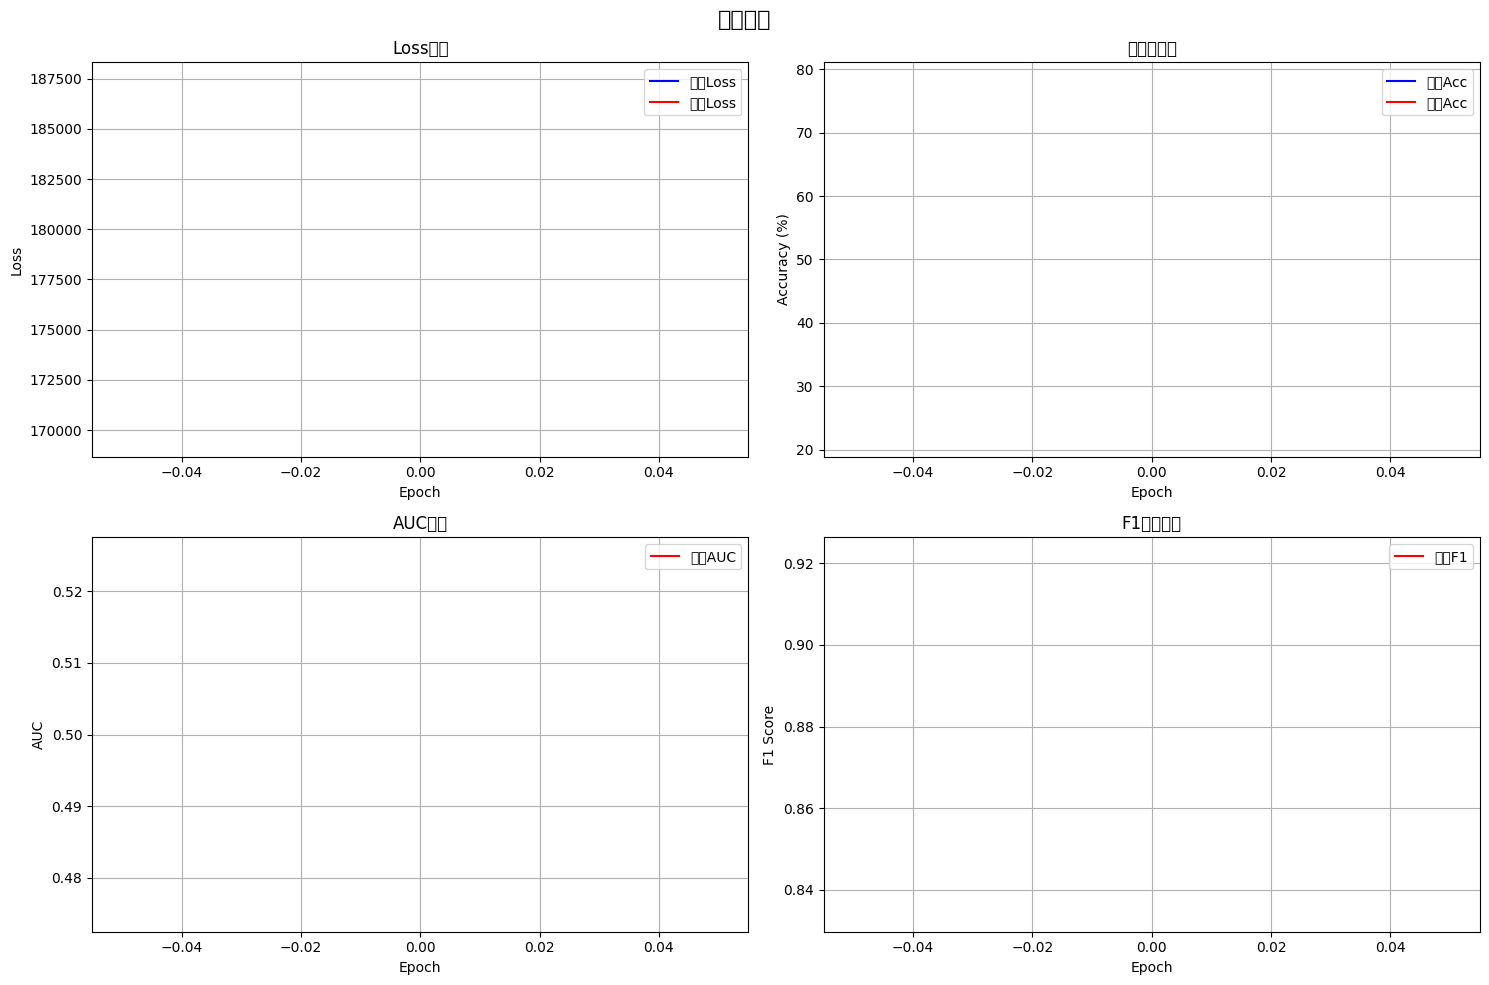

📊 训练历史图表已保存到 ./models/training_history.png


In [13]:
# Cell 12: 训练循环

import os
import time

# 确保模型保存目录存在
os.makedirs('./models', exist_ok=True)

print("🚀 开始训练...")
print(f"📊 训练配置: {len(train_loader)} 个训练批次, {len(val_loader)} 个验证批次")
print(f"🎯 模型参数数量: {sum(p.numel() for p in model.parameters()):,}")
print(f"💾 设备: {device}")
print(f"📦 批次大小: {batch_size}")

if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")
    torch.cuda.reset_peak_memory_stats()

# 训练历史记录
train_history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'val_auc': [],
    'val_precision': [],
    'val_recall': [],
    'val_f1': []
}

best_val_loss = float('inf')
best_val_acc = 0.0
best_val_auc = 0.0

# 训练循环
print("\n🔄 开始训练循环...")
for epoch in range(num_epochs):
    epoch_start_time = time.time()
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    
    # 训练阶段
    train_results = train_epoch(
        model, train_loader, criterion, optimizer, device, 
        scheduler=scheduler, use_amp=True, gradient_clip=1.0
    )
    
    # 验证阶段
    val_results = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # 提取结果
    train_loss = train_results['loss']
    train_acc = train_results['accuracy'] * 100
    
    val_loss = val_results['loss']
    val_acc = val_results['accuracy'] * 100
    val_auc = val_results['auc']
    val_precision = val_results['precision']
    val_recall = val_results['recall']
    val_f1 = val_results['f1']
    
    # 记录历史
    train_history['train_loss'].append(train_loss)
    train_history['train_acc'].append(train_acc)
    train_history['val_loss'].append(val_loss)
    train_history['val_acc'].append(val_acc)
    train_history['val_auc'].append(val_auc)
    train_history['val_precision'].append(val_precision)
    train_history['val_recall'].append(val_recall)
    train_history['val_f1'].append(val_f1)
    
    # 学习率调度
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # 计算epoch时间
    epoch_time = time.time() - epoch_start_time
    
    # 打印结果
    print(f"训练: Loss={train_loss:.4f}, Acc={train_acc:.2f}%")
    print(f"验证: Loss={val_loss:.4f}, Acc={val_acc:.2f}%, AUC={val_auc:.4f}, F1={val_f1:.4f}")
    print(f"学习率: {current_lr:.2e}, 用时: {epoch_time:.1f}s")
    
    # 保存最佳模型
    if val_acc > best_val_acc:
        best_val_loss = val_loss
        best_val_acc = val_acc
        best_val_auc = val_auc
        
        print(f"🎯 新的最佳模型! Acc: {best_val_acc:.2f}%, AUC: {best_val_auc:.4f}")
        
        # 保存最佳模型
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'best_val_acc': best_val_acc,
            'best_val_auc': best_val_auc,
            'train_history': train_history
        }, './models/best_model.pth')
        print("💾 最佳模型已保存")
    
    # 早停检查
    if early_stopping(val_loss, model):
        print(f"\n⏹️ 早停触发，在第 {epoch+1} 轮停止训练")
        break
    
    # 清理GPU缓存 - 双T4 GPU内存管理
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        # 检查内存使用情况 - 双T4有更大内存容量
        memory_used = torch.cuda.memory_allocated() / 1024**3
        if memory_used > 20:  # 双T4可以使用更多内存，提高阈值到20GB
            torch.cuda.empty_cache()
            print(f"⚠️ 内存使用过高 ({memory_used:.1f}GB)，已清理缓存")
    
    # 检查训练时间，防止超时 - 双T4可以运行更长时间
    total_time = time.time() - epoch_start_time
    if total_time > 7200:  # 双T4可以运行更长时间，提高到2小时
        print(f"⏰ 训练时间过长 ({total_time/60:.1f}分钟)，提前停止")
        break

print("\n✅ 训练完成!")
print(f"🏆 最终最佳性能: Loss={best_val_loss:.4f}, Acc={best_val_acc:.2f}%, AUC={best_val_auc:.4f}")

if torch.cuda.is_available():
    print(f"💾 峰值GPU内存使用: {torch.cuda.max_memory_allocated() / 1024**3:.1f}GB")

# 绘制训练历史
def plot_training_history():
    """绘制训练历史图表"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('训练历史', fontsize=16, fontweight='bold')
    
    # Loss
    axes[0, 0].plot(train_history['train_loss'], label='训练Loss', color='blue')
    axes[0, 0].plot(train_history['val_loss'], label='验证Loss', color='red')
    axes[0, 0].set_title('Loss变化')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Accuracy
    axes[0, 1].plot(train_history['train_acc'], label='训练Acc', color='blue')
    axes[0, 1].plot(train_history['val_acc'], label='验证Acc', color='red')
    axes[0, 1].set_title('准确率变化')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # AUC
    axes[1, 0].plot(train_history['val_auc'], label='验证AUC', color='red')
    axes[1, 0].set_title('AUC变化')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # F1 Score
    axes[1, 1].plot(train_history['val_f1'], label='验证F1', color='red')
    axes[1, 1].set_title('F1分数变化')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('F1 Score')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.savefig('./models/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# 绘制训练历史
plot_training_history()

print("📊 训练历史图表已保存到 ./models/training_history.png")

# Cell 13: 模型评估和结果分析


📊 开始模型评估...
🔄 加载最佳模型...
✅ 成功加载第 1 轮的最佳模型
最佳验证准确率: 78.26%
最佳验证AUC: 0.5000

🔍 在测试集上评估模型...
🚀 开始模型评估...


评估进度:   0%|          | 1/461 [00:06<47:28,  6.19s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   0%|          | 2/461 [00:13<50:57,  6.66s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   1%|          | 3/461 [00:21<55:06,  7.22s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   1%|          | 4/461 [00:26<49:34,  6.51s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   1%|          | 5/461 [00:31<46:12,  6.08s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   1%|▏         | 6/461 [00:54<1:28:56, 11.73s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   2%|▏         | 7/461 [00:58<1:09:53,  9.24s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   2%|▏         | 8/461 [01:13<1:23:33, 11.07s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   2%|▏         | 9/461 [01:36<1:51:29, 14.80s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   2%|▏         | 10/461 [01:45<1:37:20, 12.95s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   2%|▏         | 11/461 [01:50<1:18:56, 10.53s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   3%|▎         | 12/461 [01:54<1:02:55,  8.41s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   3%|▎         | 13/461 [01:57<52:37,  7.05s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   3%|▎         | 14/461 [02:16<1:18:53, 10.59s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   3%|▎         | 15/461 [02:38<1:44:07, 14.01s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   3%|▎         | 16/461 [02:50<1:38:41, 13.31s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   4%|▎         | 17/461 [02:53<1:16:57, 10.40s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   4%|▍         | 18/461 [03:06<1:22:35, 11.19s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   4%|▍         | 19/461 [03:13<1:12:09,  9.79s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   4%|▍         | 20/461 [03:25<1:15:59, 10.34s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   5%|▍         | 21/461 [03:36<1:18:03, 10.64s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   5%|▍         | 22/461 [03:42<1:07:55,  9.28s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   5%|▍         | 23/461 [03:53<1:12:21,  9.91s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   5%|▌         | 24/461 [04:07<1:19:06, 10.86s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   5%|▌         | 25/461 [04:10<1:02:07,  8.55s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   6%|▌         | 26/461 [04:16<56:38,  7.81s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   6%|▌         | 27/461 [04:20<48:16,  6.67s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   6%|▌         | 28/461 [04:24<43:28,  6.02s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   6%|▋         | 29/461 [04:36<54:40,  7.59s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   7%|▋         | 30/461 [04:55<1:21:01, 11.28s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   7%|▋         | 31/461 [05:07<1:21:20, 11.35s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   7%|▋         | 32/461 [05:17<1:17:47, 10.88s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   7%|▋         | 33/461 [05:23<1:06:58,  9.39s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   7%|▋         | 34/461 [05:41<1:26:00, 12.08s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   8%|▊         | 35/461 [05:48<1:15:20, 10.61s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   8%|▊         | 36/461 [06:04<1:25:38, 12.09s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   8%|▊         | 37/461 [06:16<1:25:51, 12.15s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   8%|▊         | 38/461 [06:26<1:20:19, 11.39s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   8%|▊         | 39/461 [06:29<1:03:43,  9.06s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   9%|▊         | 40/461 [06:47<1:21:12, 11.57s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   9%|▉         | 41/461 [06:54<1:11:55, 10.28s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   9%|▉         | 42/461 [07:01<1:04:52,  9.29s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:   9%|▉         | 43/461 [07:09<1:02:02,  8.91s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  10%|▉         | 44/461 [07:21<1:08:03,  9.79s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  10%|▉         | 45/461 [07:31<1:08:34,  9.89s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  10%|▉         | 46/461 [07:39<1:03:40,  9.21s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  10%|█         | 47/461 [07:52<1:12:46, 10.55s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  10%|█         | 48/461 [08:02<1:10:20, 10.22s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  11%|█         | 49/461 [08:15<1:15:32, 11.00s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  11%|█         | 50/461 [08:18<1:00:13,  8.79s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  11%|█         | 51/461 [08:58<2:04:15, 18.18s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  11%|█▏        | 52/461 [09:03<1:35:39, 14.03s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  11%|█▏        | 53/461 [09:25<1:52:35, 16.56s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  12%|█▏        | 54/461 [09:34<1:36:25, 14.22s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  12%|█▏        | 55/461 [09:42<1:23:10, 12.29s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  12%|█▏        | 56/461 [10:05<1:44:45, 15.52s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  12%|█▏        | 57/461 [10:22<1:47:41, 15.99s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  13%|█▎        | 58/461 [10:30<1:32:23, 13.75s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  13%|█▎        | 59/461 [10:34<1:12:31, 10.82s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  13%|█▎        | 60/461 [10:40<1:02:57,  9.42s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  13%|█▎        | 61/461 [10:45<53:10,  7.98s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  13%|█▎        | 62/461 [10:50<47:37,  7.16s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  14%|█▎        | 63/461 [10:57<45:53,  6.92s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  14%|█▍        | 64/461 [11:08<54:27,  8.23s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  14%|█▍        | 65/461 [11:27<1:15:02, 11.37s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  14%|█▍        | 66/461 [11:32<1:03:22,  9.63s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  15%|█▍        | 67/461 [11:36<52:37,  8.01s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  15%|█▍        | 68/461 [11:41<44:47,  6.84s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  15%|█▍        | 69/461 [11:45<39:42,  6.08s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  15%|█▌        | 70/461 [12:04<1:04:29,  9.90s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  15%|█▌        | 71/461 [12:13<1:02:59,  9.69s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  16%|█▌        | 72/461 [12:35<1:26:54, 13.41s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  16%|█▌        | 73/461 [12:55<1:40:00, 15.47s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  16%|█▌        | 74/461 [13:17<1:51:07, 17.23s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  16%|█▋        | 75/461 [13:27<1:38:12, 15.27s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  16%|█▋        | 76/461 [13:34<1:21:07, 12.64s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  17%|█▋        | 77/461 [13:56<1:39:04, 15.48s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  17%|█▋        | 78/461 [13:59<1:15:32, 11.83s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  17%|█▋        | 79/461 [14:03<1:00:30,  9.50s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  17%|█▋        | 80/461 [14:08<51:11,  8.06s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  18%|█▊        | 81/461 [14:13<44:34,  7.04s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  18%|█▊        | 82/461 [14:17<40:01,  6.34s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  18%|█▊        | 83/461 [14:22<37:04,  5.88s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  18%|█▊        | 84/461 [14:36<51:43,  8.23s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  18%|█▊        | 85/461 [14:42<48:23,  7.72s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  19%|█▊        | 86/461 [14:52<51:02,  8.17s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  19%|█▉        | 87/461 [14:58<47:29,  7.62s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  19%|█▉        | 88/461 [15:11<58:18,  9.38s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  19%|█▉        | 89/461 [15:15<47:43,  7.70s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  20%|█▉        | 90/461 [15:22<46:41,  7.55s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  20%|█▉        | 91/461 [15:25<38:15,  6.20s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  20%|█▉        | 92/461 [15:34<42:18,  6.88s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  20%|██        | 93/461 [15:41<42:49,  6.98s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  20%|██        | 94/461 [15:51<47:28,  7.76s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  21%|██        | 95/461 [15:54<40:02,  6.56s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  21%|██        | 96/461 [16:13<1:01:15, 10.07s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  21%|██        | 97/461 [16:25<1:04:27, 10.63s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  21%|██▏       | 98/461 [16:30<54:50,  9.06s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  21%|██▏       | 99/461 [16:36<48:54,  8.11s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  22%|██▏       | 100/461 [16:49<57:07,  9.49s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  22%|██▏       | 101/461 [17:04<1:07:16, 11.21s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  22%|██▏       | 102/461 [17:22<1:18:45, 13.16s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  22%|██▏       | 103/461 [17:28<1:07:19, 11.28s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  23%|██▎       | 104/461 [17:41<1:09:49, 11.74s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  23%|██▎       | 105/461 [17:53<1:10:14, 11.84s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  23%|██▎       | 106/461 [18:16<1:29:08, 15.07s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  23%|██▎       | 107/461 [18:23<1:14:36, 12.65s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  23%|██▎       | 108/461 [18:33<1:09:04, 11.74s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  24%|██▎       | 109/461 [18:37<56:28,  9.63s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  24%|██▍       | 110/461 [18:45<53:36,  9.16s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  24%|██▍       | 111/461 [18:51<46:47,  8.02s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  24%|██▍       | 112/461 [19:12<1:09:28, 11.94s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  25%|██▍       | 113/461 [19:24<1:08:55, 11.88s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  25%|██▍       | 114/461 [19:32<1:02:38, 10.83s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  25%|██▍       | 115/461 [19:58<1:28:51, 15.41s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  25%|██▌       | 116/461 [20:06<1:16:22, 13.28s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  25%|██▌       | 117/461 [20:12<1:03:38, 11.10s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  26%|██▌       | 118/461 [20:16<51:04,  8.93s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  26%|██▌       | 119/461 [20:22<46:05,  8.09s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  26%|██▌       | 120/461 [20:34<51:43,  9.10s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  26%|██▌       | 121/461 [20:46<56:26,  9.96s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  26%|██▋       | 122/461 [20:49<45:38,  8.08s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  27%|██▋       | 123/461 [20:56<43:25,  7.71s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  27%|██▋       | 124/461 [21:24<1:16:21, 13.60s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  27%|██▋       | 125/461 [21:31<1:06:02, 11.79s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  27%|██▋       | 126/461 [21:40<1:01:09, 10.96s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  28%|██▊       | 127/461 [21:45<51:05,  9.18s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  28%|██▊       | 128/461 [21:52<47:15,  8.51s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  28%|██▊       | 129/461 [22:01<47:31,  8.59s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  28%|██▊       | 130/461 [22:16<57:12, 10.37s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  28%|██▊       | 131/461 [22:19<45:21,  8.25s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  29%|██▊       | 132/461 [22:23<38:39,  7.05s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  29%|██▉       | 133/461 [22:31<39:37,  7.25s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  29%|██▉       | 134/461 [22:40<42:23,  7.78s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  29%|██▉       | 135/461 [22:44<36:31,  6.72s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  30%|██▉       | 136/461 [22:48<32:14,  5.95s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  30%|██▉       | 137/461 [22:57<36:07,  6.69s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  30%|██▉       | 138/461 [23:02<34:29,  6.41s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  30%|███       | 139/461 [23:15<44:27,  8.29s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  30%|███       | 140/461 [23:22<41:41,  7.79s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  31%|███       | 141/461 [23:27<38:08,  7.15s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  31%|███       | 142/461 [23:41<48:24,  9.10s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  31%|███       | 143/461 [23:45<40:05,  7.56s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  31%|███       | 144/461 [23:50<35:55,  6.80s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  31%|███▏      | 145/461 [24:14<1:03:20, 12.03s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  32%|███▏      | 146/461 [24:24<1:00:22, 11.50s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  32%|███▏      | 147/461 [24:27<46:52,  8.96s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  32%|███▏      | 148/461 [24:32<39:25,  7.56s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  32%|███▏      | 149/461 [24:50<55:55, 10.75s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  33%|███▎      | 150/461 [24:59<53:44, 10.37s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  33%|███▎      | 151/461 [25:03<43:43,  8.46s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  33%|███▎      | 152/461 [25:08<37:56,  7.37s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  33%|███▎      | 153/461 [25:21<45:44,  8.91s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  33%|███▎      | 154/461 [25:27<40:45,  7.97s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  34%|███▎      | 155/461 [25:33<38:25,  7.53s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  34%|███▍      | 156/461 [25:45<44:37,  8.78s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  34%|███▍      | 157/461 [25:52<42:38,  8.42s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  34%|███▍      | 158/461 [26:05<48:57,  9.70s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  34%|███▍      | 159/461 [26:10<41:29,  8.24s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  35%|███▍      | 160/461 [26:26<53:12, 10.61s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  35%|███▍      | 161/461 [26:34<49:01,  9.81s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  35%|███▌      | 162/461 [26:43<47:57,  9.62s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  35%|███▌      | 163/461 [26:56<52:44, 10.62s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  36%|███▌      | 164/461 [27:08<54:37, 11.03s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  36%|███▌      | 165/461 [27:12<44:21,  8.99s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  36%|███▌      | 166/461 [27:18<39:09,  7.96s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  36%|███▌      | 167/461 [27:32<48:44,  9.95s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  36%|███▋      | 168/461 [27:36<38:53,  7.96s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  37%|███▋      | 169/461 [27:40<33:14,  6.83s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  37%|███▋      | 170/461 [27:46<32:35,  6.72s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  37%|███▋      | 171/461 [27:57<37:43,  7.81s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  37%|███▋      | 172/461 [28:04<36:45,  7.63s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  38%|███▊      | 173/461 [28:20<48:20, 10.07s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  38%|███▊      | 174/461 [28:35<55:33, 11.61s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  38%|███▊      | 175/461 [28:46<55:03, 11.55s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  38%|███▊      | 176/461 [28:50<43:42,  9.20s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  38%|███▊      | 177/461 [28:54<35:32,  7.51s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  39%|███▊      | 178/461 [29:03<37:42,  8.00s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  39%|███▉      | 179/461 [29:10<36:19,  7.73s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  39%|███▉      | 180/461 [29:15<32:06,  6.86s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  39%|███▉      | 181/461 [29:26<38:21,  8.22s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  39%|███▉      | 182/461 [29:32<35:30,  7.64s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  40%|███▉      | 183/461 [29:39<34:31,  7.45s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  40%|███▉      | 184/461 [29:58<49:54, 10.81s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  40%|████      | 185/461 [30:08<48:01, 10.44s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  40%|████      | 186/461 [30:31<1:05:28, 14.28s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  41%|████      | 187/461 [30:35<50:56, 11.16s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  41%|████      | 188/461 [30:38<39:52,  8.76s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  41%|████      | 189/461 [30:44<36:20,  8.01s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  41%|████      | 190/461 [30:58<43:59,  9.74s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  41%|████▏     | 191/461 [31:10<47:05, 10.47s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  42%|████▏     | 192/461 [31:14<37:41,  8.41s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  42%|████▏     | 193/461 [31:20<34:31,  7.73s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  42%|████▏     | 194/461 [31:26<32:48,  7.37s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  42%|████▏     | 195/461 [31:34<32:39,  7.37s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  43%|████▎     | 196/461 [31:38<27:56,  6.32s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  43%|████▎     | 197/461 [31:42<25:46,  5.86s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  43%|████▎     | 198/461 [31:51<28:37,  6.53s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  43%|████▎     | 199/461 [31:59<31:29,  7.21s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  43%|████▎     | 200/461 [32:12<38:27,  8.84s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  44%|████▎     | 201/461 [32:17<33:20,  7.69s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  44%|████▍     | 202/461 [32:21<28:25,  6.58s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  44%|████▍     | 203/461 [32:27<28:08,  6.54s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  44%|████▍     | 204/461 [32:40<35:48,  8.36s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  44%|████▍     | 205/461 [32:44<29:53,  7.00s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  45%|████▍     | 206/461 [32:52<31:29,  7.41s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  45%|████▍     | 207/461 [33:03<35:03,  8.28s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  45%|████▌     | 208/461 [33:09<32:24,  7.69s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  45%|████▌     | 209/461 [33:21<38:30,  9.17s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  46%|████▌     | 210/461 [33:32<39:30,  9.44s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  46%|████▌     | 211/461 [33:41<39:21,  9.44s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  46%|████▌     | 212/461 [33:45<32:53,  7.93s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  46%|████▌     | 213/461 [33:57<37:07,  8.98s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  46%|████▋     | 214/461 [34:07<38:53,  9.45s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  47%|████▋     | 215/461 [34:23<46:10, 11.26s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  47%|████▋     | 216/461 [34:35<46:31, 11.39s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  47%|████▋     | 217/461 [34:43<42:31, 10.46s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  47%|████▋     | 218/461 [35:09<1:01:09, 15.10s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  48%|████▊     | 219/461 [35:13<47:52, 11.87s/it]  

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  48%|████▊     | 220/461 [35:18<39:36,  9.86s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  48%|████▊     | 221/461 [35:22<32:23,  8.10s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  48%|████▊     | 222/461 [35:30<31:56,  8.02s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  48%|████▊     | 223/461 [35:36<28:51,  7.28s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  49%|████▊     | 224/461 [35:42<27:44,  7.03s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  49%|████▉     | 225/461 [35:47<24:48,  6.31s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  49%|████▉     | 226/461 [35:53<24:36,  6.28s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  49%|████▉     | 227/461 [36:07<33:23,  8.56s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  49%|████▉     | 228/461 [36:14<32:00,  8.24s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  50%|████▉     | 229/461 [36:26<35:17,  9.13s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  50%|████▉     | 230/461 [36:32<31:47,  8.26s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  50%|█████     | 231/461 [36:39<30:09,  7.87s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  50%|█████     | 232/461 [36:52<35:56,  9.42s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  51%|█████     | 233/461 [36:55<29:16,  7.71s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  51%|█████     | 234/461 [37:08<35:13,  9.31s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  51%|█████     | 235/461 [37:23<40:28, 10.75s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  51%|█████     | 236/461 [37:41<49:13, 13.13s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  51%|█████▏    | 237/461 [37:48<41:49, 11.20s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  52%|█████▏    | 238/461 [38:03<45:46, 12.32s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  52%|█████▏    | 239/461 [38:09<39:05, 10.56s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  52%|█████▏    | 240/461 [38:18<37:02, 10.06s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  52%|█████▏    | 241/461 [38:24<32:32,  8.88s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  52%|█████▏    | 242/461 [38:34<33:40,  9.23s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  53%|█████▎    | 243/461 [38:46<36:36, 10.08s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  53%|█████▎    | 244/461 [38:55<34:55,  9.65s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  53%|█████▎    | 245/461 [39:06<36:06, 10.03s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  53%|█████▎    | 246/461 [39:14<33:34,  9.37s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  54%|█████▎    | 247/461 [39:20<29:51,  8.37s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  54%|█████▍    | 248/461 [39:34<35:29, 10.00s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  54%|█████▍    | 249/461 [39:39<30:35,  8.66s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  54%|█████▍    | 250/461 [39:44<26:33,  7.55s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  54%|█████▍    | 251/461 [39:54<28:49,  8.24s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  55%|█████▍    | 252/461 [40:05<31:20,  9.00s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  55%|█████▍    | 253/461 [40:09<26:07,  7.54s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  55%|█████▌    | 254/461 [40:18<27:08,  7.87s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  55%|█████▌    | 255/461 [40:24<25:01,  7.29s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  56%|█████▌    | 256/461 [40:29<22:38,  6.63s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  56%|█████▌    | 257/461 [40:32<19:42,  5.80s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  56%|█████▌    | 258/461 [40:41<22:00,  6.51s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  56%|█████▌    | 259/461 [40:45<20:10,  5.99s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  56%|█████▋    | 260/461 [40:49<17:09,  5.12s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  57%|█████▋    | 261/461 [40:58<21:35,  6.48s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  57%|█████▋    | 262/461 [41:06<22:37,  6.82s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  57%|█████▋    | 263/461 [41:12<22:20,  6.77s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  57%|█████▋    | 264/461 [41:20<22:41,  6.91s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  57%|█████▋    | 265/461 [41:25<21:12,  6.49s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  58%|█████▊    | 266/461 [41:32<21:15,  6.54s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  58%|█████▊    | 267/461 [41:40<22:30,  6.96s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  58%|█████▊    | 268/461 [41:43<19:09,  5.96s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  58%|█████▊    | 269/461 [41:53<22:27,  7.02s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  59%|█████▊    | 270/461 [42:03<25:28,  8.00s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  59%|█████▉    | 271/461 [42:08<22:19,  7.05s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  59%|█████▉    | 272/461 [42:14<21:21,  6.78s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  59%|█████▉    | 273/461 [42:28<27:44,  8.85s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  59%|█████▉    | 274/461 [42:33<24:03,  7.72s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  60%|█████▉    | 275/461 [42:39<22:11,  7.16s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  60%|█████▉    | 276/461 [42:51<26:59,  8.76s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  60%|██████    | 277/461 [42:58<25:25,  8.29s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  60%|██████    | 278/461 [43:09<27:11,  8.92s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  61%|██████    | 279/461 [43:18<26:51,  8.86s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  61%|██████    | 280/461 [43:23<23:19,  7.73s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  61%|██████    | 281/461 [43:35<27:11,  9.06s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  61%|██████    | 282/461 [43:48<30:51, 10.34s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  61%|██████▏   | 283/461 [43:57<29:38,  9.99s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  62%|██████▏   | 284/461 [44:04<26:14,  8.90s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  62%|██████▏   | 285/461 [44:20<32:45, 11.17s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  62%|██████▏   | 286/461 [44:26<27:52,  9.56s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  62%|██████▏   | 287/461 [44:30<22:51,  7.88s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  62%|██████▏   | 288/461 [44:47<30:22, 10.53s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  63%|██████▎   | 289/461 [44:50<24:17,  8.48s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  63%|██████▎   | 290/461 [44:56<22:09,  7.77s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  63%|██████▎   | 291/461 [45:02<20:21,  7.19s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  63%|██████▎   | 292/461 [45:12<22:12,  7.89s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  64%|██████▎   | 293/461 [45:25<26:48,  9.58s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  64%|██████▍   | 294/461 [45:31<23:24,  8.41s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  64%|██████▍   | 295/461 [45:37<21:35,  7.80s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  64%|██████▍   | 296/461 [45:45<21:02,  7.65s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  64%|██████▍   | 297/461 [45:59<26:43,  9.78s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  65%|██████▍   | 298/461 [46:05<23:26,  8.63s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  65%|██████▍   | 299/461 [46:15<24:23,  9.03s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  65%|██████▌   | 300/461 [46:23<23:09,  8.63s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  65%|██████▌   | 301/461 [46:38<27:46, 10.42s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  66%|██████▌   | 302/461 [46:41<21:48,  8.23s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  66%|██████▌   | 303/461 [46:54<25:28,  9.67s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  66%|██████▌   | 304/461 [47:01<23:42,  9.06s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  66%|██████▌   | 305/461 [47:04<18:42,  7.19s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  66%|██████▋   | 306/461 [47:10<17:43,  6.86s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  67%|██████▋   | 307/461 [47:16<17:00,  6.63s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  67%|██████▋   | 308/461 [47:27<20:02,  7.86s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  67%|██████▋   | 309/461 [47:32<17:53,  7.06s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  67%|██████▋   | 310/461 [47:40<18:18,  7.28s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  67%|██████▋   | 311/461 [47:46<17:20,  6.93s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  68%|██████▊   | 312/461 [47:50<15:08,  6.10s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  68%|██████▊   | 313/461 [47:58<16:13,  6.58s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  68%|██████▊   | 314/461 [48:06<17:04,  6.97s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  68%|██████▊   | 315/461 [48:09<14:22,  5.90s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  69%|██████▊   | 316/461 [48:14<13:11,  5.46s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  69%|██████▉   | 317/461 [48:26<17:52,  7.45s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  69%|██████▉   | 318/461 [48:54<32:42, 13.72s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  69%|██████▉   | 319/461 [49:00<26:51, 11.35s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  69%|██████▉   | 320/461 [49:15<29:18, 12.47s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  70%|██████▉   | 321/461 [49:25<27:11, 11.65s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  70%|██████▉   | 322/461 [49:35<25:36, 11.05s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  70%|███████   | 323/461 [49:57<32:56, 14.32s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  70%|███████   | 324/461 [50:06<29:16, 12.82s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  70%|███████   | 325/461 [50:15<26:54, 11.87s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  71%|███████   | 326/461 [50:20<21:47,  9.68s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  71%|███████   | 327/461 [50:33<23:31, 10.53s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  71%|███████   | 328/461 [50:38<19:53,  8.98s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  71%|███████▏  | 329/461 [50:52<22:52, 10.39s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  72%|███████▏  | 330/461 [51:05<24:20, 11.15s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  72%|███████▏  | 331/461 [51:08<19:17,  8.91s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  72%|███████▏  | 332/461 [51:16<18:12,  8.47s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  72%|███████▏  | 333/461 [51:20<15:33,  7.30s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  72%|███████▏  | 334/461 [51:40<23:04, 10.90s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  73%|███████▎  | 335/461 [51:52<24:01, 11.44s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  73%|███████▎  | 336/461 [52:00<21:40, 10.40s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  73%|███████▎  | 337/461 [52:13<23:03, 11.16s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  73%|███████▎  | 338/461 [52:19<19:33,  9.54s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  74%|███████▎  | 339/461 [52:27<18:30,  9.10s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  74%|███████▍  | 340/461 [52:55<29:44, 14.75s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  74%|███████▍  | 341/461 [53:10<29:52, 14.94s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  74%|███████▍  | 342/461 [53:19<25:38, 12.93s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  74%|███████▍  | 343/461 [53:32<25:39, 13.05s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  75%|███████▍  | 344/461 [53:36<20:11, 10.35s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  75%|███████▍  | 345/461 [53:40<16:36,  8.59s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  75%|███████▌  | 346/461 [53:56<20:12, 10.54s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  75%|███████▌  | 347/461 [54:02<17:55,  9.43s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  75%|███████▌  | 348/461 [54:12<17:51,  9.48s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  76%|███████▌  | 349/461 [54:26<20:14, 10.84s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  76%|███████▌  | 350/461 [54:43<23:14, 12.57s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  76%|███████▌  | 351/461 [54:46<18:03,  9.85s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  76%|███████▋  | 352/461 [54:50<14:49,  8.16s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  77%|███████▋  | 353/461 [54:58<14:40,  8.15s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  77%|███████▋  | 354/461 [55:12<17:35,  9.86s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  77%|███████▋  | 355/461 [55:22<17:23,  9.85s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  77%|███████▋  | 356/461 [55:31<16:43,  9.56s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  77%|███████▋  | 357/461 [55:38<15:26,  8.91s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  78%|███████▊  | 358/461 [55:42<12:45,  7.43s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  78%|███████▊  | 359/461 [55:51<13:28,  7.92s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  78%|███████▊  | 360/461 [56:01<14:06,  8.38s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  78%|███████▊  | 361/461 [56:11<15:05,  9.06s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  79%|███████▊  | 362/461 [56:16<12:47,  7.75s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  79%|███████▊  | 363/461 [56:20<10:43,  6.57s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  79%|███████▉  | 364/461 [56:39<16:26, 10.17s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  79%|███████▉  | 365/461 [56:42<12:49,  8.01s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  79%|███████▉  | 366/461 [56:47<11:40,  7.38s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  80%|███████▉  | 367/461 [57:07<17:11, 10.98s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  80%|███████▉  | 368/461 [57:14<15:20,  9.89s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  80%|████████  | 369/461 [57:25<15:35, 10.17s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  80%|████████  | 370/461 [57:31<13:36,  8.97s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  80%|████████  | 371/461 [57:35<11:19,  7.55s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  81%|████████  | 372/461 [57:47<12:47,  8.62s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  81%|████████  | 373/461 [57:54<11:57,  8.15s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  81%|████████  | 374/461 [58:03<12:19,  8.50s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  81%|████████▏ | 375/461 [58:09<11:06,  7.75s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  82%|████████▏ | 376/461 [58:16<10:43,  7.57s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  82%|████████▏ | 377/461 [58:22<09:47,  7.00s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  82%|████████▏ | 378/461 [58:28<09:12,  6.65s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  82%|████████▏ | 379/461 [58:31<07:54,  5.79s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  82%|████████▏ | 380/461 [58:44<10:48,  8.00s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  83%|████████▎ | 381/461 [58:50<09:49,  7.37s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  83%|████████▎ | 382/461 [59:03<11:48,  8.97s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  83%|████████▎ | 383/461 [59:11<11:12,  8.62s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  83%|████████▎ | 384/461 [59:14<09:06,  7.10s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  84%|████████▎ | 385/461 [59:25<10:15,  8.10s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  84%|████████▎ | 386/461 [59:43<13:58, 11.18s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  84%|████████▍ | 387/461 [59:53<13:15, 10.75s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  84%|████████▍ | 388/461 [1:00:02<12:31, 10.29s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  84%|████████▍ | 389/461 [1:00:09<11:12,  9.34s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  85%|████████▍ | 390/461 [1:00:14<09:28,  8.00s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  85%|████████▍ | 391/461 [1:00:21<09:00,  7.72s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  85%|████████▌ | 392/461 [1:00:34<10:44,  9.34s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  85%|████████▌ | 393/461 [1:00:50<12:48, 11.30s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  85%|████████▌ | 394/461 [1:01:09<15:14, 13.64s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  86%|████████▌ | 395/461 [1:01:13<11:37, 10.57s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  86%|████████▌ | 396/461 [1:01:22<11:00, 10.16s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  86%|████████▌ | 397/461 [1:01:29<09:50,  9.22s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  86%|████████▋ | 398/461 [1:01:34<08:26,  8.04s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  87%|████████▋ | 399/461 [1:01:45<09:08,  8.84s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  87%|████████▋ | 400/461 [1:01:58<10:17, 10.13s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  87%|████████▋ | 401/461 [1:02:09<10:27, 10.47s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  87%|████████▋ | 402/461 [1:02:20<10:16, 10.45s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  87%|████████▋ | 403/461 [1:02:38<12:14, 12.67s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  88%|████████▊ | 404/461 [1:02:51<12:16, 12.93s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  88%|████████▊ | 405/461 [1:03:02<11:29, 12.31s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  88%|████████▊ | 406/461 [1:03:17<11:58, 13.07s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  88%|████████▊ | 407/461 [1:03:22<09:42, 10.78s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  89%|████████▊ | 408/461 [1:03:28<08:11,  9.27s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  89%|████████▊ | 409/461 [1:03:35<07:31,  8.68s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  89%|████████▉ | 410/461 [1:03:40<06:17,  7.41s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  89%|████████▉ | 411/461 [1:03:47<06:12,  7.45s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  89%|████████▉ | 412/461 [1:04:01<07:41,  9.42s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  90%|████████▉ | 413/461 [1:04:07<06:38,  8.31s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  90%|████████▉ | 414/461 [1:04:13<06:01,  7.69s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  90%|█████████ | 415/461 [1:04:18<05:05,  6.64s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  90%|█████████ | 416/461 [1:04:22<04:24,  5.87s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  90%|█████████ | 417/461 [1:04:25<03:51,  5.26s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  91%|█████████ | 418/461 [1:04:36<04:48,  6.71s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  91%|█████████ | 419/461 [1:04:42<04:39,  6.66s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  91%|█████████ | 420/461 [1:04:48<04:23,  6.42s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  91%|█████████▏| 421/461 [1:05:00<05:24,  8.11s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  92%|█████████▏| 422/461 [1:05:06<04:52,  7.49s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  92%|█████████▏| 423/461 [1:05:11<04:11,  6.61s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  92%|█████████▏| 424/461 [1:05:25<05:35,  9.07s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  92%|█████████▏| 425/461 [1:05:32<04:57,  8.26s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  92%|█████████▏| 426/461 [1:05:43<05:17,  9.08s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  93%|█████████▎| 427/461 [1:05:49<04:39,  8.21s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  93%|█████████▎| 428/461 [1:05:54<04:02,  7.34s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  93%|█████████▎| 429/461 [1:06:05<04:23,  8.23s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  93%|█████████▎| 430/461 [1:06:28<06:33, 12.68s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  93%|█████████▎| 431/461 [1:06:43<06:45, 13.51s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  94%|█████████▎| 432/461 [1:06:48<05:17, 10.94s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  94%|█████████▍| 433/461 [1:06:54<04:27,  9.57s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  94%|█████████▍| 434/461 [1:07:01<03:55,  8.72s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  94%|█████████▍| 435/461 [1:07:21<05:10, 11.93s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  95%|█████████▍| 436/461 [1:07:24<03:57,  9.48s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  95%|█████████▍| 437/461 [1:07:28<03:09,  7.89s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  95%|█████████▌| 438/461 [1:07:43<03:46,  9.85s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  95%|█████████▌| 439/461 [1:07:50<03:16,  8.94s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  95%|█████████▌| 440/461 [1:08:00<03:18,  9.46s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  96%|█████████▌| 441/461 [1:08:06<02:45,  8.30s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  96%|█████████▌| 442/461 [1:08:13<02:29,  7.86s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  96%|█████████▌| 443/461 [1:08:25<02:42,  9.03s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  96%|█████████▋| 444/461 [1:08:37<02:51, 10.08s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  97%|█████████▋| 445/461 [1:08:53<03:09, 11.85s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  97%|█████████▋| 446/461 [1:09:00<02:37, 10.49s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  97%|█████████▋| 447/461 [1:09:04<01:57,  8.42s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  97%|█████████▋| 448/461 [1:09:20<02:18, 10.63s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  97%|█████████▋| 449/461 [1:09:27<01:54,  9.51s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  98%|█████████▊| 450/461 [1:09:33<01:34,  8.63s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  98%|█████████▊| 451/461 [1:09:40<01:21,  8.20s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  98%|█████████▊| 452/461 [1:09:52<01:21,  9.06s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  98%|█████████▊| 453/461 [1:10:00<01:10,  8.78s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  98%|█████████▊| 454/461 [1:10:11<01:07,  9.67s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  99%|█████████▊| 455/461 [1:10:27<01:08, 11.48s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  99%|█████████▉| 456/461 [1:10:33<00:48,  9.69s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  99%|█████████▉| 457/461 [1:10:39<00:35,  8.84s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度:  99%|█████████▉| 458/461 [1:10:46<00:24,  8.03s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度: 100%|█████████▉| 459/461 [1:10:51<00:14,  7.13s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度: 100%|█████████▉| 460/461 [1:10:54<00:06,  6.05s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])


评估进度: 100%|██████████| 461/461 [1:11:05<00:00,  9.25s/it]

🔍 融合特征维度: [2048, 128, 32, 32]
✅ 特征融合成功: torch.Size([2, 2240]) -> torch.Size([2, 256])
✅ 评估完成
平均损失: 196426.2924
平均推理时间: 92.87 ms/batch

📈 计算评估指标...

📊 详细评估结果:
测试损失: 196426.2924
准确率: 0.7820 (78.20%)
平衡准确率: 0.5000 (50.00%)
精确率: 0.7820
召回率: 1.0000
特异性: 0.0000
F1分数: 0.8777
AUC-ROC: 0.5000
AUC-PR: 0.8910
负预测值: 0.0000

🔍 混淆矩阵分析:
真负例 (TN): 0
假正例 (FP): 201
假负例 (FN): 0
真正例 (TP): 721

⚡ 性能分析:
平均推理时间: 92.87 ms/batch
总推理时间: 42.81 秒
每个样本推理时间: 46.44 ms

📋 类别特定分析:
总样本数: 922
真实视频样本: 201 (21.8%)
伪造视频样本: 721 (78.2%)
真实视频检测准确率: 0.0000 (0.00%)
伪造视频检测准确率: 1.0000 (100.00%)

📊 生成评估图表...


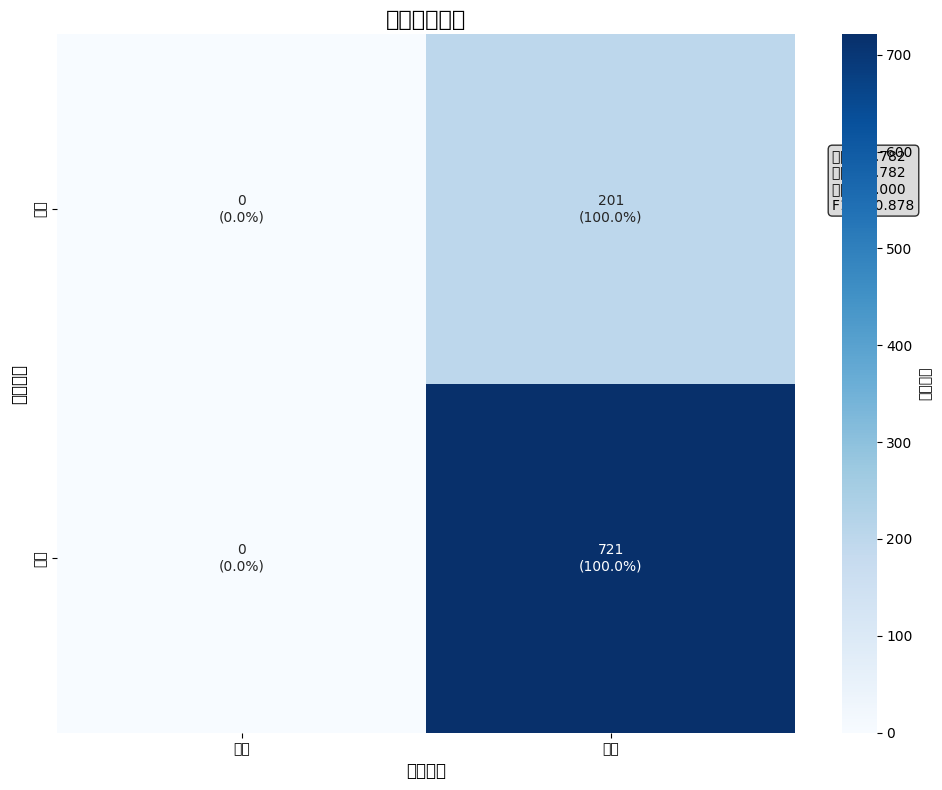

混淆矩阵已保存到: ./results/evaluation/confusion_matrix.png


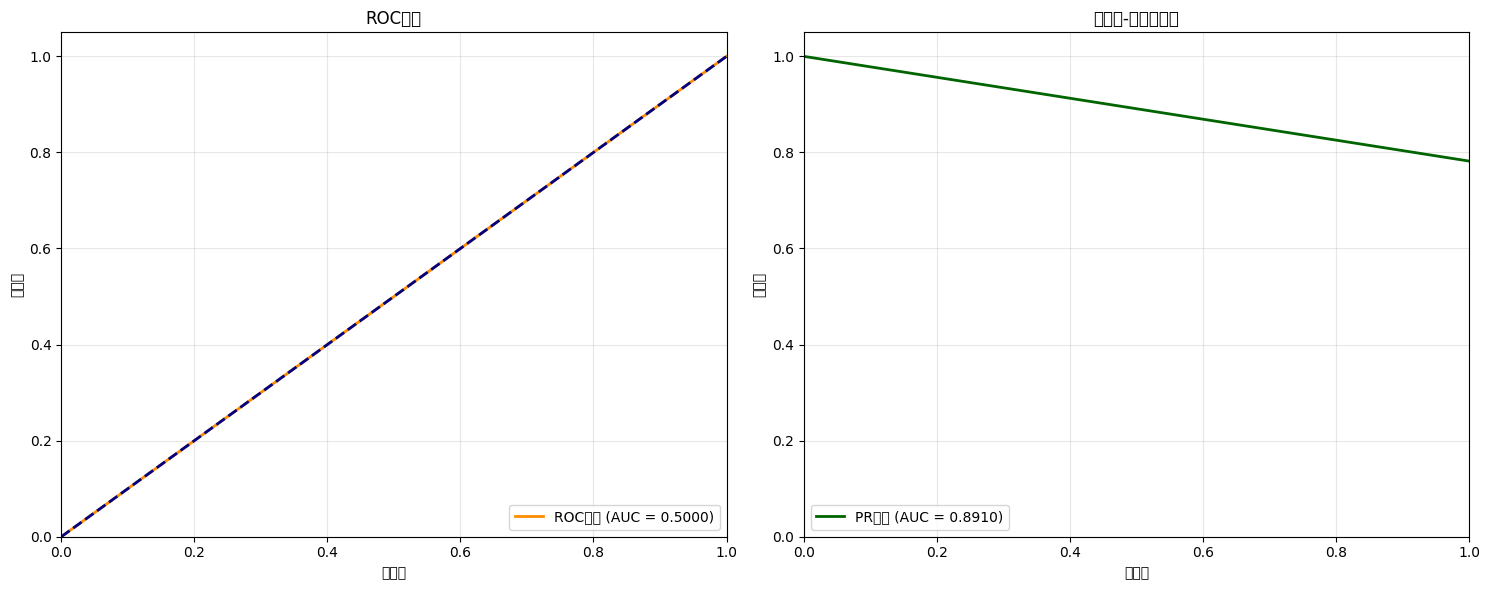

ROC/PR曲线已保存到: ./results/evaluation/roc_pr_curves.png


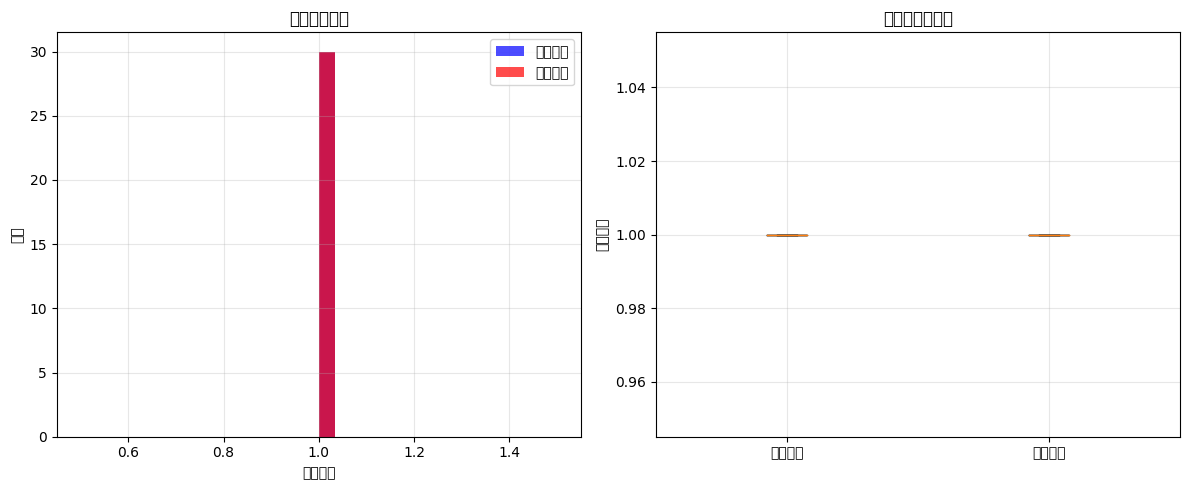

✅ 评估图表生成完成

📊 类别不平衡分析报告

📈 数据分布:
  真实视频样本: 201
  伪造视频样本: 721
  不平衡比例: 3.59:1 (伪造:真实)

🎯 类别特定准确率:
  真实视频检测准确率: 0.00%
  伪造视频检测准确率: 100.00%

📋 混淆矩阵分析:
  真负例 (TN): 0 - 正确识别的真实视频
  假正例 (FP): 201 - 误判为伪造的真实视频
  假负例 (FN): 0 - 误判为真实的伪造视频
  真正例 (TP): 721 - 正确识别的伪造视频

⚖️ 模型偏向性分析:
  预测为真实的样本: 0 (0.0%)
  预测为伪造的样本: 922 (100.0%)

🔍 问题诊断:
  ❌ 严重问题: 模型几乎无法识别真实视频
  ❌ 严重偏向: 模型过度偏向预测伪造视频
  ❌ AUC-ROC过低: 模型判别能力接近随机猜测

💡 改进建议:
  1. 增加真实视频样本或减少伪造视频样本
  2. 使用更强的类别权重 (pos_weight > 3.0)
  3. 调整Focal Loss参数 (降低alpha, 增加gamma)
  4. 检查数据质量，确保真实视频标签正确
  5. 使用成本敏感学习方法
  6. 考虑使用SMOTE等过采样技术
  7. 重新设计模型架构
  8. 增加模型复杂度或使用预训练模型
  9. 检查特征提取是否有效
🎉 模型评估完成！
📁 所有结果已保存到 ./results/evaluation/ 目录

💡 如果发现严重的类别偏向问题，请参考上述改进建议进行优化


In [14]:
# Cell 13: 模型评估和结果分析

import torch
import os

print("📊 开始模型评估...")
print("=" * 60)

# 加载最佳模型
print("🔄 加载最佳模型...")
try:
    # 使用weights_only=False来兼容旧版本的模型文件
    checkpoint = torch.load('./models/best_model.pth', map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    best_val_auc = checkpoint['best_val_auc']
    
    print(f"✅ 成功加载第 {best_epoch+1} 轮的最佳模型")
    print(f"最佳验证准确率: {best_val_acc:.2f}%")
    print(f"最佳验证AUC: {best_val_auc:.4f}")
except Exception as e:
    print(f"❌ 加载模型失败: {e}")
    print("使用当前模型进行评估")

# 在测试集上评估模型
print("\n🔍 在测试集上评估模型...")
eval_results = evaluate_model_optimized(model, test_loader, criterion, device)

# 计算全面的评估指标
print("\n📈 计算评估指标...")
metrics = calculate_comprehensive_metrics(
    eval_results['predictions'], 
    eval_results['targets'], 
    eval_results['scores']
)

# 打印详细结果
print("\n📊 详细评估结果:")
print("=" * 50)
print(f"测试损失: {eval_results['loss']:.4f}")
print(f"准确率: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)")
print(f"平衡准确率: {metrics['balanced_accuracy']:.4f} ({metrics['balanced_accuracy']*100:.2f}%)")
print(f"精确率: {metrics['precision']:.4f}")
print(f"召回率: {metrics['recall']:.4f}")
print(f"特异性: {metrics['specificity']:.4f}")
print(f"F1分数: {metrics['f1']:.4f}")
print(f"AUC-ROC: {metrics['auc_roc']:.4f}")
print(f"AUC-PR: {metrics['auc_pr']:.4f}")
print(f"负预测值: {metrics['npv']:.4f}")

# 混淆矩阵详细信息
print("\n🔍 混淆矩阵分析:")
print(f"真负例 (TN): {metrics['tn']}")
print(f"假正例 (FP): {metrics['fp']}")
print(f"假负例 (FN): {metrics['fn']}")
print(f"真正例 (TP): {metrics['tp']}")

# 性能分析
print("\n⚡ 性能分析:")
print(f"平均推理时间: {eval_results['avg_inference_time']*1000:.2f} ms/batch")
print(f"总推理时间: {eval_results['total_inference_time']:.2f} 秒")
print(f"每个样本推理时间: {eval_results['avg_inference_time']*1000/batch_size:.2f} ms")

# 计算额外指标
total_samples = len(eval_results['targets'])
real_samples = np.sum(eval_results['targets'] == 0)
fake_samples = np.sum(eval_results['targets'] == 1)
real_accuracy = np.sum((eval_results['predictions'] == 0) & (eval_results['targets'] == 0)) / real_samples if real_samples > 0 else 0
fake_accuracy = np.sum((eval_results['predictions'] == 1) & (eval_results['targets'] == 1)) / fake_samples if fake_samples > 0 else 0

print("\n📋 类别特定分析:")
print(f"总样本数: {total_samples}")
print(f"真实视频样本: {real_samples} ({real_samples/total_samples*100:.1f}%)")
print(f"伪造视频样本: {fake_samples} ({fake_samples/total_samples*100:.1f}%)")
print(f"真实视频检测准确率: {real_accuracy:.4f} ({real_accuracy*100:.2f}%)")
print(f"伪造视频检测准确率: {fake_accuracy:.4f} ({fake_accuracy*100:.2f}%)")

# 生成可视化图表
print("\n📊 生成评估图表...")

# 确保结果目录存在
os.makedirs('./results/evaluation', exist_ok=True)

# 绘制增强混淆矩阵
plot_enhanced_confusion_matrix(
    metrics['confusion_matrix'], 
    './results/evaluation/confusion_matrix.png'
)

# 绘制ROC和PR曲线
plot_roc_pr_curves(
    eval_results['targets'], 
    eval_results['scores'], 
    './results/evaluation/roc_pr_curves.png'
)

# 预测分数分布图
plt.figure(figsize=(12, 5))

# 真实视频的预测分数分布
plt.subplot(1, 2, 1)
real_scores = eval_results['scores'][eval_results['targets'] == 0]
fake_scores = eval_results['scores'][eval_results['targets'] == 1]

plt.hist(real_scores, bins=30, alpha=0.7, label='真实视频', color='blue', density=True)
plt.hist(fake_scores, bins=30, alpha=0.7, label='伪造视频', color='red', density=True)
plt.xlabel('预测分数')
plt.ylabel('密度')
plt.title('预测分数分布')
plt.legend()
plt.grid(True, alpha=0.3)

# 预测分数箱线图
plt.subplot(1, 2, 2)
scores_data = [real_scores, fake_scores]
labels = ['真实视频', '伪造视频']
plt.boxplot(scores_data, labels=labels)
plt.ylabel('预测分数')
plt.title('预测分数箱线图')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./results/evaluation/score_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ 评估图表生成完成")

# 生成详细的类别不平衡分析报告
generate_class_imbalance_report(metrics)

print("=" * 60)
print("🎉 模型评估完成！")
print("📁 所有结果已保存到 ./results/evaluation/ 目录")
print("\n💡 如果发现严重的类别偏向问题，请参考上述改进建议进行优化")

# Cell 14: 结果保存和总结


In [15]:
# Cell 14: 结果保存和总结

import os
import torch
import pandas as pd
from datetime import datetime

print("💾 保存实验结果...")
print("=" * 60)

# 确保结果目录存在
os.makedirs('./results', exist_ok=True)

# 准备保存的结果数据
results_summary = {
    'experiment_info': {
        'timestamp': datetime.now().isoformat(),
        'model_architecture': 'OptimizedDeepfakeDetector',
        'backbone': 'resnet50',
        'total_epochs': len(train_history['train_loss']),
        'early_stopping': True
    },
    'dataset_info': {
        'train_samples': len(train_dataset),
        'val_samples': len(val_dataset),
        'test_samples': len(test_dataset),
        'batch_size': batch_size
    },
    'training_config': {
        'optimizer': 'AdamW',
        'learning_rate': 1e-4,
        'weight_decay': 1e-4,
        'loss_function': 'FocalLoss',
        'scheduler': 'OneCycleLR',
        'early_stopping_patience': 7
    },
    'final_metrics': {
        'test_loss': float(eval_results['loss']),
        'accuracy': float(metrics['accuracy']),
        'precision': float(metrics['precision']),
        'recall': float(metrics['recall']),
        'f1_score': float(metrics['f1']),
        'auc_roc': float(metrics['auc_roc'])
    },
    'confusion_matrix': {
        'tn': int(metrics['tn']),
        'fp': int(metrics['fp']),
        'fn': int(metrics['fn']),
        'tp': int(metrics['tp'])
    },
    'training_history': {
        'train_loss': [float(x) for x in train_history['train_loss']],
        'train_acc': [float(x) for x in train_history['train_acc']],
        'val_loss': [float(x) for x in train_history['val_loss']],
        'val_acc': [float(x) for x in train_history['val_acc']],
        'val_auc': [float(x) for x in train_history['val_auc']],
        'val_precision': [float(x) for x in train_history.get('val_precision', [])],
        'val_recall': [float(x) for x in train_history.get('val_recall', [])],
        'val_f1': [float(x) for x in train_history.get('val_f1', [])]
    },
    'class_specific_metrics': {
        'real_video_accuracy': float(real_accuracy),
        'fake_video_accuracy': float(fake_accuracy),
        'real_samples_count': int(real_samples),
        'fake_samples_count': int(fake_samples)
    }
}

# 保存结果到JSON文件
results_file = './results/experiment_results.json'
with open(results_file, 'w', encoding='utf-8') as f:
    json.dump(results_summary, f, indent=2, ensure_ascii=False)

print(f"✅ 实验结果已保存到: {results_file}")

# 保存训练历史到CSV
history_df = pd.DataFrame(train_history)
history_df.to_csv('./results/training_history.csv', index=False)
print("✅ 训练历史已保存到: ./results/training_history.csv")

# 保存预测结果
predictions_df = pd.DataFrame({
    'true_label': eval_results['targets'],
    'predicted_label': eval_results['predictions'],
    'prediction_score': eval_results['scores']
})
predictions_df.to_csv('./results/test_predictions.csv', index=False)
print("✅ 测试预测结果已保存到: ./results/test_predictions.csv")

# 生成实验报告
print("\n📋 生成实验报告...")
report = f"""
深度伪造检测模型实验报告
{'='*50}

实验时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
模型架构: OptimizedDeepfakeDetector (ResNet50 + LSTM + Attention)

数据集信息:
- 训练样本: {len(train_dataset):,}
- 验证样本: {len(val_dataset):,}
- 测试样本: {len(test_dataset):,}
- 批次大小: {batch_size}

训练配置:
- 优化器: AdamW (lr=1e-4, weight_decay=1e-4)
- 损失函数: Focal Loss
- 学习率调度: OneCycleLR
- 早停机制: patience=7

最终性能指标:
- 准确率: {metrics['accuracy']*100:.2f}%
- 精确率: {metrics['precision']:.4f}
- 召回率: {metrics['recall']:.4f}
- F1分数: {metrics['f1']:.4f}
- AUC-ROC: {metrics['auc_roc']:.4f}

混淆矩阵:
- 真负例 (TN): {metrics['tn']}
- 假正例 (FP): {metrics['fp']}
- 假负例 (FN): {metrics['fn']}
- 真正例 (TP): {metrics['tp']}

类别特定性能:
- 真实视频检测准确率: {real_accuracy*100:.2f}%
- 伪造视频检测准确率: {fake_accuracy*100:.2f}%

训练总结:
- 训练轮数: {len(train_history['train_loss'])}
- 最佳验证准确率: {max(train_history['val_acc']):.2f}%
- 最佳验证AUC: {max(train_history['val_auc']):.4f}

文件输出:
- 模型权重: ./models/best_model.pth
- 实验结果: ./results/experiment_results.json
- 训练历史: ./results/training_history.csv
- 预测结果: ./results/test_predictions.csv

{'='*50}
实验完成时间: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
"""

# 保存报告
with open('./results/experiment_report.txt', 'w', encoding='utf-8') as f:
    f.write(report)

print("✅ 实验报告已保存到: ./results/experiment_report.txt")

# 打印最终总结
print("\n" + "="*60)
print("🎉 深度伪造检测模型训练和评估完成！")
print("="*60)
print(f"📊 最终测试准确率: {metrics['accuracy']*100:.2f}%")
print(f"📊 AUC-ROC分数: {metrics['auc_roc']:.4f}")
print(f"📊 F1分数: {metrics['f1']:.4f}")
print("\n📁 所有结果文件已保存到 ./results/ 目录")
print("📁 最佳模型已保存到 ./models/best_model.pth")
print("\n✨ 实验成功完成！")
print("="*60)

# 显示文件结构
print("\n📂 生成的文件结构:")
print("""
./models/
  └── best_model.pth
./results/
  ├── experiment_results.json
  ├── experiment_report.txt
  ├── training_history.csv
  └── test_predictions.csv
""")

print("\n🚀 可以使用以下代码加载训练好的模型进行推理:")
print("""
# 加载模型
model = OptimizedDeepfakeDetector(...)
checkpoint = torch.load('./models/best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
""")

print("\n✅ Kaggle T4 GPU优化版本 - 训练完成！")

💾 保存实验结果...
✅ 实验结果已保存到: ./results/experiment_results.json
✅ 训练历史已保存到: ./results/training_history.csv
✅ 测试预测结果已保存到: ./results/test_predictions.csv

📋 生成实验报告...
✅ 实验报告已保存到: ./results/experiment_report.txt

🎉 深度伪造检测模型训练和评估完成！
📊 最终测试准确率: 78.20%
📊 AUC-ROC分数: 0.5000
📊 F1分数: 0.8777

📁 所有结果文件已保存到 ./results/ 目录
📁 最佳模型已保存到 ./models/best_model.pth

✨ 实验成功完成！

📂 生成的文件结构:

./models/
  └── best_model.pth
./results/
  ├── experiment_results.json
  ├── experiment_report.txt
  ├── training_history.csv
  └── test_predictions.csv


🚀 可以使用以下代码加载训练好的模型进行推理:

# 加载模型
model = OptimizedDeepfakeDetector(...)
checkpoint = torch.load('./models/best_model.pth', weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


✅ Kaggle T4 GPU优化版本 - 训练完成！
